In [4]:
#### NEVER EVER SUM FRACTIONS - EXCESS DEATHS PER M.....!!!! ##### 

# uses first sheet of scb excel

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import arviz as az
import scipy.stats as sps
import requests

sns.set()

In [5]:
def parse_scb_prel_2021(YTD=True):
    
    df = pd.read_csv('scb-dead_per_day.csv',sep=';',thousands=',',header=0,usecols=[1,2,3,4,5,6,7,8,9])
    unknown_date = df.loc[366]
    df = df.loc[:365]
    
    daily_ratio = df / df.sum()
    
    df = df + daily_ratio * unknown_date
    df.index = pd.date_range('2020-01-01','2020-12-31')
    return df

In [6]:
scb_df = parse_scb_prel_2021()
scb_df

2015        2016        2017        2018        2019  \
2020-01-01  298.148521  250.402611  347.423815  282.706698  309.109692   
2020-01-02  274.903043  277.998000  324.877137  320.743599  284.380917   
2020-01-03  283.999099  299.461081  317.703194  303.267185  279.229089   
2020-01-04  258.732276  265.733383  312.578949  292.986941  290.563111   
2020-01-05  270.860351  265.733383  311.554100  299.155087  283.350551   
...                ...         ...         ...         ...         ...   
2020-12-27  229.422760  254.490817  277.734082  246.725845  245.227023   
2020-12-28  276.924389  267.777486  279.783780  268.314357  221.528613   
2020-12-29  295.116502  280.042103  282.858327  270.370405  251.409216   
2020-12-30  286.020445  313.769802  281.833478  238.501650  232.862635   
2020-12-31  257.721603  295.372875  309.504402  265.230284  253.469948   

                  2020        2021   2015-2019   2016-2020  
2020-01-01  260.936721   96.574586  297.714505  290.488337  
2020-01-02  310.247597  113.856354  296.691431  303.832324  
2020-01-03  262.991341  109.790055  296.691431  292.541258  
2020-01-04  281.482919   80.309392  284.414545  288.435416  
2020-01-05  272.237130   58.961326  286.460692  286.382494  
...                ...         ...         ...         ...  
2020-12-27  315.384147    0.000000  250.653106  267.906205  
2020-12-28  323.602626    0.000000  262.929993  272.012047  
2020-12-29  223.953564    0.000000  276.229953  261.747441  
2020-12-30  141.768770    0.000000  271.114584  242.244691  
2020-12-31  147.932629    0.000000  276.229953  254.562217  

[366 rows x 9 columns]

In [7]:
def parse_scb_prel(YTD=True):
    
    def monthname2number(m):
        if m == 'januari' : return 1
        if m == 'februari' : return 2
        if m == 'mars' : return 3
        if m == 'april' : return 4
        if m == 'maj' : return 5
        if m == 'juni' : return 6
        if m == 'juli' : return 7
        if m == 'augusti' : return 8
        if m == 'september' : return 9
        if m == 'oktober' : return 10
        if m == 'november' : return 11
        if m == 'december' : return 12

    df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7,10,11,12],thousands=',')
    
    
    df['month'] = df['Månad'].apply(monthname2number)
    df[['Månad','month']] = df[['Månad','month']].replace(np.nan,0)
    df['month'] = df['month'].astype(int)
    
    
    df = df.replace(np.nan,0)

    
    df[['2015','2016','2017','2018','2019','2020','2015-2019']] = df[['2015','2016','2017','2018','2019','2020','2015-2019']].astype(int)

    unknown_death_day = df.iloc[-1,:7]
    
    df.drop(366,inplace=True)
    
    #if YTD:
        #df = df.loc[df['2020'] != 0]
        
    df = df.drop('Månad',axis=1)
    
    known_death_day = df.iloc[:,:7].sum()
    
    year_fraction = len(df) / 366
    
    unknown_death_day[['2015','2016','2017','2018','2019','2015-2019']] = unknown_death_day[
    ['2015','2016','2017','2018','2019','2015-2019']] * year_fraction
    
    dead_pct_per_day = df[['2015','2016','2017','2018','2019','2020','2015-2019']] / known_death_day
    
    all_deaths = df[['2015','2016','2017','2018','2019','2020','2015-2019']] + unknown_death_day * dead_pct_per_day
    
    if YTD:
        index = pd.date_range('2020-01-01',periods=len(all_deaths))
    else:
        index = pd.date_range('2020-01-01','2020-12-31')
        
    
        
    all_deaths.index = index
    
    if YTD:
        all_deaths = all_deaths.loc[all_deaths['2020'] != 0]
    
    return all_deaths
    
    

In [8]:
# days with k homicides in UK
zeros = np.array([0] * 259)
ones = np.array([1] * 387)
twos = np.array([2] * 261)
threes = np.array([3] * 131)
fours = np.array([4] * 40)
fives = np.array([5] * 13)
six = np.array([6] * 3)

data = np.concatenate([zeros,ones,twos,threes,fours,fives,six])


In [9]:
data_mean = data.mean()
data_std = data.std()
print (data_mean)
print (data_std)

1.4122486288848264
1.171366125502726


In [10]:
scb = parse_scb_prel_2021()
scb

2015        2016        2017        2018        2019  \
2020-01-01  298.148521  250.402611  347.423815  282.706698  309.109692   
2020-01-02  274.903043  277.998000  324.877137  320.743599  284.380917   
2020-01-03  283.999099  299.461081  317.703194  303.267185  279.229089   
2020-01-04  258.732276  265.733383  312.578949  292.986941  290.563111   
2020-01-05  270.860351  265.733383  311.554100  299.155087  283.350551   
...                ...         ...         ...         ...         ...   
2020-12-27  229.422760  254.490817  277.734082  246.725845  245.227023   
2020-12-28  276.924389  267.777486  279.783780  268.314357  221.528613   
2020-12-29  295.116502  280.042103  282.858327  270.370405  251.409216   
2020-12-30  286.020445  313.769802  281.833478  238.501650  232.862635   
2020-12-31  257.721603  295.372875  309.504402  265.230284  253.469948   

                  2020        2021   2015-2019   2016-2020  
2020-01-01  260.936721   96.574586  297.714505  290.488337  
2020-01-02  310.247597  113.856354  296.691431  303.832324  
2020-01-03  262.991341  109.790055  296.691431  292.541258  
2020-01-04  281.482919   80.309392  284.414545  288.435416  
2020-01-05  272.237130   58.961326  286.460692  286.382494  
...                ...         ...         ...         ...  
2020-12-27  315.384147    0.000000  250.653106  267.906205  
2020-12-28  323.602626    0.000000  262.929993  272.012047  
2020-12-29  223.953564    0.000000  276.229953  261.747441  
2020-12-30  141.768770    0.000000  271.114584  242.244691  
2020-12-31  147.932629    0.000000  276.229953  254.562217  

[366 rows x 9 columns]

In [11]:
scb.sum()

2015         90907.0
2016         90982.0
2017         91972.0
2018         92185.0
2019         88766.0
2020         97164.0
2021           552.0
2015-2019    91161.0
2016-2020    92364.0
dtype: float64

In [12]:
 # första halvåret
scb.loc[:'2020-06-30'].sum().loc['2020'] - scb.loc[:'2020-06-30'].sum().loc['2015-2019']

4424.575843546962

In [13]:
last_data_day = scb.index[-1]
last_data_day

Timestamp('2020-12-31 00:00:00', freq='D')

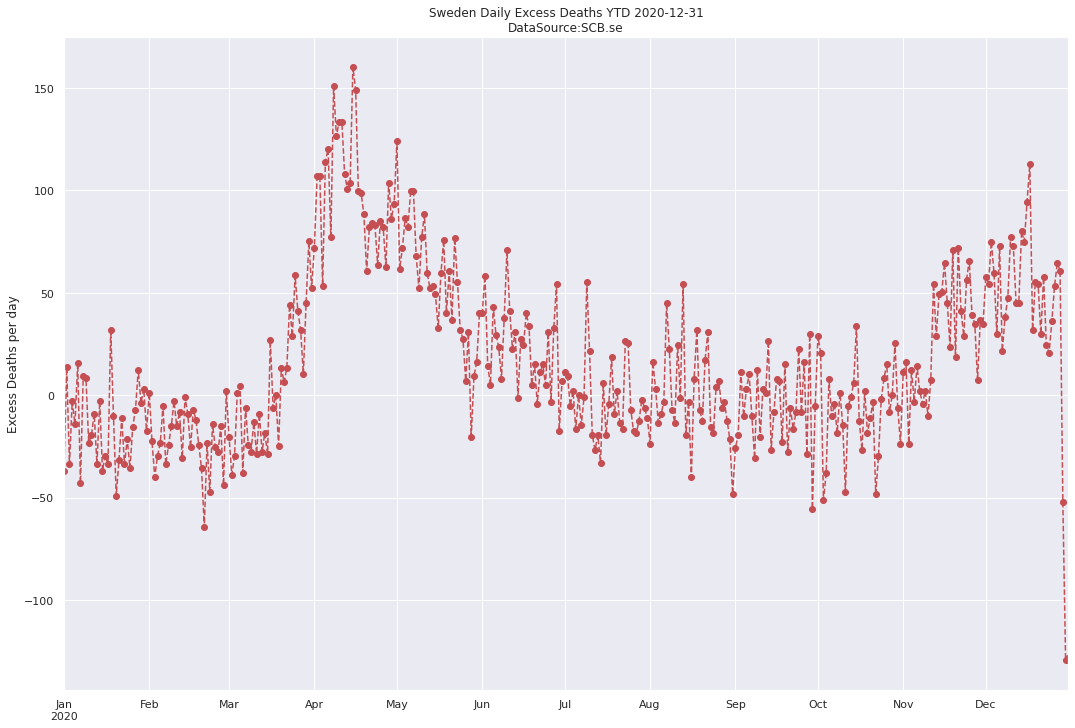

In [14]:
day_excess = scb['2020'][:last_data_day] - scb['2015-2019'][:last_data_day]
idx = day_excess.index.date
day_excess.plot(x=idx,figsize=(18,12),style='ro--',
               title='Sweden Daily Excess Deaths YTD {}\nDataSource:SCB.se'.format(last_data_day.date()))
plt.ylabel('Excess Deaths per day')

plt.savefig('scb_excess_deaths_per_day.jpg',format='jpg')

In [15]:
cumulative_until_last_day = scb[:last_data_day].sum()
cumulative_until_last_day['2020'] / cumulative_until_last_day['2015-2019']

1.0658505281863946

In [16]:
scb_weekly = scb.resample('W-TUE').sum() ### for correct yearly sum, use 'W-THU' !!!!. But that screws up graphs

print(scb_weekly.loc[:last_data_day].sum())
(scb_weekly.loc[:last_data_day,'2020'] - scb_weekly.loc[:last_data_day,'2015-2019']).sum()

2015         90363.257952
2016         90372.857323
2017         91380.662120
2018         91681.268066
2019         88279.667417
2020         96874.298601
2021           552.000000
2015-2019    90613.655463
2016-2020    91867.193092
dtype: float64


6260.6431385425585

In [17]:
scb_weekly

2015         2016         2017         2018         2019  \
2020-01-07  1957.673508  1886.707018  2246.469033  2053.992662  2024.668485   
2020-01-14  1974.854948  1945.986003  2161.406565  1995.395274  1856.718886   
2020-01-21  1957.673508  2012.419349  2139.884736  1999.507371  1887.629855   
2020-01-28  1949.588124  2020.595760  1969.759800  1982.030957  1861.870714   
2020-02-04  1986.983023  1973.581393  1960.536159  1905.957155  1927.814115   
2020-02-11  1938.470722  1955.184466  1878.548238  2038.572297  1903.085340   
2020-02-18  2071.879551  1822.317775  2053.797419  2080.721295  1807.261335   
2020-02-25  2171.936174  1915.324459  2122.462303  2175.299536  1906.176436   
2020-03-03  1761.602955  1845.824959  1794.510619  1929.601715  1539.366268   
2020-03-10  2049.644746  1938.831643  1919.542199  2283.242093  1741.317934   
2020-03-17  1906.129187  1789.612128  1879.573087  2163.991268  1884.538758   
2020-03-24  1866.712942  1879.552657  1762.740300  2081.749320  1681.556727   
2020-03-31  2000.121772  1777.347510  1785.286978  1975.862811  1715.558793   
2020-04-07  1825.275351  1819.251620  1887.771879  2042.684394  1749.560859   
2020-04-14  1852.563521  1747.708017  1745.317867  1877.172473  1660.949414   
2020-04-21  1867.723615  1793.700334  1768.889394  1717.828698  1788.714753   
2020-04-28  1730.272094  1760.994687  1840.628825  1707.548454  1749.560859   
2020-05-05  1678.727773  1680.252620  1763.765149  1717.828698  1661.979779   
2020-05-12  1665.589025  1606.664914  1754.541508  1612.970214  1692.890749   
2020-05-19  1692.877194  1611.775172  1669.479040  1569.793191  1604.279304   
2020-05-26  1665.589025  1537.165414  1655.131154  1491.663340  1531.123343   
2020-06-02  1655.482295  1601.554657  1643.857815  1488.579267  1587.793453   
2020-06-09  1614.044704  1526.944899  1650.006909  1574.933313  1590.884550   
2020-06-16  1627.183452  1555.562341  1586.466270  1476.242974  1487.847986   
2020-06-23  1605.959320  1555.562341  1547.522008  1527.644192  1572.337969   
2020-06-30  1523.084138  1603.598760  1575.192931  1672.595626  1557.912850   
2020-07-07  1725.218729  1577.025422  1660.255399  1639.698847  1583.671991   
2020-07-14  1581.703170  1658.789539  1554.695951  1627.362555  1605.309669   
2020-07-21  1531.169522  1609.731069  1579.292327  1768.201891  1527.001880   
2020-07-28  1579.681824  1715.002370  1506.528047  1684.931919  1559.973581   
2020-08-04  1570.585767  1608.709017  1558.795347  1779.510159  1536.275171   
2020-08-11  1550.372308  1569.871061  1591.590515  1509.139754  1595.006013   
2020-08-18  1522.073465  1647.546973  1546.497159  1545.120606  1531.123343   
2020-08-25  1590.799226  1589.290039  1630.534777  1527.644192  1588.823819   
2020-09-01  1492.763950  1663.899797  1555.720800  1613.998238  1691.860383   
2020-09-08  1645.375566  1686.384929  1623.360834  1677.735748  1484.756889   
2020-09-15  1581.703170  1540.231569  1640.783268  1560.540972  1606.340035   
2020-09-22  1593.831245  1564.760804  1628.485079  1682.875870  1586.763088   
2020-09-29  1655.482295  1629.150047  1566.994139  1618.110335  1698.042577   
2020-10-06  1615.055377  1616.885429  1698.174812  1623.250457  1687.738920   
2020-10-13  1583.724516  1641.414664  1763.765149  1738.389185  1704.224771   
2020-10-20  1608.991339  1798.810591  1689.976020  1607.830092  1671.253070   
2020-10-27  1701.973251  1685.362878  1674.603285  1704.464381  1776.350366   
2020-11-03  1690.855848  1737.487503  1748.392414  1755.865599  1687.738920   
2020-11-10  1705.005270  1735.443400  1699.199661  1681.847845  1749.560859   
2020-11-17  1697.930559  1806.987003  1784.262129  1569.793191  1724.832084   
2020-11-24  1711.069307  1777.347510  1747.367565  1595.493800  1763.985978   
2020-12-01  1707.026616  1782.457767  1760.690602  1791.846452  1739.257203   
2020-12-08  1831.339389  1824.361878  1817.057298  1846.331742  1783.562925   
2020-12-15  1691.866521  1894.883429  1847.802768  1771.285964  1771.

In [18]:
scb_weekly.sum()

2015         90907.0
2016         90982.0
2017         91972.0
2018         92185.0
2019         88766.0
2020         97164.0
2021           552.0
2015-2019    91161.0
2016-2020    92364.0
dtype: float64

In [19]:
scb_weekly['excess'] = scb_weekly['2020'] - scb_weekly['2015-2019']
scb_weekly['cumexcess'] = scb_weekly['excess'].cumsum()
scb_weekly

2015         2016         2017         2018         2019  \
2020-01-07  1957.673508  1886.707018  2246.469033  2053.992662  2024.668485   
2020-01-14  1974.854948  1945.986003  2161.406565  1995.395274  1856.718886   
2020-01-21  1957.673508  2012.419349  2139.884736  1999.507371  1887.629855   
2020-01-28  1949.588124  2020.595760  1969.759800  1982.030957  1861.870714   
2020-02-04  1986.983023  1973.581393  1960.536159  1905.957155  1927.814115   
2020-02-11  1938.470722  1955.184466  1878.548238  2038.572297  1903.085340   
2020-02-18  2071.879551  1822.317775  2053.797419  2080.721295  1807.261335   
2020-02-25  2171.936174  1915.324459  2122.462303  2175.299536  1906.176436   
2020-03-03  1761.602955  1845.824959  1794.510619  1929.601715  1539.366268   
2020-03-10  2049.644746  1938.831643  1919.542199  2283.242093  1741.317934   
2020-03-17  1906.129187  1789.612128  1879.573087  2163.991268  1884.538758   
2020-03-24  1866.712942  1879.552657  1762.740300  2081.749320  1681.556727   
2020-03-31  2000.121772  1777.347510  1785.286978  1975.862811  1715.558793   
2020-04-07  1825.275351  1819.251620  1887.771879  2042.684394  1749.560859   
2020-04-14  1852.563521  1747.708017  1745.317867  1877.172473  1660.949414   
2020-04-21  1867.723615  1793.700334  1768.889394  1717.828698  1788.714753   
2020-04-28  1730.272094  1760.994687  1840.628825  1707.548454  1749.560859   
2020-05-05  1678.727773  1680.252620  1763.765149  1717.828698  1661.979779   
2020-05-12  1665.589025  1606.664914  1754.541508  1612.970214  1692.890749   
2020-05-19  1692.877194  1611.775172  1669.479040  1569.793191  1604.279304   
2020-05-26  1665.589025  1537.165414  1655.131154  1491.663340  1531.123343   
2020-06-02  1655.482295  1601.554657  1643.857815  1488.579267  1587.793453   
2020-06-09  1614.044704  1526.944899  1650.006909  1574.933313  1590.884550   
2020-06-16  1627.183452  1555.562341  1586.466270  1476.242974  1487.847986   
2020-06-23  1605.959320  1555.562341  1547.522008  1527.644192  1572.337969   
2020-06-30  1523.084138  1603.598760  1575.192931  1672.595626  1557.912850   
2020-07-07  1725.218729  1577.025422  1660.255399  1639.698847  1583.671991   
2020-07-14  1581.703170  1658.789539  1554.695951  1627.362555  1605.309669   
2020-07-21  1531.169522  1609.731069  1579.292327  1768.201891  1527.001880   
2020-07-28  1579.681824  1715.002370  1506.528047  1684.931919  1559.973581   
2020-08-04  1570.585767  1608.709017  1558.795347  1779.510159  1536.275171   
2020-08-11  1550.372308  1569.871061  1591.590515  1509.139754  1595.006013   
2020-08-18  1522.073465  1647.546973  1546.497159  1545.120606  1531.123343   
2020-08-25  1590.799226  1589.290039  1630.534777  1527.644192  1588.823819   
2020-09-01  1492.763950  1663.899797  1555.720800  1613.998238  1691.860383   
2020-09-08  1645.375566  1686.384929  1623.360834  1677.735748  1484.756889   
2020-09-15  1581.703170  1540.231569  1640.783268  1560.540972  1606.340035   
2020-09-22  1593.831245  1564.760804  1628.485079  1682.875870  1586.763088   
2020-09-29  1655.482295  1629.150047  1566.994139  1618.110335  1698.042577   
2020-10-06  1615.055377  1616.885429  1698.174812  1623.250457  1687.738920   
2020-10-13  1583.724516  1641.414664  1763.765149  1738.389185  1704.224771   
2020-10-20  1608.991339  1798.810591  1689.976020  1607.830092  1671.253070   
2020-10-27  1701.973251  1685.362878  1674.603285  1704.464381  1776.350366   
2020-11-03  1690.855848  1737.487503  1748.392414  1755.865599  1687.738920   
2020-11-10  1705.005270  1735.443400  1699.199661  1681.847845  1749.560859   
2020-11-17  1697.930559  1806.987003  1784.262129  1569.793191  1724.832084   
2020-11-24  1711.069307  1777.347510  1747.367565  1595.493800  1763.985978   
2020-12-01  1707.026616  1782.457767  1760.690602  1791.846452  1739.257203   
2020-12-08  1831.339389  1824.361878  1817.057298  1846.331742  1783.562925   
2020-12-15  1691.866521  1894.883429  1847.802768  1771.285964  1771.

In [20]:
scb_monthly = scb.resample('M').sum()
scb_monthly['delta'] = scb_monthly['2020'] - scb_monthly['2015-2019']
scb_monthly['cumdelta'] = (scb_monthly['delta'].cumsum())
# last of feb not correct for delta - leap year
scb_monthly

2015         2016         2017         2018         2019  \
2020-01-31  8729.182285  8736.495984  9327.150855  8818.392921  8422.208752   
2020-02-29  8153.098703  7841.178894  8070.685966  8379.426521  7515.486988   
2020-03-31  8710.990172  8185.610241  8276.680618  9468.104313  7799.867905   
2020-04-30  7776.117692  7569.313203  7754.007622  7828.405467  7404.207499   
2020-05-31  7389.029951  7145.161842  7514.192953  6967.949081  7183.709251   
2020-06-30  6839.223865  6686.260731  6820.370172  6681.130286  6647.919118   
2020-07-31  7111.094889  7240.212629  6946.426601  7462.428796  6927.148207   
2020-08-31  6783.636853  7159.470562  6993.569655  6981.313398  7036.366965   
2020-09-30  6989.814135  6876.362305  6930.029017  6993.649690  6876.660290   
2020-10-31  7223.279587  7519.232681  7599.255421  7479.905210  7560.823076   
2020-11-30  7296.048039  7564.202945  7470.124446  7094.396077  7452.634684   
2020-12-31  7905.483829  8458.497984  8269.506675  8029.898240  7938.967266   

                    2020   2021    2015-2019    2016-2020        delta  \
2020-01-31   8347.920449  552.0  8809.689366  8733.126391  -461.768917   
2020-02-29   7567.164906    0.0  8191.752730  8025.895069  -624.587824   
2020-03-31   8599.611381    0.0  8487.421087  8466.246647   112.190293   
2020-04-30  10658.340470    0.0  7666.915818  8242.478246  2991.424652   
2020-05-31   8943.760206    0.0  7238.247854  7551.670293  1705.512352   
2020-06-30   7437.723856    0.0  6735.918568  6852.650656   701.805288   
2020-07-31   7037.072985    0.0  7133.894316  7120.556861   -96.821331   
2020-08-31   6973.379770    0.0  6988.617822  7030.228332   -15.238052   
2020-09-30   6766.890475    0.0  6932.348757  6888.576776  -165.458282   
2020-10-31   7246.644210    0.0  7477.647147  7481.870976  -231.002937   
2020-11-30   8222.588638    0.0  7375.339756  7559.881978   847.248882   
2020-12-31   9362.902655    0.0  8123.206779  8410.817777  1239.695876   

               cumdelta  
2020-01-31  -461.768917  
2020-02-29 -1086.356741  
2020-03-31  -974.166448  
2020-04-30  2017.258204  
2020-05-31  3722.770556  
2020-06-30  4424.575844  
2020-07-31  4327.754513  
2020-08-31  4312.516461  
2020-09-30  4147.058179  
2020-10-31  3916.055242  
2020-11-30  4763.304124  
2020-12-31  6003.000000

In [21]:
scb_monthly.sum()

2015         90907.000000
2016         90982.000000
2017         91972.000000
2018         92185.000000
2019         88766.000000
2020         97164.000000
2021           552.000000
2015-2019    91161.000000
2016-2020    92364.000000
delta         6003.000000
cumdelta     35112.001015
dtype: float64

In [22]:
scb_monthly.loc[:'2020-07-31'].sum()['2020'] / 10.327589

5673.308092774164

In [23]:
data = scb_weekly.iloc[:,0:5]
#data = data.iloc[:9]
data.mean(axis=1)
data

2015         2016         2017         2018         2019
2020-01-07  1957.673508  1886.707018  2246.469033  2053.992662  2024.668485
2020-01-14  1974.854948  1945.986003  2161.406565  1995.395274  1856.718886
2020-01-21  1957.673508  2012.419349  2139.884736  1999.507371  1887.629855
2020-01-28  1949.588124  2020.595760  1969.759800  1982.030957  1861.870714
2020-02-04  1986.983023  1973.581393  1960.536159  1905.957155  1927.814115
2020-02-11  1938.470722  1955.184466  1878.548238  2038.572297  1903.085340
2020-02-18  2071.879551  1822.317775  2053.797419  2080.721295  1807.261335
2020-02-25  2171.936174  1915.324459  2122.462303  2175.299536  1906.176436
2020-03-03  1761.602955  1845.824959  1794.510619  1929.601715  1539.366268
2020-03-10  2049.644746  1938.831643  1919.542199  2283.242093  1741.317934
2020-03-17  1906.129187  1789.612128  1879.573087  2163.991268  1884.538758
2020-03-24  1866.712942  1879.552657  1762.740300  2081.749320  1681.556727
2020-03-31  2000.121772  1777.347510  1785.286978  1975.862811  1715.558793
2020-04-07  1825.275351  1819.251620  1887.771879  2042.684394  1749.560859
2020-04-14  1852.563521  1747.708017  1745.317867  1877.172473  1660.949414
2020-04-21  1867.723615  1793.700334  1768.889394  1717.828698  1788.714753
2020-04-28  1730.272094  1760.994687  1840.628825  1707.548454  1749.560859
2020-05-05  1678.727773  1680.252620  1763.765149  1717.828698  1661.979779
2020-05-12  1665.589025  1606.664914  1754.541508  1612.970214  1692.890749
2020-05-19  1692.877194  1611.775172  1669.479040  1569.793191  1604.279304
2020-05-26  1665.589025  1537.165414  1655.131154  1491.663340  1531.123343
2020-06-02  1655.482295  1601.554657  1643.857815  1488.579267  1587.793453
2020-06-09  1614.044704  1526.944899  1650.006909  1574.933313  1590.884550
2020-06-16  1627.183452  1555.562341  1586.466270  1476.242974  1487.847986
2020-06-23  1605.959320  1555.562341  1547.522008  1527.644192  1572.337969
2020-06-30  1523.084138  1603.598760  1575.192931  1672.595626  1557.912850
2020-07-07  1725.218729  1577.025422  1660.255399  1639.698847  1583.671991
2020-07-14  1581.703170  1658.789539  1554.695951  1627.362555  1605.309669
2020-07-21  1531.169522  1609.731069  1579.292327  1768.201891  1527.001880
2020-07-28  1579.681824  1715.002370  1506.528047  1684.931919  1559.973581
2020-08-04  1570.585767  1608.709017  1558.795347  1779.510159  1536.275171
2020-08-11  1550.372308  1569.871061  1591.590515  1509.139754  1595.006013
2020-08-18  1522.073465  1647.546973  1546.497159  1545.120606  1531.123343
2020-08-25  1590.799226  1589.290039  1630.534777  1527.644192  1588.823819
2020-09-01  1492.763950  1663.899797  1555.720800  1613.998238  1691.860383
2020-09-08  1645.375566  1686.384929  1623.360834  1677.735748  1484.756889
2020-09-15  1581.703170  1540.231569  1640.783268  1560.540972  1606.340035
2020-09-22  1593.831245  1564.760804  1628.485079  1682.875870  1586.763088
2020-09-29  1655.482295  1629.150047  1566.994139  1618.110335  1698.042577
2020-10-06  1615.055377  1616.885429  1698.174812  1623.250457  1687.738920
2020-10-13  1583.724516  1641.414664  1763.765149  1738.389185  1704.224771
2020-10-20  1608.991339  1798.810591  1689.976020  1607.830092  1671.253070
2020-10-27  1701.973251  1685.362878  1674.603285  1704.464381  1776.350366
2020-11-03  1690.855848  1737.487503  1748.392414  1755.865599  1687.738920
2020-11-10  1705.005270  1735.443400  1699.199661  1681.847845  1749.560859
2020-11-17  1697.930559  1806.987003  1784.262129  1569.793191  1724.832084
2020-11-24  1711.069307  1777.347510  1747.367565  1595.493800  1763.985978
2020-12-01  1707.026616  1782.457767  1760.690602  1791.846452  1739.257203
2020-12-08  1831.339389  1824.361878  1817.057298  1846.331742  1783.562925
2020-12-15  1691.866521  1894.883429  1847.802768  1771.285964  1771.198537
2020-12-22  1787.880452  1862.177782  1778.113035  1795.958549  1881.447661
2020-12-29  1812.136603  1984.823959  1964.635555  1820.631133  177

In [24]:
data_min = data.min(axis=1)
data_max = data.max(axis=1)

print (data.mean().mean())

1716.2716981132075


In [25]:
walk = 1000
tune = 500
chains = 2


res_array = np.zeros((len(data),3))
dist_array = np.zeros((len(data),walk*chains))

for i in range(len(data)):
    
    model1 = pm.Model()
    
    with model1:
        
        print ('\n++++++++++++++++++++ processing day ++++++++++++++++++++', i)
        print (data.iloc[i,:])
        print (data.iloc[i,:].mean())

        lambda_ = pm.Exponential('lambda',1/ data.iloc[i,:].mean())
        lkh  = pm.Poisson('lkh',lambda_,observed=data.iloc[i,:])
        
        trace1 = pm.sample(walk,tune=tune)
        post = trace1['lambda'][:]   

        res_array[i,0] = post.min()
        res_array[i,1] = post.mean()
        res_array[i,2] = post.max()

        dist_array[i,:] = post
                     
    


++++++++++++++++++++ processing day ++++++++++++++++++++ 0
2015    1957.673508
2016    1886.707018
2017    2246.469033
2018    2053.992662
2019    2024.668485
Name: 2020-01-07 00:00:00, dtype: float64
2033.902141226697


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.



++++++++++++++++++++ processing day ++++++++++++++++++++ 1
2015    1974.854948
2016    1945.986003
2017    2161.406565
2018    1995.395274
2019    1856.718886
Name: 2020-01-14 00:00:00, dtype: float64
1986.8723351882443


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 2
2015    1957.673508
2016    2012.419349
2017    2139.884736
2018    1999.507371
2019    1887.629855
Name: 2020-01-21 00:00:00, dtype: float64
1999.4229637735218


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8847801373101807, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 3
2015    1949.588124
2016    2020.595760
2017    1969.759800
2018    1982.030957
2019    1861.870714
Name: 2020-01-28 00:00:00, dtype: float64
1956.7690712054537


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8880385960794205, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 4
2015    1986.983023
2016    1973.581393
2017    1960.536159
2018    1905.957155
2019    1927.814115
Name: 2020-02-04 00:00:00, dtype: float64
1950.9743690329828


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 5
2015    1938.470722
2016    1955.184466
2017    1878.548238
2018    2038.572297
2019    1903.085340
Name: 2020-02-11 00:00:00, dtype: float64
1942.772212501392


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 6
2015    2071.879551
2016    1822.317775
2017    2053.797419
2018    2080.721295
2019    1807.261335
Name: 2020-02-18 00:00:00, dtype: float64
1967.195475137119


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.



++++++++++++++++++++ processing day ++++++++++++++++++++ 7
2015    2171.936174
2016    1915.324459
2017    2122.462303
2018    2175.299536
2019    1906.176436
Name: 2020-02-25 00:00:00, dtype: float64
2058.2397815858885


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8797503075303369, but should be close to 0.8. Try to increase the number of tuning steps.



++++++++++++++++++++ processing day ++++++++++++++++++++ 8
2015    1761.602955
2016    1845.824959
2017    1794.510619
2018    1929.601715
2019    1539.366268
Name: 2020-03-03 00:00:00, dtype: float64
1774.1813032795567


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 9
2015    2049.644746
2016    1938.831643
2017    1919.542199
2018    2283.242093
2019    1741.317934
Name: 2020-03-10 00:00:00, dtype: float64
1986.5157230049176


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8940681332604312, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 10
2015    1906.129187
2016    1789.612128
2017    1879.573087
2018    2163.991268
2019    1884.538758
Name: 2020-03-17 00:00:00, dtype: float64
1924.7688856776665


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 11
2015    1866.712942
2016    1879.552657
2017    1762.740300
2018    2081.749320
2019    1681.556727
Name: 2020-03-24 00:00:00, dtype: float64
1854.4623891434876


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 12
2015    2000.121772
2016    1777.347510
2017    1785.286978
2018    1975.862811
2019    1715.558793
Name: 2020-03-31 00:00:00, dtype: float64
1850.8355727911512


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8821106426459652, but should be close to 0.8. Try to increase the number of tuning steps.



++++++++++++++++++++ processing day ++++++++++++++++++++ 13
2015    1825.275351
2016    1819.251620
2017    1887.771879
2018    2042.684394
2019    1749.560859
Name: 2020-04-07 00:00:00, dtype: float64
1864.9088208143814


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8863699394294745, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8810027781932844, but should be close to 0.8. Try to increase the number of tuning steps.



++++++++++++++++++++ processing day ++++++++++++++++++++ 14
2015    1852.563521
2016    1747.708017
2017    1745.317867
2018    1877.172473
2019    1660.949414
Name: 2020-04-14 00:00:00, dtype: float64
1776.7422583458101


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.



++++++++++++++++++++ processing day ++++++++++++++++++++ 15
2015    1867.723615
2016    1793.700334
2017    1768.889394
2018    1717.828698
2019    1788.714753
Name: 2020-04-21 00:00:00, dtype: float64
1787.3713587907164


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8895433892972238, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 16
2015    1730.272094
2016    1760.994687
2017    1840.628825
2018    1707.548454
2019    1749.560859
Name: 2020-04-28 00:00:00, dtype: float64
1757.800983656244


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 17
2015    1678.727773
2016    1680.252620
2017    1763.765149
2018    1717.828698
2019    1661.979779
Name: 2020-05-05 00:00:00, dtype: float64
1700.5108039214851


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.



++++++++++++++++++++ processing day ++++++++++++++++++++ 18
2015    1665.589025
2016    1606.664914
2017    1754.541508
2018    1612.970214
2019    1692.890749
Name: 2020-05-12 00:00:00, dtype: float64
1666.5312818239013


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.9001177541562775, but should be close to 0.8. Try to increase the number of tuning steps.



++++++++++++++++++++ processing day ++++++++++++++++++++ 19
2015    1692.877194
2016    1611.775172
2017    1669.479040
2018    1569.793191
2019    1604.279304
Name: 2020-05-19 00:00:00, dtype: float64
1629.6407800269412


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8850329920431025, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 20
2015    1665.589025
2016    1537.165414
2017    1655.131154
2018    1491.663340
2019    1531.123343
Name: 2020-05-26 00:00:00, dtype: float64
1576.1344550516355


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 21
2015    1655.482295
2016    1601.554657
2017    1643.857815
2018    1488.579267
2019    1587.793453
Name: 2020-06-02 00:00:00, dtype: float64
1595.4534973128775


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8839189872781521, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 22
2015    1614.044704
2016    1526.944899
2017    1650.006909
2018    1574.933313
2019    1590.884550
Name: 2020-06-09 00:00:00, dtype: float64
1591.3628749841398


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.9087890003925024, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 23
2015    1627.183452
2016    1555.562341
2017    1586.466270
2018    1476.242974
2019    1487.847986
Name: 2020-06-16 00:00:00, dtype: float64
1546.6606047083576


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.9004277223544873, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 24
2015    1605.959320
2016    1555.562341
2017    1547.522008
2018    1527.644192
2019    1572.337969
Name: 2020-06-23 00:00:00, dtype: float64
1561.8051658943346


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.88223843976276, but should be close to 0.8. Try to increase the number of tuning steps.



++++++++++++++++++++ processing day ++++++++++++++++++++ 25
2015    1523.084138
2016    1603.598760
2017    1575.192931
2018    1672.595626
2019    1557.912850
Name: 2020-06-30 00:00:00, dtype: float64
1586.476861012369


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8803045468735682, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 26
2015    1725.218729
2016    1577.025422
2017    1660.255399
2018    1639.698847
2019    1583.671991
Name: 2020-07-07 00:00:00, dtype: float64
1637.1740773557426


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8894907886675042, but should be close to 0.8. Try to increase the number of tuning steps.



++++++++++++++++++++ processing day ++++++++++++++++++++ 27
2015    1581.703170
2016    1658.789539
2017    1554.695951
2018    1627.362555
2019    1605.309669
Name: 2020-07-14 00:00:00, dtype: float64
1605.5721766790825


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8810177226236706, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 28
2015    1531.169522
2016    1609.731069
2017    1579.292327
2018    1768.201891
2019    1527.001880
Name: 2020-07-21 00:00:00, dtype: float64
1603.0793378742396


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8850051421878701, but should be close to 0.8. Try to increase the number of tuning steps.



++++++++++++++++++++ processing day ++++++++++++++++++++ 29
2015    1579.681824
2016    1715.002370
2017    1506.528047
2018    1684.931919
2019    1559.973581
Name: 2020-07-28 00:00:00, dtype: float64
1609.2235481200887


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 30
2015    1570.585767
2016    1608.709017
2017    1558.795347
2018    1779.510159
2019    1536.275171
Name: 2020-08-04 00:00:00, dtype: float64
1610.7750922941143


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.9067661231593872, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 31
2015    1550.372308
2016    1569.871061
2017    1591.590515
2018    1509.139754
2019    1595.006013
Name: 2020-08-11 00:00:00, dtype: float64
1563.1959301881666


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8803657392426661, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 32
2015    1522.073465
2016    1647.546973
2017    1546.497159
2018    1545.120606
2019    1531.123343
Name: 2020-08-18 00:00:00, dtype: float64
1558.4723092680208


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.



++++++++++++++++++++ processing day ++++++++++++++++++++ 33
2015    1590.799226
2016    1589.290039
2017    1630.534777
2018    1527.644192
2019    1588.823819
Name: 2020-08-25 00:00:00, dtype: float64
1585.4184107953602


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8851006832822047, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8816828273456105, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 34
2015    1492.763950
2016    1663.899797
2017    1555.720800
2018    1613.998238
2019    1691.860383
Name: 2020-09-01 00:00:00, dtype: float64
1603.6486334511287


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8899748751100467, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 35
2015    1645.375566
2016    1686.384929
2017    1623.360834
2018    1677.735748
2019    1484.756889
Name: 2020-09-08 00:00:00, dtype: float64
1623.5227932538605


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8832426337965649, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 36
2015    1581.703170
2016    1540.231569
2017    1640.783268
2018    1560.540972
2019    1606.340035
Name: 2020-09-15 00:00:00, dtype: float64
1585.9198024277828


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 37
2015    1593.831245
2016    1564.760804
2017    1628.485079
2018    1682.875870
2019    1586.763088
Name: 2020-09-22 00:00:00, dtype: float64
1611.3432171728855


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 38
2015    1655.482295
2016    1629.150047
2017    1566.994139
2018    1618.110335
2019    1698.042577
Name: 2020-09-29 00:00:00, dtype: float64
1633.5558785694834


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.881782092337738, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 39
2015    1615.055377
2016    1616.885429
2017    1698.174812
2018    1623.250457
2019    1687.738920
Name: 2020-10-06 00:00:00, dtype: float64
1648.2209991915347


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 40
2015    1583.724516
2016    1641.414664
2017    1763.765149
2018    1738.389185
2019    1704.224771
Name: 2020-10-13 00:00:00, dtype: float64
1686.3036569188837


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.



++++++++++++++++++++ processing day ++++++++++++++++++++ 41
2015    1608.991339
2016    1798.810591
2017    1689.976020
2018    1607.830092
2019    1671.253070
Name: 2020-10-20 00:00:00, dtype: float64
1675.3722225210288


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8796930125008805, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 42
2015    1701.973251
2016    1685.362878
2017    1674.603285
2018    1704.464381
2019    1776.350366
Name: 2020-10-27 00:00:00, dtype: float64
1708.5508320833796


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 43
2015    1690.855848
2016    1737.487503
2017    1748.392414
2018    1755.865599
2019    1687.738920
Name: 2020-11-03 00:00:00, dtype: float64
1724.0680568960445


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8876715900689455, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 44
2015    1705.005270
2016    1735.443400
2017    1699.199661
2018    1681.847845
2019    1749.560859
Name: 2020-11-10 00:00:00, dtype: float64
1714.2114070386


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8901828985265156, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 45
2015    1697.930559
2016    1806.987003
2017    1784.262129
2018    1569.793191
2019    1724.832084
Name: 2020-11-17 00:00:00, dtype: float64
1716.7609930822643


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 46
2015    1711.069307
2016    1777.347510
2017    1747.367565
2018    1595.493800
2019    1763.985978
Name: 2020-11-24 00:00:00, dtype: float64
1719.0528319861594


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 47
2015    1707.026616
2016    1782.457767
2017    1760.690602
2018    1791.846452
2019    1739.257203
Name: 2020-12-01 00:00:00, dtype: float64
1756.2557278260497


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8873629428002903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.910617914916437, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 48
2015    1831.339389
2016    1824.361878
2017    1817.057298
2018    1846.331742
2019    1783.562925
Name: 2020-12-08 00:00:00, dtype: float64
1820.5306463238842


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 49
2015    1691.866521
2016    1894.883429
2017    1847.802768
2018    1771.285964
2019    1771.198537
Name: 2020-12-15 00:00:00, dtype: float64
1795.407444109847


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 50
2015    1787.880452
2016    1862.177782
2017    1778.113035
2018    1795.958549
2019    1881.447661
Name: 2020-12-22 00:00:00, dtype: float64
1821.1154958456423


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8928092307193832, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



++++++++++++++++++++ processing day ++++++++++++++++++++ 51
2015    1812.136603
2016    1984.823959
2017    1964.635555
2018    1820.631133
2019    1770.168172
Name: 2020-12-29 00:00:00, dtype: float64
1870.4790844224203


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8844193525186342, but should be close to 0.8. Try to increase the number of tuning steps.



++++++++++++++++++++ processing day ++++++++++++++++++++ 52
2015    543.742048
2016    609.142677
2017    591.337880
2018    503.731934
2019    486.332583
Name: 2021-01-05 00:00:00, dtype: float64
546.8574244130309


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.


In [26]:
dist_array

array([[2036.8160142 , 2018.41672243, 2011.7091483 , ..., 2044.57079658,
        2044.57079658, 2041.09989796],
       [2011.70654481, 2026.5047648 , 2013.53684034, ..., 2014.66969002,
        1986.17752112, 1970.39760474],
       [2012.04358481, 2013.56214966, 2034.43517343, ..., 2002.29859328,
        2035.34181198, 1994.99909777],
       ...,
       [1821.57155367, 1801.27700459, 1801.27700459, ..., 1817.16839086,
        1823.1805586 , 1801.7142921 ],
       [1896.36660123, 1897.54133843, 1839.13641381, ..., 1846.20031291,
        1872.86591932, 1853.50827842],
       [ 549.86692074,  560.24984505,  555.73088186, ...,  543.58048108,
         537.27584475,  557.71425644]])

In [27]:
N = 1000

lambdas_per_week = np.zeros((len(dist_array),N))
samples_per_week = np.zeros((len(dist_array),N))

for week in range(len(dist_array)):
    
    lambdas_per_week[week] = np.random.choice(dist_array[week],replace=True,size=N)
    pois_dist = pm.Poisson.dist(lambdas_per_week[week])
    samples_per_week[week] = pois_dist.random(size=N)

In [28]:
print (lambdas_per_week[:5])
samples_per_week[:5]

[[2025.65013074 1991.28028585 2043.7066769  ... 2042.99446287
  2044.75679742 2055.55989096]
 [2004.36390367 1989.24234589 1972.95627155 ... 1987.37466764
  2007.20237994 2024.02285619]
 [2023.44417346 2015.92615996 1978.73454232 ... 1990.91089112
  2032.55644956 2026.00062861]
 [1948.63645454 1933.18996605 1919.69744646 ... 1953.90448211
  1960.56173666 1982.87375652]
 [1923.98473451 1920.58110882 1922.47668977 ... 1975.73690245
  1981.903605   1966.95999849]]


array([[2043., 2028., 2155., ..., 2031., 2118., 2048.],
       [2016., 2040., 1954., ..., 1994., 2065., 1983.],
       [2037., 1934., 2160., ..., 1974., 2038., 1950.],
       [1906., 1990., 1927., ..., 1941., 2014., 2042.],
       [1905., 1916., 1928., ..., 1944., 2018., 2004.]])

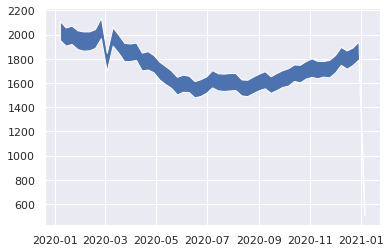

In [29]:
ci_samples = np.percentile(samples_per_week,[5.5,94.5],axis=1)
ci_samples

plt.fill_between(scb_weekly.index,ci_samples[0],ci_samples[1])

In [30]:
res_array

array([[1962.04926275, 2034.13578164, 2115.76853425],
       [1912.48800932, 1986.35841586, 2052.13894149],
       [1937.94361073, 1998.87593174, 2058.80683488],
       [1884.86023027, 1954.69975953, 2008.44520182],
       [1882.43725487, 1949.7327756 , 2011.90227639],
       [1878.85964495, 1942.55227899, 2009.63817874],
       [1902.5284711 , 1966.69098251, 2033.11013585],
       [1984.48395613, 2056.93347772, 2121.09801961],
       [1714.78478716, 1772.9907066 , 1836.33711491],
       [1916.60626466, 1986.94106097, 2055.59754649],
       [1855.51696588, 1923.4121888 , 1997.23533034],
       [1785.69015824, 1853.403842  , 1917.48425955],
       [1789.889433  , 1850.76838686, 1915.08164329],
       [1800.60995879, 1864.7353297 , 1924.29229012],
       [1712.86722317, 1777.30785221, 1857.3375502 ],
       [1722.41852073, 1786.1780885 , 1849.5956793 ],
       [1699.54462232, 1756.53921286, 1823.32143816],
       [1642.40676749, 1700.97136471, 1776.44060281],
       [1601.78832841, 1665.

In [31]:
errors_low = np.abs(res_array[:,1] - res_array[:,0])
errors_low = errors_low[:-1]
errors_high = np.abs(res_array[:,1] - res_array[:,2]) 
errors_high = errors_high[:-1]
print (errors_low)
print (errors_high)

errors = np.array((errors_low,errors_high))
errors

[72.08651889 73.87040654 60.932321   69.83952926 67.29552073 63.69263404
 64.16251141 72.44952159 58.20591944 70.33479631 67.89522291 67.71368375
 60.87895387 64.12537091 64.44062904 63.75956777 56.99459054 58.56459722
 63.96149005 70.36213162 55.24953957 53.39880844 54.32156724 53.44217464
 58.70528316 56.3870705  63.58439787 68.34748973 70.09012026 61.70240951
 58.41284854 68.16341787 55.54036089 60.83923076 63.49769404 67.13524839
 67.09889875 56.23555512 62.27215312 48.32892247 76.40890569 68.19199557
 60.93678826 57.84798387 53.94247724 65.87011082 58.73807271 74.37489832
 62.71448174 69.25042826 71.75127233 63.5303058 ]
[81.63275261 65.78052563 59.93090314 53.74544229 62.16950078 67.08589975
 66.41915334 64.16454189 63.34640831 68.65648552 73.82314155 64.08041755
 64.31325643 59.55696042 80.02969799 63.4175908  66.7822253  75.4692381
 70.74079912 83.13659639 64.02037714 65.84726714 64.81226392 69.21480576
 62.13745403 59.43509464 71.64686535 53.64025026 63.72548157 71.11748633
 6

array([[72.08651889, 73.87040654, 60.932321  , 69.83952926, 67.29552073,
        63.69263404, 64.16251141, 72.44952159, 58.20591944, 70.33479631,
        67.89522291, 67.71368375, 60.87895387, 64.12537091, 64.44062904,
        63.75956777, 56.99459054, 58.56459722, 63.96149005, 70.36213162,
        55.24953957, 53.39880844, 54.32156724, 53.44217464, 58.70528316,
        56.3870705 , 63.58439787, 68.34748973, 70.09012026, 61.70240951,
        58.41284854, 68.16341787, 55.54036089, 60.83923076, 63.49769404,
        67.13524839, 67.09889875, 56.23555512, 62.27215312, 48.32892247,
        76.40890569, 68.19199557, 60.93678826, 57.84798387, 53.94247724,
        65.87011082, 58.73807271, 74.37489832, 62.71448174, 69.25042826,
        71.75127233, 63.5303058 ],
       [81.63275261, 65.78052563, 59.93090314, 53.74544229, 62.16950078,
        67.08589975, 66.41915334, 64.16454189, 63.34640831, 68.65648552,
        73.82314155, 64.08041755, 64.31325643, 59.55696042, 80.02969799,
        63.41759

2020-01-07   -101.496712
2020-01-14    -70.872271
2020-01-21   -159.170092
2020-01-28   -112.091749
2020-02-04   -109.030999
2020-02-11   -120.369532
2020-02-18    -93.557810
2020-02-25   -234.949573
2020-03-03   -173.666804
2020-03-10   -103.754661
2020-03-17    -91.681103
2020-03-24     81.646225
2020-03-31    314.828634
2020-04-07    650.818283
2020-04-14    856.939044
2020-04-21    738.849235
2020-04-28    565.111013
2020-05-05    605.953485
2020-05-12    544.179337
2020-05-19    363.224529
2020-05-26    296.233347
2020-06-02    174.055478
2020-06-09    161.715051
2020-06-16    215.976092
2020-06-23    116.390569
2020-06-30    109.296829
2020-07-07    -13.772797
2020-07-14    -23.145667
2020-07-21    -20.076446
2020-07-28    -20.051029
2020-08-04    -37.506826
2020-08-11     58.865450
2020-08-18     30.083828
2020-08-25     -1.661115
2020-09-01   -110.475483
2020-09-08    -46.697547
2020-09-15    -12.953053
2020-09-22    -42.643376
2020-09-29    -32.277084
2020-10-06    -47.618957


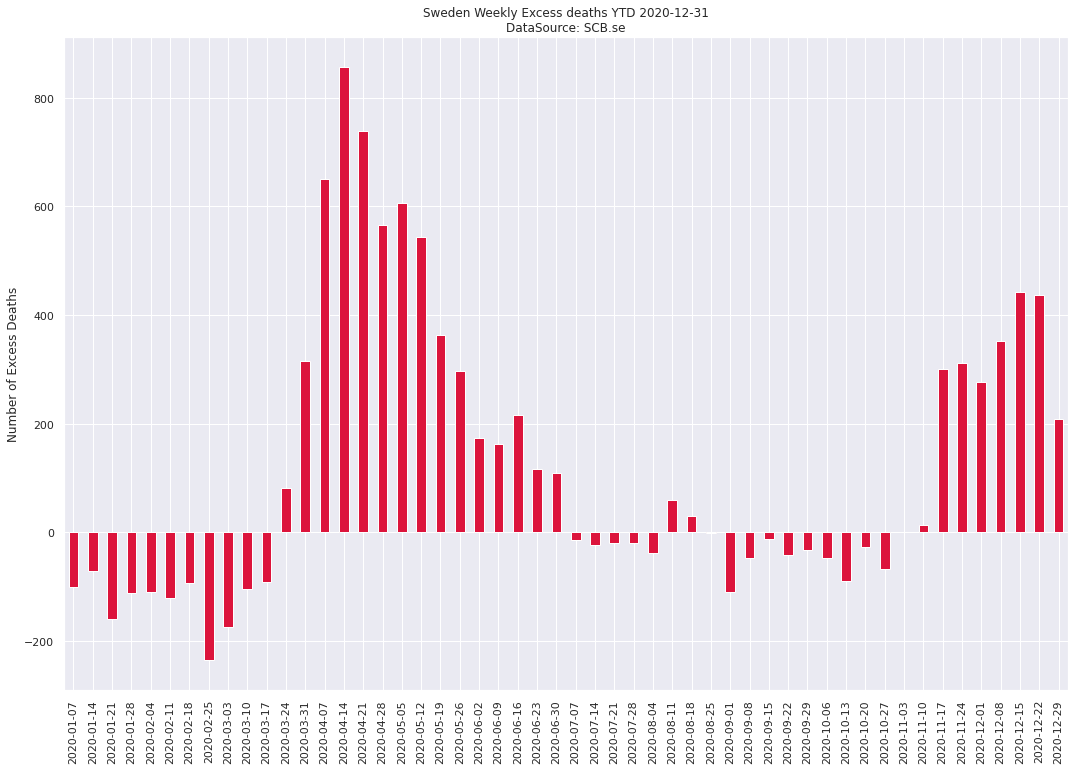

In [32]:
excess = scb_weekly.loc[:last_data_day,'2020'] - scb_weekly.loc[:last_data_day,'2015-2019']
print (excess)
current_excess = excess.cumsum()
print (current_excess)
excess.index = excess.index.date
excess.plot.bar(x=excess.index,title='Sweden Weekly Excess deaths YTD {}\nDataSource: SCB.se'.format(last_data_day.date()),
                y=excess,
                figsize=(18,12),
                color='crimson')
plt.ylabel('Number of Excess Deaths')
plt.savefig('swe_excess_deaths.jpg',format='jpg',dpi=400)

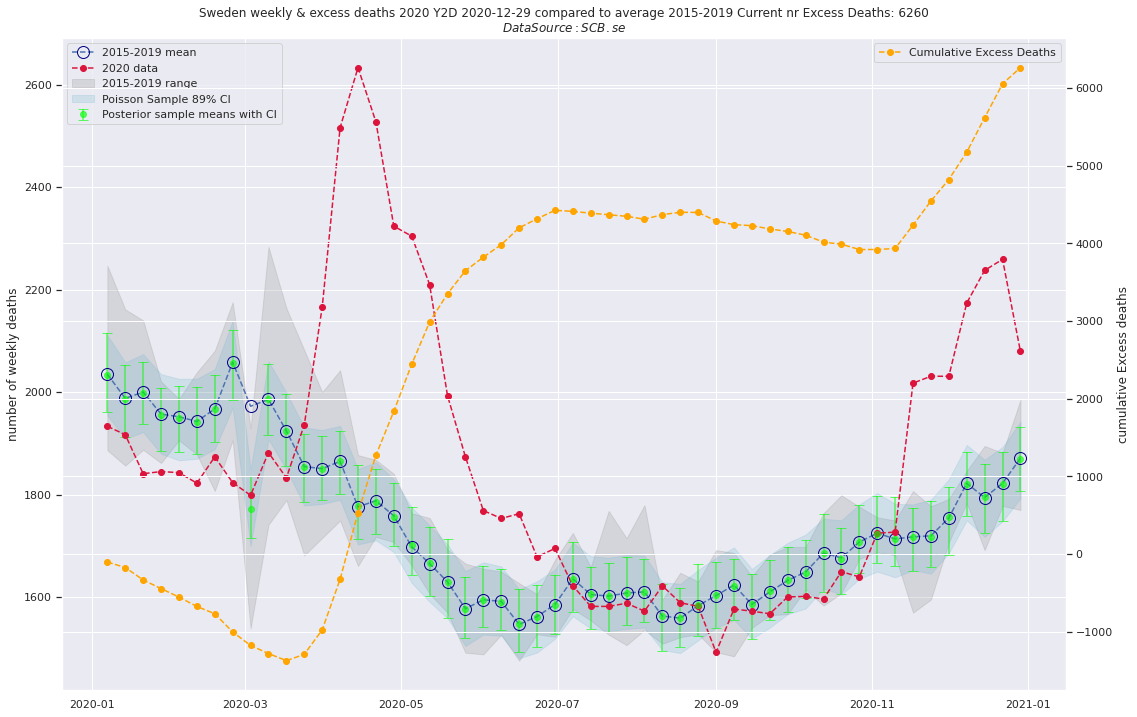

In [33]:
plt.figure(figsize=(18,12))
plt.title('Sweden weekly & excess deaths 2020 Y2D '\
          '{} compared to average 2015-2019 Current nr Excess Deaths: {}\n$Data Source: SCB.se$'.format(
    excess.index[-1],int(current_excess[-1])))
ax = plt.gca()
ax2 = plt.twinx()

ax.errorbar(scb_weekly.index[:len(data) - 1],res_array[:-1,1],yerr=errors,
             fmt='o',capsize=5,color='lime',alpha=0.6,label='Posterior sample means with CI')

ax.plot(scb_weekly.index[:len(data) -1],scb_weekly['2015-2019'][:-1],'o--',
        markerfacecolor='none',markeredgecolor='navy',markersize=12,
        label='2015-2019 mean')

ax.plot(scb_weekly[:last_data_day].index,scb_weekly.loc[:last_data_day,'2020'],'o--',
         color='crimson',label='2020 data')

ax.fill_between(scb_weekly.index[:len(data) -1],y1=data_min[:-1],y2=data_max[:-1],color='grey',
                 alpha=0.2,label='2015-2019 range')

ax.fill_between(scb_weekly.index[:len(data) -1],y1=ci_samples[0][:-1],y2=ci_samples[1][:-1],color='c',
                 alpha=0.2,label='Poisson Sample 89% CI')



ax2.plot(excess.index,excess.cumsum(),'o--',ls='dashed',color='orange',label='Cumulative Excess Deaths')
ax.set_ylabel('number of weekly deaths')
ax2.set_ylabel('cumulative Excess deaths')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig('scb_poisson_weekly.jpg',format='jpg',dpi=400)

In [34]:
last_complete_month = '2020-12-31'
last_complete_month

'2020-12-31'

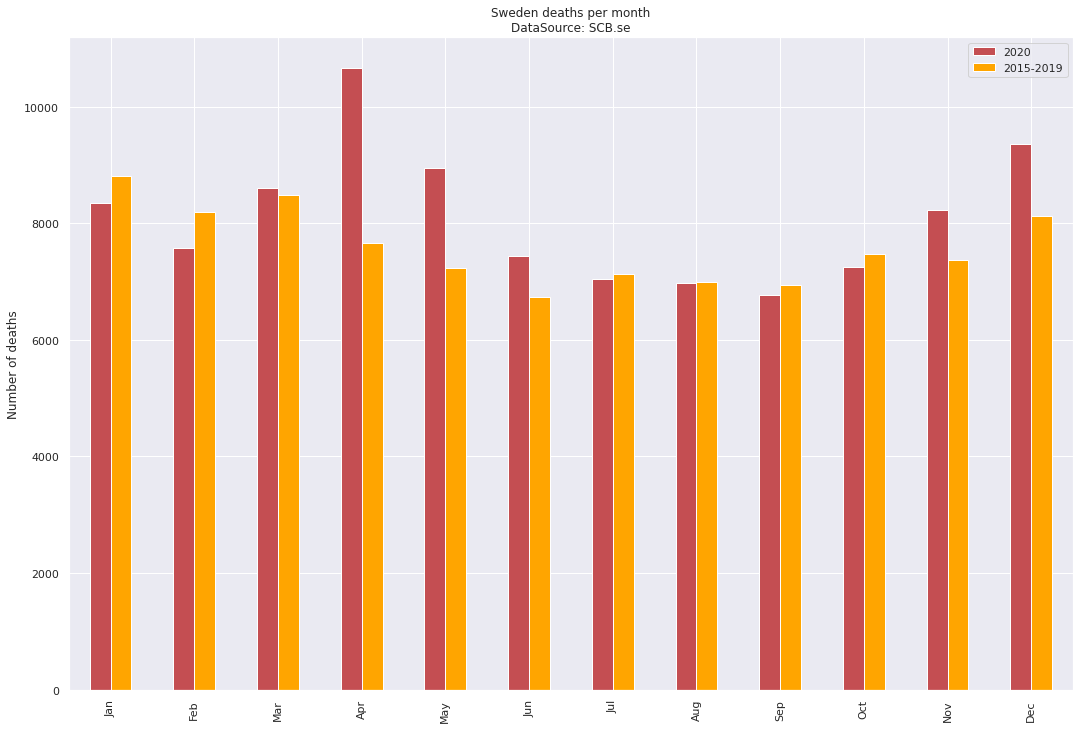

In [35]:
#scb_monthly.index = scb_monthly.index.date
scb_monthly[['2020','2015-2019']][:pd.Timestamp(last_complete_month)].plot.bar(color=['r','orange'],
                                                                        title='Sweden deaths per month\nDataSource: SCB.se',figsize=(18,12))
plt.ylabel('Number of deaths')
plt.xticks(range(len(scb_monthly[:pd.Timestamp(last_complete_month)])),['Jan','Feb','Mar','Apr','May','Jun','Jul',
                                                                'Aug','Sep','Oct','Nov','Dec'])
plt.savefig('scb_monthly_deaths.jpg',format='jpg')

In [36]:
### population 2014-2019
url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101A/BefolkningR1860'
data = {
  "query": [
    {
      "code": "Alder",
      "selection": {
        "filter": "vs:ÅlderTotA",
        "values": []
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2014",  
          "2015",
          "2016",
          "2017",
          "2018",
          "2019"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [37]:
r = requests.post(url,json=data)
r.status_code

200

In [38]:
json = r.json()

In [39]:
data_list = []

for rec in range(len(json['data'])):
    data_list.append((json['data'][rec]['key'][0],json['data'][rec]['key'][1],json['data'][rec]['values'][0]))

In [40]:
population = pd.DataFrame(data_list,columns=['gender','year','population'])
population = population.set_index('year')
population['population'] = population['population'].astype(int)

In [41]:
population = population.groupby(population.index).sum()
population['growth'] = population['population'] / population['population'].shift()


population.loc['2020','population'] = population.loc['2019','population']  
population['population'] = population['population'].astype(int)
population

population    growth
year                      
2014     9747355       NaN
2015     9851017  1.010635
2016     9995153  1.014632
2017    10120242  1.012515
2018    10230185  1.010864
2019    10327589  1.009521
2020    10327589       NaN

In [42]:
pop = population['population']
pop = pop.shift()
pop

year
2014           NaN
2015     9747355.0
2016     9851017.0
2017     9995153.0
2018    10120242.0
2019    10230185.0
2020    10327589.0
Name: population, dtype: float64

In [43]:
pop.drop('2014',inplace=True)
pop.to_pickle('pop_2015_2020.pkl')
pop

year
2015     9747355.0
2016     9851017.0
2017     9995153.0
2018    10120242.0
2019    10230185.0
2020    10327589.0
Name: population, dtype: float64

In [44]:
weekly_deaths = scb_weekly.loc[:,'2015':'2020'].copy()
weekly_deaths['2015-2018'] = weekly_deaths.loc[:,'2015':'2018'].mean(axis=1)

weekly_deaths_no_truncate = weekly_deaths.copy()
weekly_deaths = weekly_deaths[:-1]
weekly_deaths

2015         2016         2017         2018         2019  \
2020-01-07  1957.673508  1886.707018  2246.469033  2053.992662  2024.668485   
2020-01-14  1974.854948  1945.986003  2161.406565  1995.395274  1856.718886   
2020-01-21  1957.673508  2012.419349  2139.884736  1999.507371  1887.629855   
2020-01-28  1949.588124  2020.595760  1969.759800  1982.030957  1861.870714   
2020-02-04  1986.983023  1973.581393  1960.536159  1905.957155  1927.814115   
2020-02-11  1938.470722  1955.184466  1878.548238  2038.572297  1903.085340   
2020-02-18  2071.879551  1822.317775  2053.797419  2080.721295  1807.261335   
2020-02-25  2171.936174  1915.324459  2122.462303  2175.299536  1906.176436   
2020-03-03  1761.602955  1845.824959  1794.510619  1929.601715  1539.366268   
2020-03-10  2049.644746  1938.831643  1919.542199  2283.242093  1741.317934   
2020-03-17  1906.129187  1789.612128  1879.573087  2163.991268  1884.538758   
2020-03-24  1866.712942  1879.552657  1762.740300  2081.749320  1681.556727   
2020-03-31  2000.121772  1777.347510  1785.286978  1975.862811  1715.558793   
2020-04-07  1825.275351  1819.251620  1887.771879  2042.684394  1749.560859   
2020-04-14  1852.563521  1747.708017  1745.317867  1877.172473  1660.949414   
2020-04-21  1867.723615  1793.700334  1768.889394  1717.828698  1788.714753   
2020-04-28  1730.272094  1760.994687  1840.628825  1707.548454  1749.560859   
2020-05-05  1678.727773  1680.252620  1763.765149  1717.828698  1661.979779   
2020-05-12  1665.589025  1606.664914  1754.541508  1612.970214  1692.890749   
2020-05-19  1692.877194  1611.775172  1669.479040  1569.793191  1604.279304   
2020-05-26  1665.589025  1537.165414  1655.131154  1491.663340  1531.123343   
2020-06-02  1655.482295  1601.554657  1643.857815  1488.579267  1587.793453   
2020-06-09  1614.044704  1526.944899  1650.006909  1574.933313  1590.884550   
2020-06-16  1627.183452  1555.562341  1586.466270  1476.242974  1487.847986   
2020-06-23  1605.959320  1555.562341  1547.522008  1527.644192  1572.337969   
2020-06-30  1523.084138  1603.598760  1575.192931  1672.595626  1557.912850   
2020-07-07  1725.218729  1577.025422  1660.255399  1639.698847  1583.671991   
2020-07-14  1581.703170  1658.789539  1554.695951  1627.362555  1605.309669   
2020-07-21  1531.169522  1609.731069  1579.292327  1768.201891  1527.001880   
2020-07-28  1579.681824  1715.002370  1506.528047  1684.931919  1559.973581   
2020-08-04  1570.585767  1608.709017  1558.795347  1779.510159  1536.275171   
2020-08-11  1550.372308  1569.871061  1591.590515  1509.139754  1595.006013   
2020-08-18  1522.073465  1647.546973  1546.497159  1545.120606  1531.123343   
2020-08-25  1590.799226  1589.290039  1630.534777  1527.644192  1588.823819   
2020-09-01  1492.763950  1663.899797  1555.720800  1613.998238  1691.860383   
2020-09-08  1645.375566  1686.384929  1623.360834  1677.735748  1484.756889   
2020-09-15  1581.703170  1540.231569  1640.783268  1560.540972  1606.340035   
2020-09-22  1593.831245  1564.760804  1628.485079  1682.875870  1586.763088   
2020-09-29  1655.482295  1629.150047  1566.994139  1618.110335  1698.042577   
2020-10-06  1615.055377  1616.885429  1698.174812  1623.250457  1687.738920   
2020-10-13  1583.724516  1641.414664  1763.765149  1738.389185  1704.224771   
2020-10-20  1608.991339  1798.810591  1689.976020  1607.830092  1671.253070   
2020-10-27  1701.973251  1685.362878  1674.603285  1704.464381  1776.350366   
2020-11-03  1690.855848  1737.487503  1748.392414  1755.865599  1687.738920   
2020-11-10  1705.005270  1735.443400  1699.199661  1681.847845  1749.560859   
2020-11-17  1697.930559  1806.987003  1784.262129  1569.793191  1724.832084   
2020-11-24  1711.069307  1777.347510  1747.367565  1595.493800  1763.985978   
2020-12-01  1707.026616  1782.457767  1760.690602  1791.846452  1739.257203   
2020-12-08  1831.339389  1824.361878  1817.057298  1846.331742  1783.562925   
2020-12-15  1691.866521  1894.883429  1847.802768  1771.285964  1771.

In [45]:
weekly_deaths_no_truncate

2015         2016         2017         2018         2019  \
2020-01-07  1957.673508  1886.707018  2246.469033  2053.992662  2024.668485   
2020-01-14  1974.854948  1945.986003  2161.406565  1995.395274  1856.718886   
2020-01-21  1957.673508  2012.419349  2139.884736  1999.507371  1887.629855   
2020-01-28  1949.588124  2020.595760  1969.759800  1982.030957  1861.870714   
2020-02-04  1986.983023  1973.581393  1960.536159  1905.957155  1927.814115   
2020-02-11  1938.470722  1955.184466  1878.548238  2038.572297  1903.085340   
2020-02-18  2071.879551  1822.317775  2053.797419  2080.721295  1807.261335   
2020-02-25  2171.936174  1915.324459  2122.462303  2175.299536  1906.176436   
2020-03-03  1761.602955  1845.824959  1794.510619  1929.601715  1539.366268   
2020-03-10  2049.644746  1938.831643  1919.542199  2283.242093  1741.317934   
2020-03-17  1906.129187  1789.612128  1879.573087  2163.991268  1884.538758   
2020-03-24  1866.712942  1879.552657  1762.740300  2081.749320  1681.556727   
2020-03-31  2000.121772  1777.347510  1785.286978  1975.862811  1715.558793   
2020-04-07  1825.275351  1819.251620  1887.771879  2042.684394  1749.560859   
2020-04-14  1852.563521  1747.708017  1745.317867  1877.172473  1660.949414   
2020-04-21  1867.723615  1793.700334  1768.889394  1717.828698  1788.714753   
2020-04-28  1730.272094  1760.994687  1840.628825  1707.548454  1749.560859   
2020-05-05  1678.727773  1680.252620  1763.765149  1717.828698  1661.979779   
2020-05-12  1665.589025  1606.664914  1754.541508  1612.970214  1692.890749   
2020-05-19  1692.877194  1611.775172  1669.479040  1569.793191  1604.279304   
2020-05-26  1665.589025  1537.165414  1655.131154  1491.663340  1531.123343   
2020-06-02  1655.482295  1601.554657  1643.857815  1488.579267  1587.793453   
2020-06-09  1614.044704  1526.944899  1650.006909  1574.933313  1590.884550   
2020-06-16  1627.183452  1555.562341  1586.466270  1476.242974  1487.847986   
2020-06-23  1605.959320  1555.562341  1547.522008  1527.644192  1572.337969   
2020-06-30  1523.084138  1603.598760  1575.192931  1672.595626  1557.912850   
2020-07-07  1725.218729  1577.025422  1660.255399  1639.698847  1583.671991   
2020-07-14  1581.703170  1658.789539  1554.695951  1627.362555  1605.309669   
2020-07-21  1531.169522  1609.731069  1579.292327  1768.201891  1527.001880   
2020-07-28  1579.681824  1715.002370  1506.528047  1684.931919  1559.973581   
2020-08-04  1570.585767  1608.709017  1558.795347  1779.510159  1536.275171   
2020-08-11  1550.372308  1569.871061  1591.590515  1509.139754  1595.006013   
2020-08-18  1522.073465  1647.546973  1546.497159  1545.120606  1531.123343   
2020-08-25  1590.799226  1589.290039  1630.534777  1527.644192  1588.823819   
2020-09-01  1492.763950  1663.899797  1555.720800  1613.998238  1691.860383   
2020-09-08  1645.375566  1686.384929  1623.360834  1677.735748  1484.756889   
2020-09-15  1581.703170  1540.231569  1640.783268  1560.540972  1606.340035   
2020-09-22  1593.831245  1564.760804  1628.485079  1682.875870  1586.763088   
2020-09-29  1655.482295  1629.150047  1566.994139  1618.110335  1698.042577   
2020-10-06  1615.055377  1616.885429  1698.174812  1623.250457  1687.738920   
2020-10-13  1583.724516  1641.414664  1763.765149  1738.389185  1704.224771   
2020-10-20  1608.991339  1798.810591  1689.976020  1607.830092  1671.253070   
2020-10-27  1701.973251  1685.362878  1674.603285  1704.464381  1776.350366   
2020-11-03  1690.855848  1737.487503  1748.392414  1755.865599  1687.738920   
2020-11-10  1705.005270  1735.443400  1699.199661  1681.847845  1749.560859   
2020-11-17  1697.930559  1806.987003  1784.262129  1569.793191  1724.832084   
2020-11-24  1711.069307  1777.347510  1747.367565  1595.493800  1763.985978   
2020-12-01  1707.026616  1782.457767  1760.690602  1791.846452  1739.257203   
2020-12-08  1831.339389  1824.361878  1817.057298  1846.331742  1783.562925   
2020-12-15  1691.866521  1894.883429  1847.802768  1771.285964  1771.

In [46]:
weekly_abs_excess = weekly_deaths['2020'] - weekly_deaths['2015-2018']
print (weekly_abs_excess.cumsum())
excess_per_m = weekly_abs_excess / (pop['2020'] / 1e6)

2020-01-07    -102.813277
2020-01-14    -205.263655
2020-01-21    -391.695510
2020-01-28    -527.140546
2020-02-04    -640.910973
2020-02-11    -771.157097
2020-02-18    -904.522805
2020-02-25   -1177.303306
2020-03-03   -1211.368690
2020-03-10   -1377.152078
2020-03-17   -1479.257589
2020-03-24   -1440.467186
2020-03-31   -1159.552632
2020-04-07    -537.416437
2020-04-14     289.888430
2020-04-21    1030.035335
2020-04-28    1593.949370
2020-05-05    2188.061972
2020-05-12    2737.864205
2020-05-19    3094.864310
2020-05-26    3381.290380
2020-06-02    3552.949562
2020-06-09    3715.085148
2020-06-16    3916.585219
2020-06-23    4036.037671
2020-06-30    4137.481183
2020-07-07    4109.053956
2020-07-14    4085.473436
2020-07-21    4045.432018
2020-07-28    4012.117122
2020-08-04    3955.528544
2020-08-11    4022.407506
2020-08-18    4046.346409
2020-08-25    4043.836635
2020-09-01    3954.922259
2020-09-08    3873.628725
2020-09-15    3865.625475
2020-09-22    3815.812171
2020-09-29  

In [47]:
weekly_deaths.sum()

2015         90363.257952
2016         90372.857323
2017         91380.662120
2018         91681.268066
2019         88279.667417
2020         96874.298601
2015-2018    90949.511365
dtype: float64

In [48]:
weekly_deaths_per_m = weekly_deaths / (pop / 1e6)
weekly_deaths_per_m['2015-2018'] = weekly_deaths_per_m.loc[:,'2015' : '2018'].mean(axis=1)

# this gives excess adjusted for change in population, i.e diff in mortality
weekly_deaths_per_m['excess'] = weekly_deaths_per_m['2020'] - weekly_deaths_per_m['2015-2018']
weekly_deaths_per_m['cum_excess'] = weekly_deaths_per_m['excess'].cumsum()

# this gives excess in deaths per million expressed as excess / pop_2020
#weekly_deaths_per_m['excess'] = excess_per_m #abs excess / pop
#weekly_deaths_per_m['cum_excess'] = excess_per_m.cumsum()

weekly_deaths_per_m['abs_excess'] = weekly_deaths_per_m['cum_excess'] * (pop['2020'] / 1e6)


weekly_deaths_per_m['min'] = weekly_deaths_per_m.loc[:,'2015':'2018'].min(axis=1)
weekly_deaths_per_m['max'] = weekly_deaths_per_m.loc[:,'2015' :'2018'].max(axis=1)
weekly_deaths_per_m

2015   2015-2018        2016        2017        2018  \
2020-01-07  200.841511  205.020072  191.524085  224.755843  202.958848   
2020-01-14  202.604188  203.390006  197.541635  216.245471  197.168731   
2020-01-21  200.841511  204.198563  204.285441  214.092244  197.575055   
2020-01-28  200.012016  199.511786  205.115448  197.071501  195.848178   
2020-02-04  203.848431  197.167803  200.342908  196.148689  188.331184   
2020-02-11  198.871460  196.681977  198.475393  187.945921  201.435133   
2020-02-18  212.558130  202.156301  184.987781  205.479338  205.599955   
2020-02-25  222.823132  211.136701  194.429109  212.349156  214.945407   
2020-03-03  180.726254  184.576484  187.374051  179.538084  190.667547   
2020-03-10  210.277018  206.187779  196.815379  192.047305  225.611413   
2020-03-17  195.553480  194.774426  181.667753  188.048456  213.828016   
2020-03-24  191.509691  191.092142  190.797829  176.359511  205.701536   
2020-03-31  205.196361  189.868267  180.422743  178.615273  195.238692   
2020-04-07  187.258528  190.661312  184.676528  188.868733  201.841457   
2020-04-14  190.058074  181.893845  177.413968  174.616423  185.486916   
2020-04-21  191.613378  180.103178  182.082757  176.974719  169.741860   
2020-04-28  177.511960  177.288220  178.762729  184.152141  168.726050   
2020-05-05  172.223929  172.248562  170.566412  176.462046  169.741860   
2020-05-12  170.875999  167.223045  163.096350  175.539235  159.380597   
2020-05-19  173.675545  164.858427  163.615104  167.028863  155.114195   
2020-05-26  170.875999  159.976177  156.041291  165.593378  147.394039   
2020-06-02  169.839130  160.992880  162.577595  164.465498  147.089296   
2020-06-09  165.587968  160.323639  155.003783  165.080705  155.622100   
2020-06-16  166.935897  157.359647  157.908807  158.723560  145.870323   
2020-06-23  164.758472  157.110975  157.908807  154.827246  150.949374   
2020-06-30  156.256147  160.477305  162.785097  157.595680  165.272295   
2020-07-07  176.993526  166.302214  160.087575  166.106051  162.021703   
2020-07-14  162.269987  161.751337  168.387644  155.544988  160.802731   
2020-07-21  157.085642  163.304598  163.407602  158.005818  174.719329   
2020-07-28  162.062613  163.343421  174.093941  150.725862  166.491268   
2020-08-04  161.129431  164.056282  163.303851  155.955126  175.836720   
2020-08-11  159.055693  156.693540  159.361319  159.236233  149.120916   
2020-08-18  156.152460  157.699952  167.246384  154.724711  152.676251   
2020-08-25  163.203169  159.654419  161.332585  163.132548  150.949374   
2020-09-01  153.145540  159.295410  168.906398  155.647522  159.482178   
2020-09-08  168.802261  167.046546  171.188917  162.414806  165.780201   
2020-09-15  162.269987  159.245098  156.352544  164.157894  154.199966   
2020-09-22  163.514230  162.893095  158.842565  162.927479  166.288106   
2020-09-29  169.839130  162.970476  165.378869  156.775403  159.888502   
2020-10-06  165.691655  165.030438  164.133858  169.899832  160.396407   
2020-10-13  162.477361  169.334191  166.623879  176.462046  171.773480   
2020-10-20  165.069533  168.905823  182.601511  169.079555  158.872692   
2020-10-27  174.608727  170.414184  171.085166  167.541536  168.421307   
2020-11-03  173.468171  174.567254  176.376460  174.924027  173.500357   
2020-11-10  174.919788  171.819409  176.168958  170.002366  166.186525   
2020-11-17  174.193980  172.813108  183.431518  178.512738  155.114195   
2020-11-24  175.541909  172.109966  180.422743  174.821492  157.653720   
2020-12-01  175.127162  177.319698  180.941497  176.154442  177.055692   
2020-12-08  187.880650  184.327316  185.195283  181.793845  182.439485   
2020-12-15  173.571858  181.454976  192.354092  184.869883  175.024072   
2020-12-22  183.422113  181.953931  189.034064  177.897530  177.462016   
2020-12-29  185.910599  190.963388  201.484167  196.558828  179.899960   

                  2019        2020     excess  cum_excess   abs_excess  \
2020-01-07  197.91122

In [49]:
data = weekly_deaths_per_m.loc[:,'2015' : '2020'].copy()
data_orig = data.copy()

data.drop('2015-2018',axis=1,inplace=True)

data


2015        2016        2017        2018        2019  \
2020-01-07  200.841511  191.524085  224.755843  202.958848  197.911229   
2020-01-14  202.604188  197.541635  216.245471  197.168731  181.494165   
2020-01-21  200.841511  204.285441  214.092244  197.575055  184.515711   
2020-01-28  200.012016  205.115448  197.071501  195.848178  181.997756   
2020-02-04  203.848431  200.342908  196.148689  188.331184  188.443720   
2020-02-11  198.871460  198.475393  187.945921  201.435133  186.026483   
2020-02-18  212.558130  184.987781  205.479338  205.599955  176.659692   
2020-02-25  222.823132  194.429109  212.349156  214.945407  186.328638   
2020-03-03  180.726254  187.374051  179.538084  190.667547  150.472965   
2020-03-10  210.277018  196.815379  192.047305  225.611413  170.213729   
2020-03-17  195.553480  181.667753  188.048456  213.828016  184.213556   
2020-03-24  191.509691  190.797829  176.359511  205.701536  164.372074   
2020-03-31  205.196361  180.422743  178.615273  195.238692  167.695774   
2020-04-07  187.258528  184.676528  188.868733  201.841457  171.019474   
2020-04-14  190.058074  177.413968  174.616423  185.486916  162.357710   
2020-04-21  191.613378  182.082757  176.974719  169.741860  174.846765   
2020-04-28  177.511960  178.762729  184.152141  168.726050  171.019474   
2020-05-05  172.223929  170.566412  176.462046  169.741860  162.458429   
2020-05-12  170.875999  163.096350  175.539235  159.380597  165.479974   
2020-05-19  173.675545  163.615104  167.028863  155.114195  156.818210   
2020-05-26  170.875999  156.041291  165.593378  147.394039  149.667219   
2020-06-02  169.839130  162.577595  164.465498  147.089296  155.206719   
2020-06-09  165.587968  155.003783  165.080705  155.622100  155.508874   
2020-06-16  166.935897  157.908807  158.723560  145.870323  145.437056   
2020-06-23  164.758472  157.908807  154.827246  150.949374  153.695947   
2020-06-30  156.256147  162.785097  157.595680  165.272295  152.285892   
2020-07-07  176.993526  160.087575  166.106051  162.021703  154.803847   
2020-07-14  162.269987  168.387644  155.544988  160.802731  156.918929   
2020-07-21  157.085642  163.407602  158.005818  174.719329  149.264347   
2020-07-28  162.062613  174.093941  150.725862  166.491268  152.487329   
2020-08-04  161.129431  163.303851  155.955126  175.836720  150.170810   
2020-08-11  159.055693  159.361319  159.236233  149.120916  155.911747   
2020-08-18  156.152460  167.246384  154.724711  152.676251  149.667219   
2020-08-25  163.203169  161.332585  163.132548  150.949374  155.307438   
2020-09-01  153.145540  168.906398  155.647522  159.482178  165.379256   
2020-09-08  168.802261  171.188917  162.414806  165.780201  145.134901   
2020-09-15  162.269987  156.352544  164.157894  154.199966  157.019647   
2020-09-22  163.514230  158.842565  162.927479  166.288106  155.106001   
2020-09-29  169.839130  165.378869  156.775403  159.888502  165.983565   
2020-10-06  165.691655  164.133858  169.899832  160.396407  164.976383   
2020-10-13  162.477361  166.623879  176.462046  171.773480  166.587874   
2020-10-20  165.069533  182.601511  169.079555  158.872692  163.364892   
2020-10-27  174.608727  171.085166  167.541536  168.421307  173.638147   
2020-11-03  173.468171  176.376460  174.924027  173.500357  164.976383   
2020-11-10  174.919788  176.168958  170.002366  166.186525  171.019474   
2020-11-17  174.193980  183.431518  178.512738  155.114195  168.602238   
2020-11-24  175.541909  180.422743  174.821492  157.653720  172.429529   
2020-12-01  175.127162  180.941497  176.154442  177.055692  170.012292   
2020-12-08  187.880650  185.195283  181.793845  182.439485  174.343174   
2020-12-15  173.571858  192.354092  184.869883  175.024072  173.134556   
2020-12-22  183.422113  189.034064  177.897530  177.462016  183.911402   
2020-12-29  185.910599  201.484167  196.558828  179.899960  173.033838   

                  2020  
2020-01-07  187.207031  
2020-01-14  185.615473  
2020-01-21  178.2545

In [50]:
data = data.unstack().reset_index()
data.columns=['year','week','dead_per_m']


In [51]:
data['week']

0     2020-01-07
1     2020-01-14
2     2020-01-21
3     2020-01-28
4     2020-02-04
         ...    
307   2020-12-01
308   2020-12-08
309   2020-12-15
310   2020-12-22
311   2020-12-29
Name: week, Length: 312, dtype: datetime64[ns]

In [52]:
unique_weeks = data['week'].dt.date.unique()
week_idx_map = dict(zip(unique_weeks,range(len(unique_weeks))))

unique_years = data['year'].unique()
year_idx_map = dict(zip(unique_years,range(len(unique_years))))
year_idx_map

{'2015': 0, '2016': 1, '2017': 2, '2018': 3, '2019': 4, '2020': 5}

In [53]:
data['week_idx'] = data['week'].apply(lambda x : week_idx_map[pd.to_datetime(x).date()])
data['year_idx'] = data['year'].apply(lambda x : year_idx_map[x])
data.head(50)

year       week  dead_per_m  week_idx  year_idx
0   2015 2020-01-07  200.841511         0         0
1   2015 2020-01-14  202.604188         1         0
2   2015 2020-01-21  200.841511         2         0
3   2015 2020-01-28  200.012016         3         0
4   2015 2020-02-04  203.848431         4         0
5   2015 2020-02-11  198.871460         5         0
6   2015 2020-02-18  212.558130         6         0
7   2015 2020-02-25  222.823132         7         0
8   2015 2020-03-03  180.726254         8         0
9   2015 2020-03-10  210.277018         9         0
10  2015 2020-03-17  195.553480        10         0
11  2015 2020-03-24  191.509691        11         0
12  2015 2020-03-31  205.196361        12         0
13  2015 2020-04-07  187.258528        13         0
14  2015 2020-04-14  190.058074        14         0
15  2015 2020-04-21  191.613378        15         0
16  2015 2020-04-28  177.511960        16         0
17  2015 2020-05-05  172.223929        17         0
18  2015 2020-05-12  170.875999        18         0
19  2015 2020-05-19  173.675545        19         0
20  2015 2020-05-26  170.875999        20         0
21  2015 2020-06-02  169.839130        21         0
22  2015 2020-06-09  165.587968        22         0
23  2015 2020-06-16  166.935897        23         0
24  2015 2020-06-23  164.758472        24         0
25  2015 2020-06-30  156.256147        25         0
26  2015 2020-07-07  176.993526        26         0
27  2015 2020-07-14  162.269987        27         0
28  2015 2020-07-21  157.085642        28         0
29  2015 2020-07-28  162.062613        29         0
30  2015 2020-08-04  161.129431        30         0
31  2015 2020-08-11  159.055693        31         0
32  2015 2020-08-18  156.152460        32         0
33  2015 2020-08-25  163.203169        33         0
34  2015 2020-09-01  153.145540        34         0
35  2015 2020-09-08  168.802261        35         0
36  2015 2020-09-15  162.269987        36         0
37  2015 2020-09-22  163.514230        37         0
38  2015 2020-09-29  169.839130        38         0
39  2015 2020-10-06  165.691655        39         0
40  2015 2020-10-13  162.477361        40         0
41  2015 2020-10-20  165.069533        41         0
42  2015 2020-10-27  174.608727        42         0
43  2015 2020-11-03  173.468171        43         0
44  2015 2020-11-10  174.919788        44         0
45  2015 2020-11-17  174.193980        45         0
46  2015 2020-11-24  175.541909        46         0
47  2015 2020-12-01  175.127162        47         0
48  2015 2020-12-08  187.880650        48         0
49  2015 2020-12-15  173.571858        49         0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda_, lambda_bar]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
/usr/local/lib/python3.8/site-packages/arviz/plots/traceplot.py:250: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (53), generating only 20 plots
  warnings.warn(


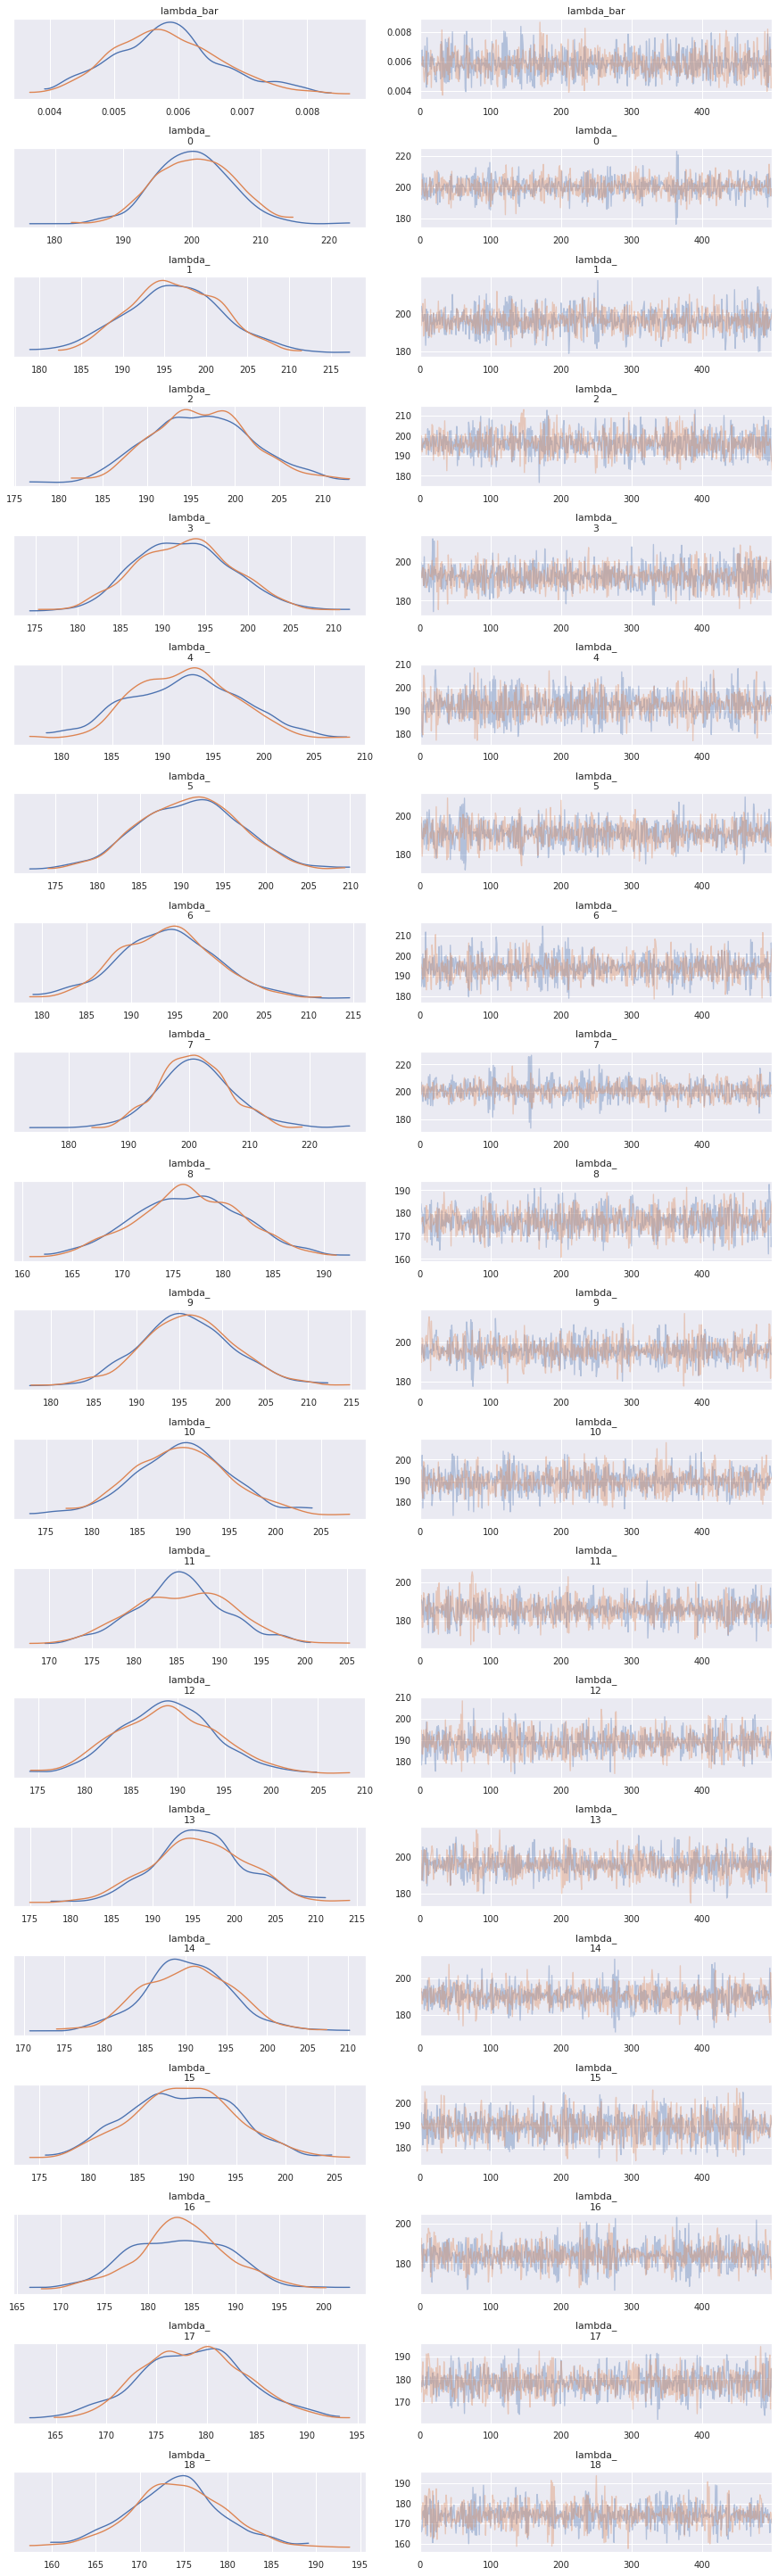

In [54]:
# partial pooling with shrinkage 

model2 = pm.Model()

week_idx = data['week_idx'].values

with model2:

    lambda_bar = pm.Exponential('lambda_bar',1 / data['dead_per_m'].mean())
    lambda_ = pm.Exponential('lambda_',lambda_bar,shape=len(week_idx_map))
    lkh = pm.Poisson('lkh',lambda_[week_idx],observed=data['dead_per_m'])
    
    trace2 = pm.sample(500,tune=500)
    
    result2 = pm.trace_to_dataframe(trace2)
    summary2 = az.summary(trace2)
    az.plot_trace(trace2)

In [55]:
print (summary2)

                mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
lambda_bar     0.006  0.001    0.004    0.007      0.000    0.000    3000.0   
lambda_[0]   200.150  5.670  190.411  211.330      0.122    0.086    2166.0   
lambda_[1]   196.166  5.770  186.191  207.716      0.121    0.086    2272.0   
lambda_[2]   196.197  5.738  186.135  207.538      0.106    0.080    2957.0   
lambda_[3]   192.497  5.799  181.620  202.544      0.107    0.076    2940.0   
lambda_[4]   192.257  5.540  182.155  202.929      0.118    0.083    2212.0   
lambda_[5]   190.899  5.943  180.571  202.141      0.127    0.090    2173.0   
lambda_[6]   194.084  5.536  182.728  203.539      0.101    0.071    3000.0   
lambda_[7]   200.805  6.077  189.715  211.622      0.125    0.090    2366.0   
lambda_[8]   176.564  5.314  166.609  186.222      0.132    0.094    1631.0   
lambda_[9]   195.906  5.516  185.873  206.718      0.133    0.094    1727.0   
lambda_[10]  189.813  5.281  180.151  200.073      0

In [56]:
result2.describe()

lambda_bar   lambda___0   lambda___1   lambda___2   lambda___3  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.005830   200.149631   196.166017   196.196598   192.497128   
std       0.000847     5.669705     5.770450     5.737837     5.798902   
min       0.003690   176.316548   178.822514   176.678418   174.342120   
25%       0.005229   196.318459   192.348960   192.279540   188.348063   
50%       0.005785   200.141239   195.999300   196.106305   192.475614   
75%       0.006330   203.947571   200.142453   200.000225   196.174408   
max       0.008662   223.073022   217.290536   213.018848   211.921192   

        lambda___4   lambda___5   lambda___6   lambda___7   lambda___8  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean    192.257247   190.898508   194.083637   200.804836   176.564168  ...   
std       5.540016     5.942551     5.535871     6.077448     5.314157  ...   
min     176.833479   171.937387   178.575613   173.498637   160.734750  ...   
25%     188.240066   186.691927   190.224106   196.959753   172.934769  ...   
50%     192.275809   190.987516   194.110404   200.632427   176.463368  ...   
75%     196.017754   194.934518   197.607922   204.617596   180.232618  ...   
max     208.508970   209.941838   214.628883   226.663094   192.547612  ...   

       lambda___42  lambda___43  lambda___44  lambda___45  lambda___46  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    168.610059   171.046972   170.592858   175.379971   175.680286   
std       5.283260     5.755561     5.412744     5.341803     5.505598   
min     152.913478   152.338249   151.625915   158.893836   159.105720   
25%     165.137204   167.436831   166.861989   172.012326   172.063921   
50%     168.748007   171.026009   170.689427   175.307682   175.528929   
75%     172.173931   174.777082   174.008647   178.983613   179.207911   
max     183.962263   190.233734   195.758243   193.615582   195.807726   

       lambda___47  lambda___48  lambda___49  lambda___50  lambda___51  
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  
mean    179.121009   186.412394   185.321804   187.791676   188.976233  
std       5.259912     5.310750     5.294887     5.485050     5.324217  
min     162.043893   169.629676   165.061307   171.249716   172.933735  
25%     175.446162   182.529069   181.622181   184.181068   185.452811  
50%     179.131558   186.430181   185.255659   187.749893   189.002310  
75%     182.535959   190.330704   189.054500   191.101794   192.652562  
max     197.617855   207.484292   201.074229   204.767071   207.228505  

[8 rows x 53 columns]

In [57]:
weekly_means = result2.describe().loc['mean','lambda___0' :]

weekly_means

lambda___0     200.149631
lambda___1     196.166017
lambda___2     196.196598
lambda___3     192.497128
lambda___4     192.257247
lambda___5     190.898508
lambda___6     194.083637
lambda___7     200.804836
lambda___8     176.564168
lambda___9     195.906027
lambda___10    189.812801
lambda___11    185.478456
lambda___12    188.831674
lambda___13    195.714658
lambda___14    190.169714
lambda___15    189.595638
lambda___16    183.813247
lambda___17    178.609602
lambda___18    174.117320
lambda___19    167.547819
lambda___20    161.456198
lambda___21    161.176329
lambda___22    160.627565
lambda___23    156.784075
lambda___24    156.616574
lambda___25    159.317090
lambda___26    162.570960
lambda___27    159.082521
lambda___28    158.955750
lambda___29    159.554866
lambda___30    159.330513
lambda___31    156.391429
lambda___32    155.135392
lambda___33    157.573948
lambda___34    157.340529
lambda___35    160.410650
lambda___36    157.478927
lambda___37    159.091047
lambda___38 

In [58]:
CI = result2.loc[:,'lambda___0':].quantile([0.055,0.945])
CI

lambda___0  lambda___1  lambda___2  lambda___3  lambda___4  lambda___5  \
0.055  191.728862  187.023269  187.348981  183.682525  183.983505  181.732955   
0.945  209.211214  205.684371  205.627779  201.941372  201.016151  200.418553   

       lambda___6  lambda___7  lambda___8  lambda___9  ...  lambda___42  \
0.055  185.167580  191.311224  167.824940  187.290700  ...   159.915017   
0.945  203.184565  210.748849  185.163213  204.730572  ...   176.774445   

       lambda___43  lambda___44  lambda___45  lambda___46  lambda___47  \
0.055   161.717519   162.144711   166.748731   166.969182   171.026400   
0.945   180.030527   178.943716   183.434972   184.402015   187.198739   

       lambda___48  lambda___49  lambda___50  lambda___51  
0.055   178.119696   177.051606   179.187058   180.681881  
0.945   194.719503   193.977675   196.953991   197.392154  

[2 rows x 52 columns]

In [59]:
abs_error = np.abs(weekly_means - CI)
abs_error

lambda___0  lambda___1  lambda___2  lambda___3  lambda___4  lambda___5  \
0.055    8.420769    9.142748    8.847617    8.814603    8.273742    9.165553   
0.945    9.061583    9.518354    9.431181    9.444243    8.758904    9.520045   

       lambda___6  lambda___7  lambda___8  lambda___9  ...  lambda___42  \
0.055    8.916057    9.493613    8.739228    8.615327  ...     8.695042   
0.945    9.100927    9.944013    8.599045    8.824544  ...     8.164387   

       lambda___43  lambda___44  lambda___45  lambda___46  lambda___47  \
0.055     9.329453     8.448147     8.631240     8.711104     8.094609   
0.945     8.983555     8.350858     8.055002     8.721729     8.077730   

       lambda___48  lambda___49  lambda___50  lambda___51  
0.055     8.292698     8.270198     8.604618     8.294352  
0.945     8.307109     8.655871     9.162315     8.415921  

[2 rows x 52 columns]

In [60]:
weekly_deaths_per_m

2015   2015-2018        2016        2017        2018  \
2020-01-07  200.841511  205.020072  191.524085  224.755843  202.958848   
2020-01-14  202.604188  203.390006  197.541635  216.245471  197.168731   
2020-01-21  200.841511  204.198563  204.285441  214.092244  197.575055   
2020-01-28  200.012016  199.511786  205.115448  197.071501  195.848178   
2020-02-04  203.848431  197.167803  200.342908  196.148689  188.331184   
2020-02-11  198.871460  196.681977  198.475393  187.945921  201.435133   
2020-02-18  212.558130  202.156301  184.987781  205.479338  205.599955   
2020-02-25  222.823132  211.136701  194.429109  212.349156  214.945407   
2020-03-03  180.726254  184.576484  187.374051  179.538084  190.667547   
2020-03-10  210.277018  206.187779  196.815379  192.047305  225.611413   
2020-03-17  195.553480  194.774426  181.667753  188.048456  213.828016   
2020-03-24  191.509691  191.092142  190.797829  176.359511  205.701536   
2020-03-31  205.196361  189.868267  180.422743  178.615273  195.238692   
2020-04-07  187.258528  190.661312  184.676528  188.868733  201.841457   
2020-04-14  190.058074  181.893845  177.413968  174.616423  185.486916   
2020-04-21  191.613378  180.103178  182.082757  176.974719  169.741860   
2020-04-28  177.511960  177.288220  178.762729  184.152141  168.726050   
2020-05-05  172.223929  172.248562  170.566412  176.462046  169.741860   
2020-05-12  170.875999  167.223045  163.096350  175.539235  159.380597   
2020-05-19  173.675545  164.858427  163.615104  167.028863  155.114195   
2020-05-26  170.875999  159.976177  156.041291  165.593378  147.394039   
2020-06-02  169.839130  160.992880  162.577595  164.465498  147.089296   
2020-06-09  165.587968  160.323639  155.003783  165.080705  155.622100   
2020-06-16  166.935897  157.359647  157.908807  158.723560  145.870323   
2020-06-23  164.758472  157.110975  157.908807  154.827246  150.949374   
2020-06-30  156.256147  160.477305  162.785097  157.595680  165.272295   
2020-07-07  176.993526  166.302214  160.087575  166.106051  162.021703   
2020-07-14  162.269987  161.751337  168.387644  155.544988  160.802731   
2020-07-21  157.085642  163.304598  163.407602  158.005818  174.719329   
2020-07-28  162.062613  163.343421  174.093941  150.725862  166.491268   
2020-08-04  161.129431  164.056282  163.303851  155.955126  175.836720   
2020-08-11  159.055693  156.693540  159.361319  159.236233  149.120916   
2020-08-18  156.152460  157.699952  167.246384  154.724711  152.676251   
2020-08-25  163.203169  159.654419  161.332585  163.132548  150.949374   
2020-09-01  153.145540  159.295410  168.906398  155.647522  159.482178   
2020-09-08  168.802261  167.046546  171.188917  162.414806  165.780201   
2020-09-15  162.269987  159.245098  156.352544  164.157894  154.199966   
2020-09-22  163.514230  162.893095  158.842565  162.927479  166.288106   
2020-09-29  169.839130  162.970476  165.378869  156.775403  159.888502   
2020-10-06  165.691655  165.030438  164.133858  169.899832  160.396407   
2020-10-13  162.477361  169.334191  166.623879  176.462046  171.773480   
2020-10-20  165.069533  168.905823  182.601511  169.079555  158.872692   
2020-10-27  174.608727  170.414184  171.085166  167.541536  168.421307   
2020-11-03  173.468171  174.567254  176.376460  174.924027  173.500357   
2020-11-10  174.919788  171.819409  176.168958  170.002366  166.186525   
2020-11-17  174.193980  172.813108  183.431518  178.512738  155.114195   
2020-11-24  175.541909  172.109966  180.422743  174.821492  157.653720   
2020-12-01  175.127162  177.319698  180.941497  176.154442  177.055692   
2020-12-08  187.880650  184.327316  185.195283  181.793845  182.439485   
2020-12-15  173.571858  181.454976  192.354092  184.869883  175.024072   
2020-12-22  183.422113  181.953931  189.034064  177.897530  177.462016   
2020-12-29  185.910599  190.963388  201.484167  196.558828  179.899960   

                  2019        2020     excess  cum_excess   abs_excess  \
2020-01-07  197.91122

In [61]:
abs_excess = weekly_deaths['2020'] - weekly_deaths['2015-2018']
abs_excess_cum  = abs_excess.cumsum()
abs_excess_cum = abs_excess_cum / (pop['2020'] / 1e6)
abs_excess_cum

2020-01-07     -9.955206
2020-01-14    -19.875273
2020-01-21    -37.927101
2020-01-28    -51.041976
2020-02-04    -62.058141
2020-02-11    -74.669615
2020-02-18    -87.583153
2020-02-25   -113.995949
2020-03-03   -117.294432
2020-03-10   -133.346910
2020-03-17   -143.233584
2020-03-24   -139.477586
2020-03-31   -112.277186
2020-04-07    -52.036970
2020-04-14     28.069323
2020-04-21     99.736283
2020-04-28    154.338962
2020-05-05    211.865710
2020-05-12    265.101972
2020-05-19    299.669585
2020-05-26    327.403654
2020-06-02    344.025073
2020-06-09    359.724341
2020-06-16    379.235194
2020-06-23    390.801539
2020-06-30    400.624113
2020-07-07    397.871561
2020-07-14    395.588306
2020-07-21    391.711175
2020-07-28    388.485359
2020-08-04    383.005999
2020-08-11    389.481757
2020-08-18    391.799713
2020-08-25    391.556697
2020-09-01    382.947294
2020-09-08    375.075802
2020-09-15    374.300863
2020-09-22    369.477539
2020-09-29    367.842565
2020-10-06    364.282649


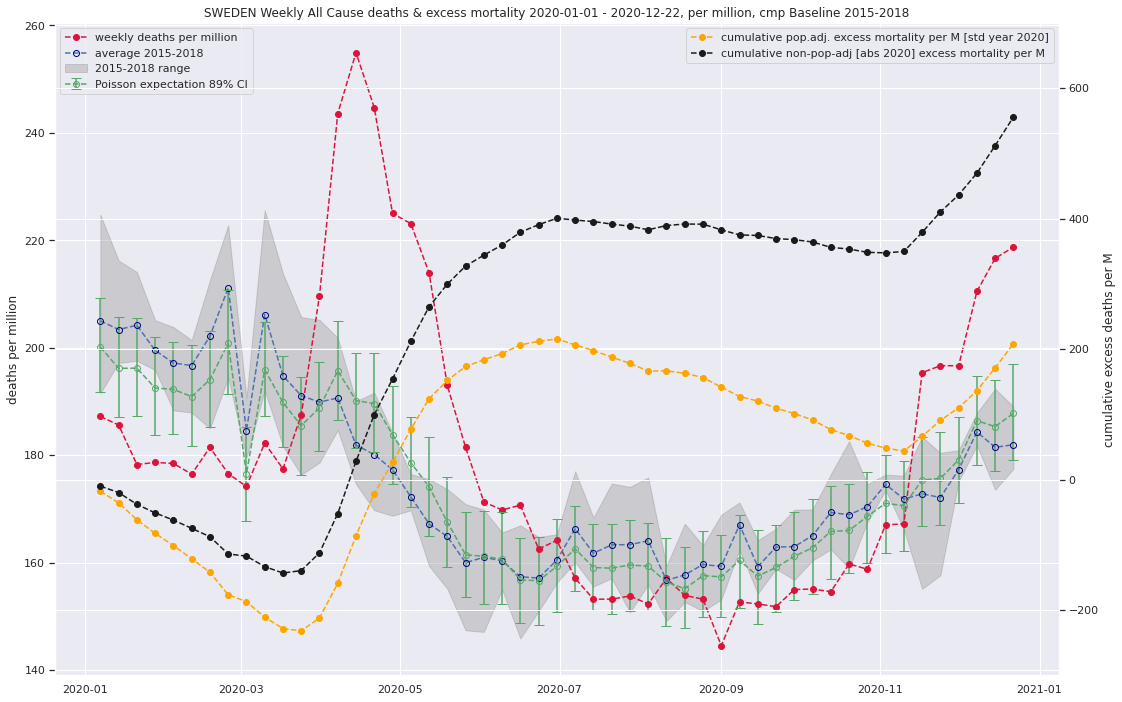

In [62]:
plt.figure(figsize=(18,12))

ax = plt.gca()

ax2 = plt.twinx()

ax.plot(weekly_deaths_per_m.index[:-1],weekly_deaths_per_m['2020'][:-1],'o--',
         color='crimson',label='weekly deaths per million')


ax.plot(weekly_deaths_per_m.index[:-1],weekly_deaths_per_m['2015-2018'][:-1],'o--',
         markerfacecolor='none',markeredgecolor='navy',label='average 2015-2018')

ax.fill_between(weekly_deaths_per_m.index[:-1],weekly_deaths_per_m['min'][:-1],weekly_deaths_per_m['max'][:-1],
                color='grey',alpha=0.3,label='2015-2018 range')

ax.errorbar(weekly_deaths_per_m.index[:-1],weekly_means[:-1],yerr=abs_error.values[:,:-1],
            fmt='o--',capsize=5,mec='g',mfc='none',color='g',label='Poisson expectation 89% CI')


ax.legend(loc='upper left')

ax2.plot(weekly_deaths_per_m.index[:-1],weekly_deaths_per_m['cum_excess'][:-1],'o--',color='orange',
        label='cumulative pop.adj. excess mortality per M [std year 2020]')

ax2.plot(weekly_deaths_per_m.index[:-1],abs_excess_cum[:-1],'o--',color='k',
        label='cumulative non-pop-adj [abs 2020] excess mortality per M')

last_plot_date = weekly_deaths_per_m.index[-2].date()

plt.title('SWEDEN Weekly All Cause deaths & excess mortality 2020-01-01 - {}, per million, cmp Baseline 2015-2018'.format(
    last_plot_date))

ax.set_ylabel('deaths per million')
ax2.set_ylabel('cumulative excess deaths per M')

ax2.legend(loc='upper right')
ax2.set_ylim([-300,700])

plt.savefig('scb_poisson_per_m.jpg',format='jpg')

In [63]:
last_plot_date

datetime.date(2020, 12, 22)

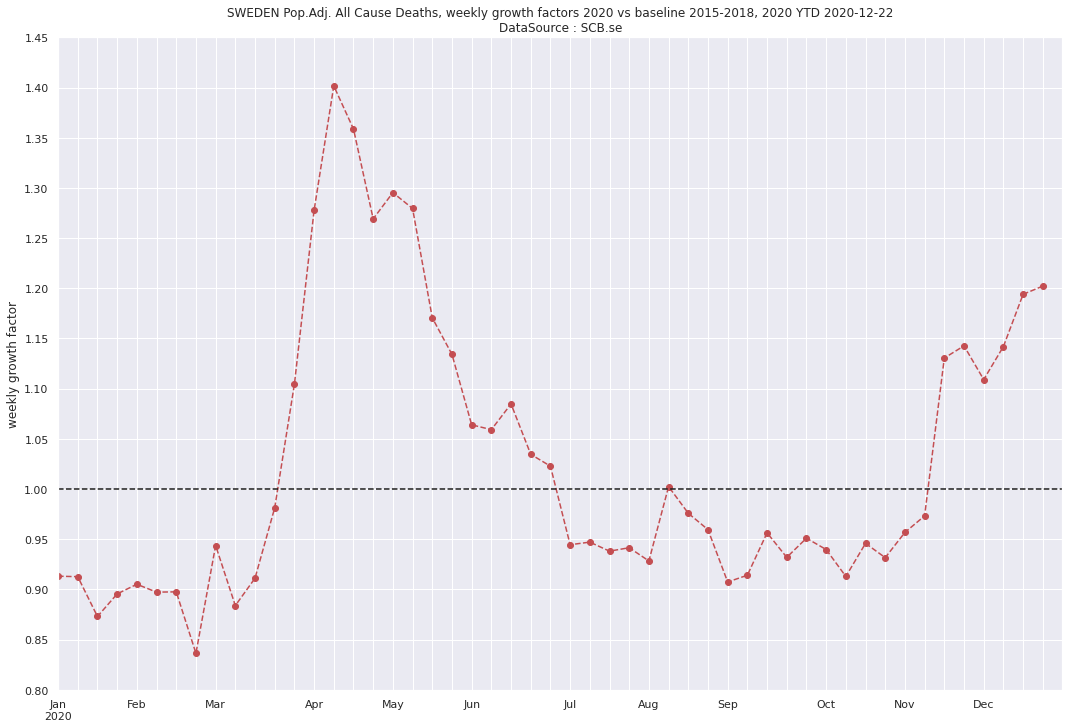

In [64]:
title = 'SWEDEN Pop.Adj. All Cause Deaths, weekly growth factors 2020 vs baseline 2015-2018, 2020 YTD {}\nDataSource : SCB.se'.format(
    last_plot_date)

pct_excess = weekly_deaths_per_m['2020'] / weekly_deaths_per_m['2015-2018']

ax = pct_excess[:-1].plot(style='ro--',figsize=(18,12),title=title)
ax.axhline(1,ls='dashed',color='k')
plt.yticks(np.arange(0.8,1.5,0.05))
plt.xticks(pd.date_range('2020-01-01','2020-12-31',freq='W'))
plt.ylabel('weekly growth factor')
pct_excess
plt.savefig('scb_excess_growth_factor.jpg',format='jpg')

2020-01-07    0.913116
2020-01-14    0.912863
2020-01-21    0.899558
2020-01-28    0.898548
2020-02-04    0.899825
2020-02-11    0.899398
2020-02-18    0.899127
2020-02-25    0.890929
2020-03-03    0.896324
2020-03-10    0.895041
2020-03-17    0.896460
2020-03-24    0.903221
2020-03-31    0.917992
2020-04-07    0.942694
2020-04-14    0.970912
2020-04-21    0.993164
2020-04-28    1.007921
2020-05-05    1.022114
2020-05-12    1.033890
2020-05-19    1.039788
2020-05-26    1.043581
2020-06-02    1.044374
2020-06-09    1.044923
2020-06-16    1.046328
2020-06-23    1.045927
2020-06-30    1.045149
2020-07-07    1.041761
2020-07-14    1.038760
2020-07-21    1.035638
2020-07-28    1.032806
2020-08-04    1.029741
2020-08-11    1.028996
2020-08-18    1.027576
2020-08-25    1.025785
2020-09-01    1.022756
2020-09-08    1.019917
2020-09-15    1.018372
2020-09-22    1.016274
2020-09-29    1.014727
2020-10-06    1.012970
2020-10-13    1.010620
2020-10-20    1.009138
2020-10-27    1.007389
2020-11-03 

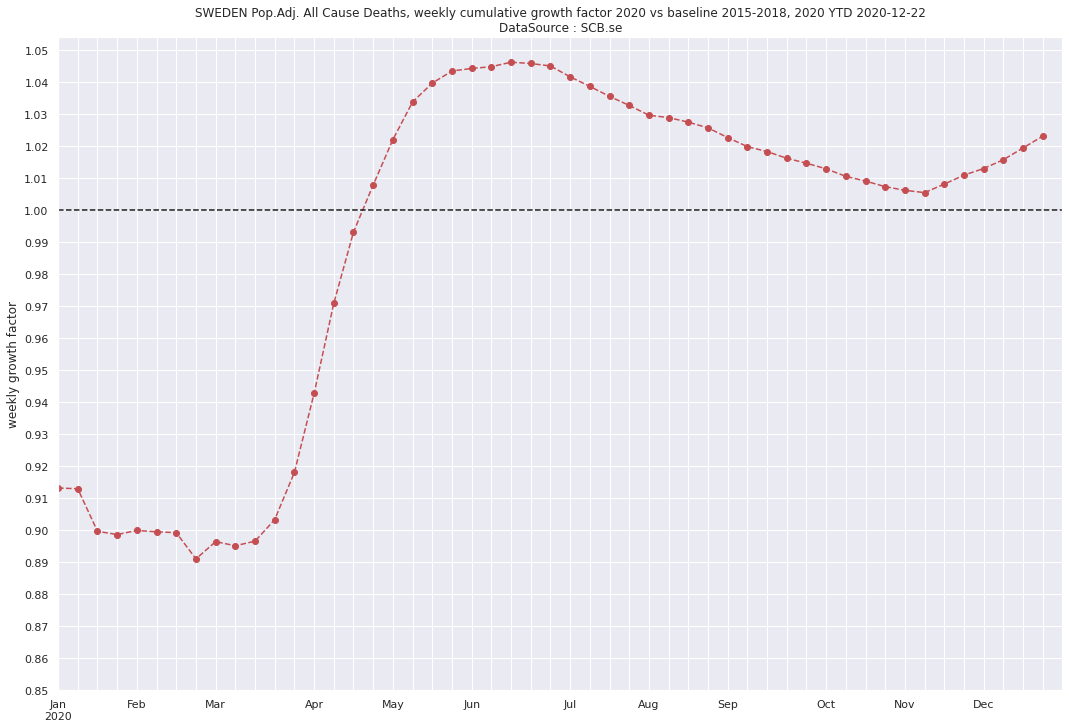

In [65]:
cum_pct_excess = weekly_deaths_per_m['2020'].cumsum() / weekly_deaths_per_m['2015-2018'].cumsum()

title = 'SWEDEN Pop.Adj. All Cause Deaths, weekly cumulative growth factor 2020 vs baseline 2015-2018, 2020 YTD {}\nDataSource : SCB.se'.format(
    last_plot_date)

ax = cum_pct_excess[:-1].plot(style='ro--',figsize=(18,12),title=title)
ax.axhline(1,ls='dashed',color='k')
plt.yticks(np.arange(0.85,1.05,0.01))
plt.xticks(pd.date_range('2020-01-01','2020-12-31',freq='W'))
plt.ylabel('weekly growth factor')
pct_excess
plt.savefig('scb_cum_excess_growth_factor.jpg',format='jpg')
cum_pct_excess

2020-01-07    0.949508
2020-01-14    0.949267
2020-01-21    0.908043
2020-01-28    0.931610
2020-02-04    0.941858
2020-02-11    0.933299
2020-02-18    0.933556
2020-02-25    0.869873
2020-03-03    0.981414
2020-03-10    0.919044
2020-03-17    0.947228
2020-03-24    1.020441
2020-03-31    1.149054
2020-04-07    1.328521
2020-04-14    1.458165
2020-04-21    1.414176
2020-04-28    1.320431
2020-05-05    1.347405
2020-05-12    1.331218
2020-05-19    1.218218
2020-05-26    1.180439
2020-06-02    1.107464
2020-06-09    1.101877
2020-06-16    1.129054
2020-06-23    1.076613
2020-06-30    1.063656
2020-07-07    0.982777
2020-07-14    0.985314
2020-07-21    0.975315
2020-07-28    0.979455
2020-08-04    0.965270
2020-08-11    1.043002
2020-08-18    1.015293
2020-08-25    0.998416
2020-09-01    0.943782
2020-09-08    0.950975
2020-09-15    0.994937
2020-09-22    0.969203
2020-09-29    0.989560
2020-10-06    0.977559
2020-10-13    0.949231
2020-10-20    0.984167
2020-10-27    0.969251
2020-11-03 

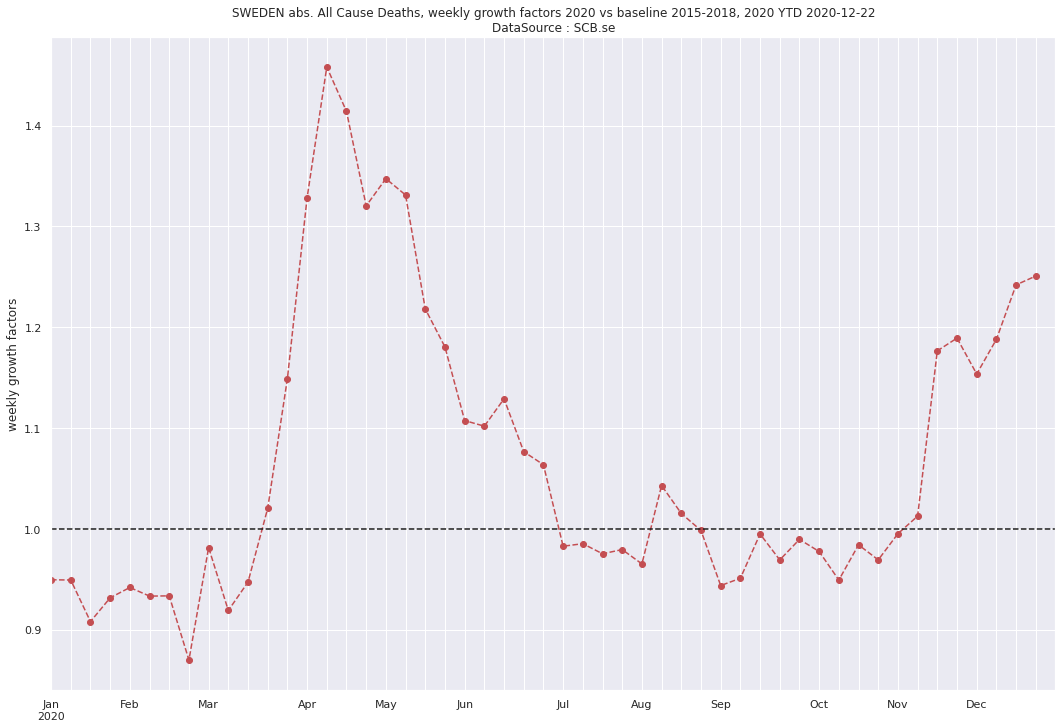

In [66]:
abs_15_18_avg = scb_weekly.loc[:,'2015':'2018'].mean(axis=1)
title = 'SWEDEN abs. All Cause Deaths, weekly growth factors 2020 vs baseline 2015-2018, 2020 YTD {}\nDataSource : SCB.se'.format(
    last_plot_date)

abs_weekly_growth = scb_weekly['2020'] / abs_15_18_avg
ax = abs_weekly_growth.loc[:last_plot_date].plot(style='ro--',figsize=(18,12),title=title)
ax.axhline(1,ls='dashed',color='k')
#plt.yticks(np.arange(0.8,1.5,0.05))
plt.xticks(pd.date_range('2020-01-01','2020-12-31',freq='W'))
plt.ylabel('weekly growth factors')
pct_excess
plt.savefig('scb_excess__abs_weekly_growth_factors.jpg',format='jpg')


abs_weekly_growth

2020-01-07    0.949508
2020-01-14    0.949388
2020-01-21    0.935608
2020-01-28    0.934626
2020-02-04    0.936038
2020-02-11    0.935592
2020-02-18    0.935299
2020-02-25    0.926768
2020-03-03    0.932361
2020-03-10    0.930994
2020-03-17    0.932429
2020-03-24    0.939450
2020-03-31    0.954836
2020-04-07    0.980506
2020-04-14    1.009869
2020-04-21    1.033056
2020-04-28    1.048418
2020-05-05    1.063183
2020-05-12    1.075443
2020-05-19    1.081601
2020-05-26    1.085572
2020-06-02    1.086422
2020-06-09    1.086998
2020-06-16    1.088482
2020-06-23    1.088078
2020-06-30    1.087257
2020-07-07    1.083743
2020-07-14    1.080624
2020-07-21    1.077357
2020-07-28    1.074413
2020-08-04    1.071211
2020-08-11    1.070443
2020-08-18    1.068972
2020-08-25    1.067116
2020-09-01    1.063961
2020-09-08    1.061010
2020-09-15    1.059405
2020-09-22    1.057218
2020-09-29    1.055616
2020-10-06    1.053787
2020-10-13    1.051332
2020-10-20    1.049796
2020-10-27    1.047979
2020-11-03 

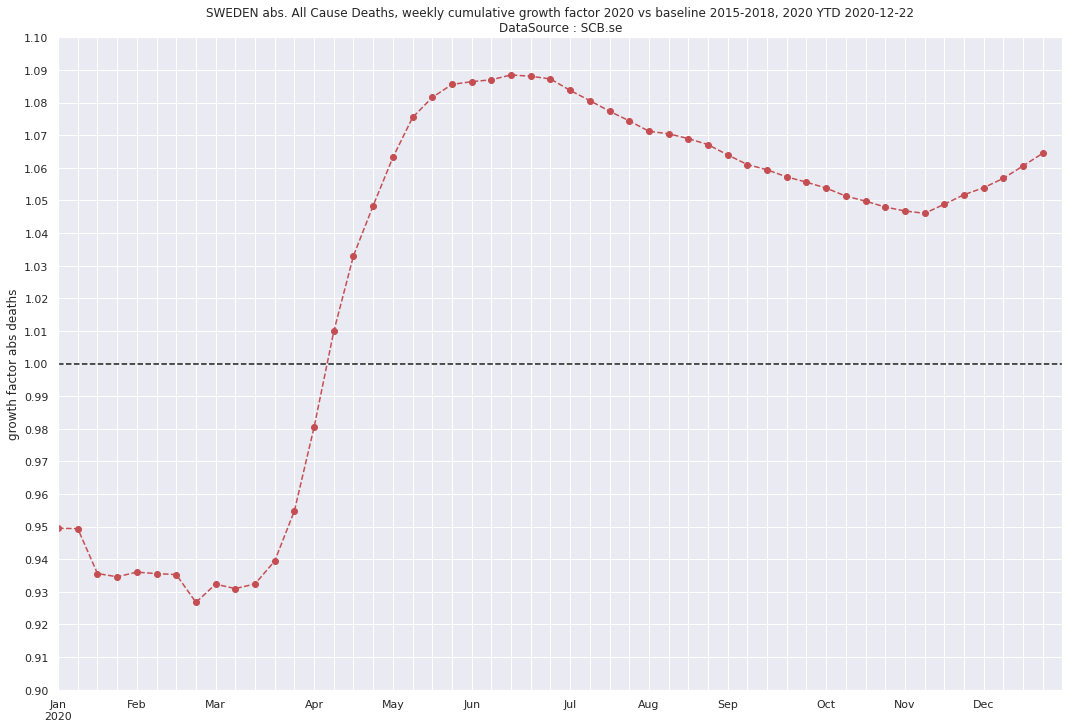

In [67]:
title = 'SWEDEN abs. All Cause Deaths, weekly cumulative growth factor 2020 vs baseline 2015-2018, 2020 YTD {}\nDataSource : SCB.se'.format(
    last_plot_date)


abs_cum_growth = scb_weekly['2020'].cumsum() / abs_15_18_avg.cumsum()
abs_cum_growth = abs_cum_growth.loc[:last_plot_date]

abs_cum_growth.plot(figsize=(18,12),style='ro--',title=title)
plt.axhline(1,ls='dashed',color='k')
plt.xticks(pd.date_range('2020-01-01','2020-12-31',freq='W'))
plt.yticks(np.arange(0.9,1.1,0.01))
plt.ylabel('growth factor abs deaths')
plt.savefig('scb_abs_cum_excess_growth_factor.jpg',format='jpg')

abs_cum_growth

In [68]:
post_samples2 = pm.sample_posterior_predictive(trace2,100,model2)
post_samples2

/usr/local/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


{'lkh': array([[186, 204, 196, ..., 205, 175, 191],
        [191, 209, 194, ..., 177, 170, 174],
        [204, 214, 192, ..., 203, 192, 185],
        ...,
        [240, 201, 188, ..., 175, 172, 213],
        [181, 186, 198, ..., 183, 203, 180],
        [227, 208, 188, ..., 196, 168, 175]])}

In [69]:
data_ppc2 = az.from_pymc3(trace=trace2,model=model2,posterior_predictive=post_samples2)
data_ppc2

arviz.data.io_pymc3 - WARNING - posterior predictive variable lkh's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

array([<AxesSubplot:xlabel='lkh'>], dtype=object)

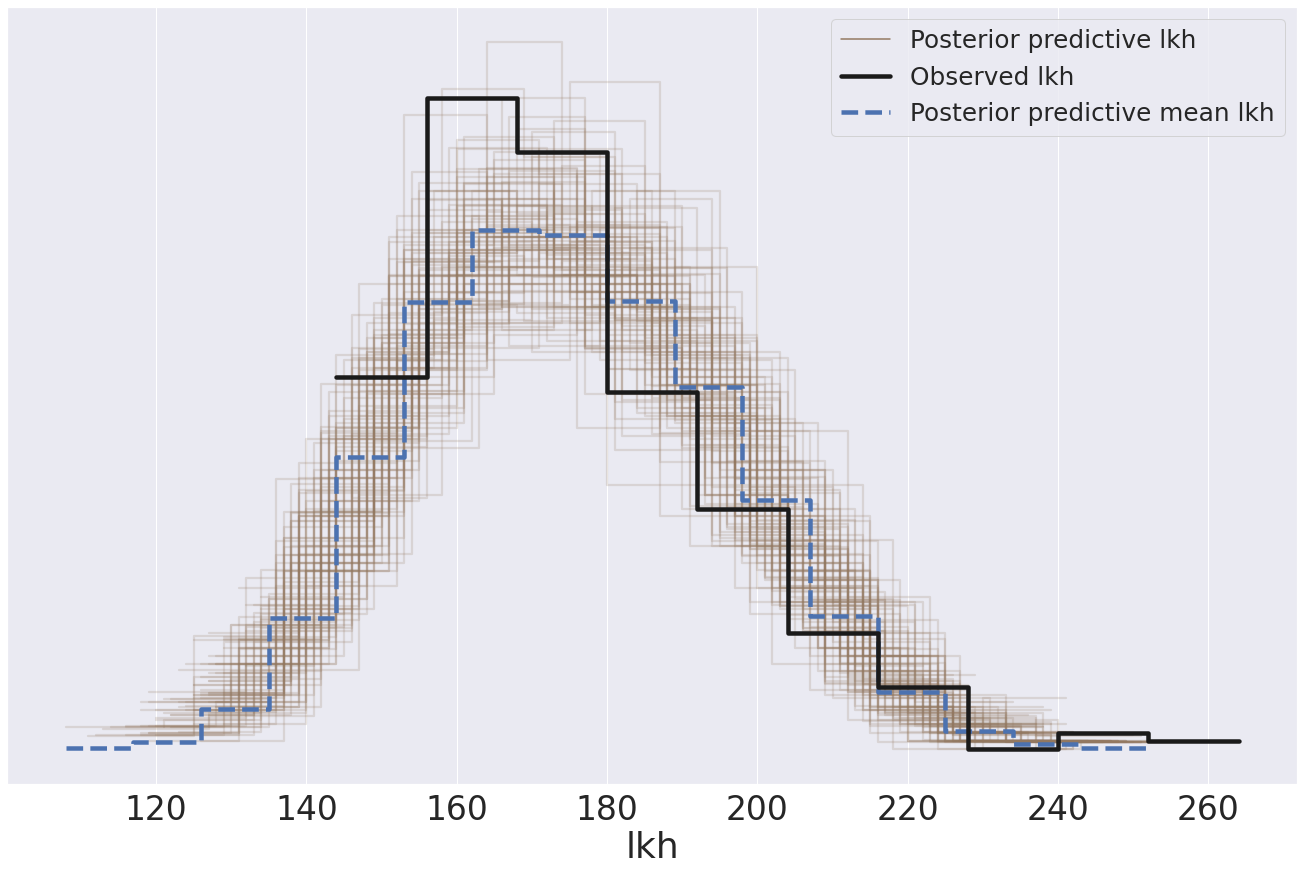

In [70]:
az.plot_ppc(data_ppc2,figsize=(18,12))

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

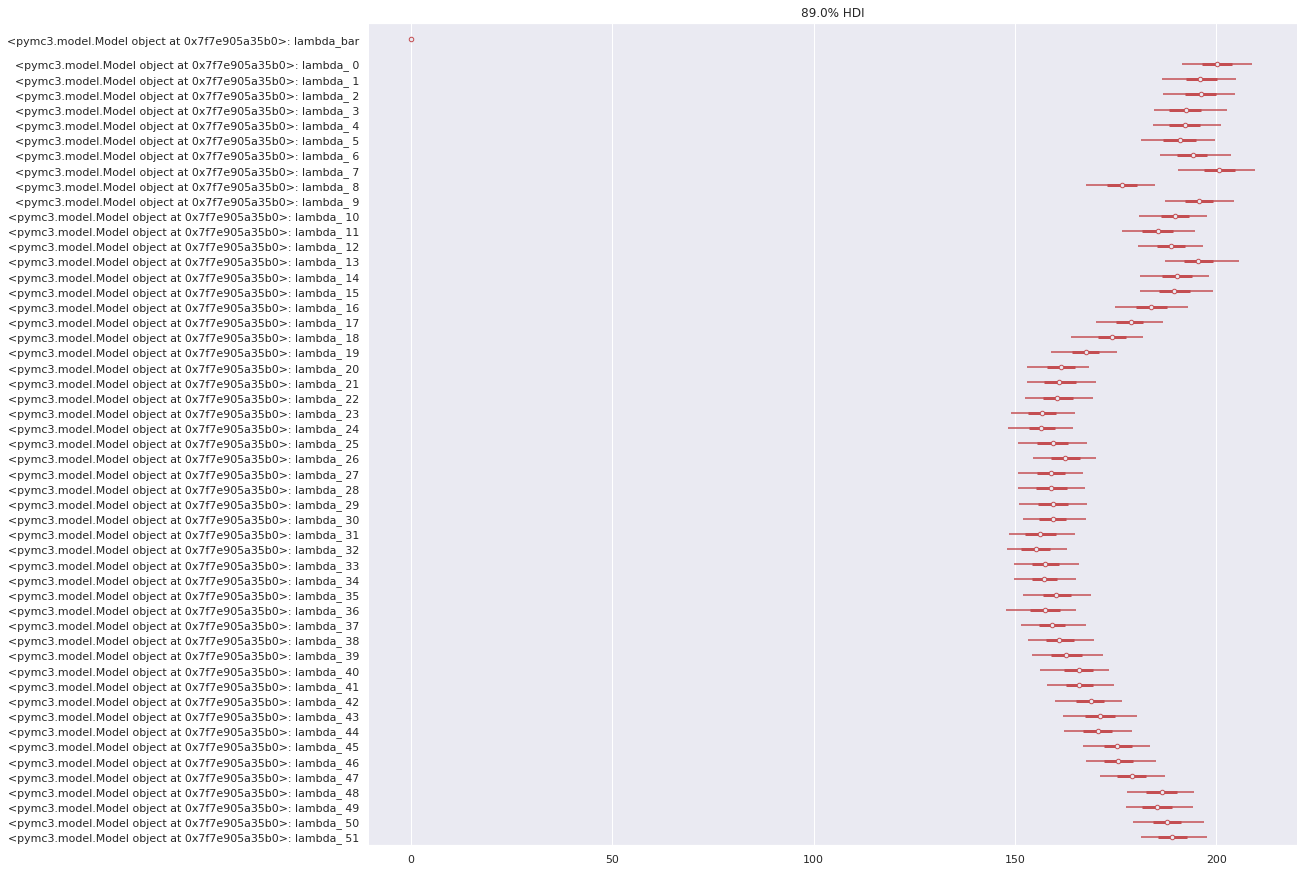

In [71]:
az.plot_forest(trace2,model_names=[model2],figsize=(18,12),combined=True,colors='r',hdi_prob=0.89)


In [72]:
pop

year
2015     9747355.0
2016     9851017.0
2017     9995153.0
2018    10120242.0
2019    10230185.0
2020    10327589.0
Name: population, dtype: float64

In [73]:
data['pop'] = data['year'].apply(lambda x : pop[x])
data

year       week  dead_per_m  week_idx  year_idx         pop
0    2015 2020-01-07  200.841511         0         0   9747355.0
1    2015 2020-01-14  202.604188         1         0   9747355.0
2    2015 2020-01-21  200.841511         2         0   9747355.0
3    2015 2020-01-28  200.012016         3         0   9747355.0
4    2015 2020-02-04  203.848431         4         0   9747355.0
..    ...        ...         ...       ...       ...         ...
307  2020 2020-12-01  196.656908        47         5  10327589.0
308  2020 2020-12-08  210.483570        48         5  10327589.0
309  2020 2020-12-15  216.650858        49         5  10327589.0
310  2020 2020-12-22  218.739778        50         5  10327589.0
311  2020 2020-12-29  201.332110        51         5  10327589.0

[312 rows x 6 columns]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [g, b, a]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 166 seconds.
/usr/local/lib/python3.8/site-packages/arviz/plots/traceplot.py:250: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (625), generating only 20 plots
  warnings.warn(


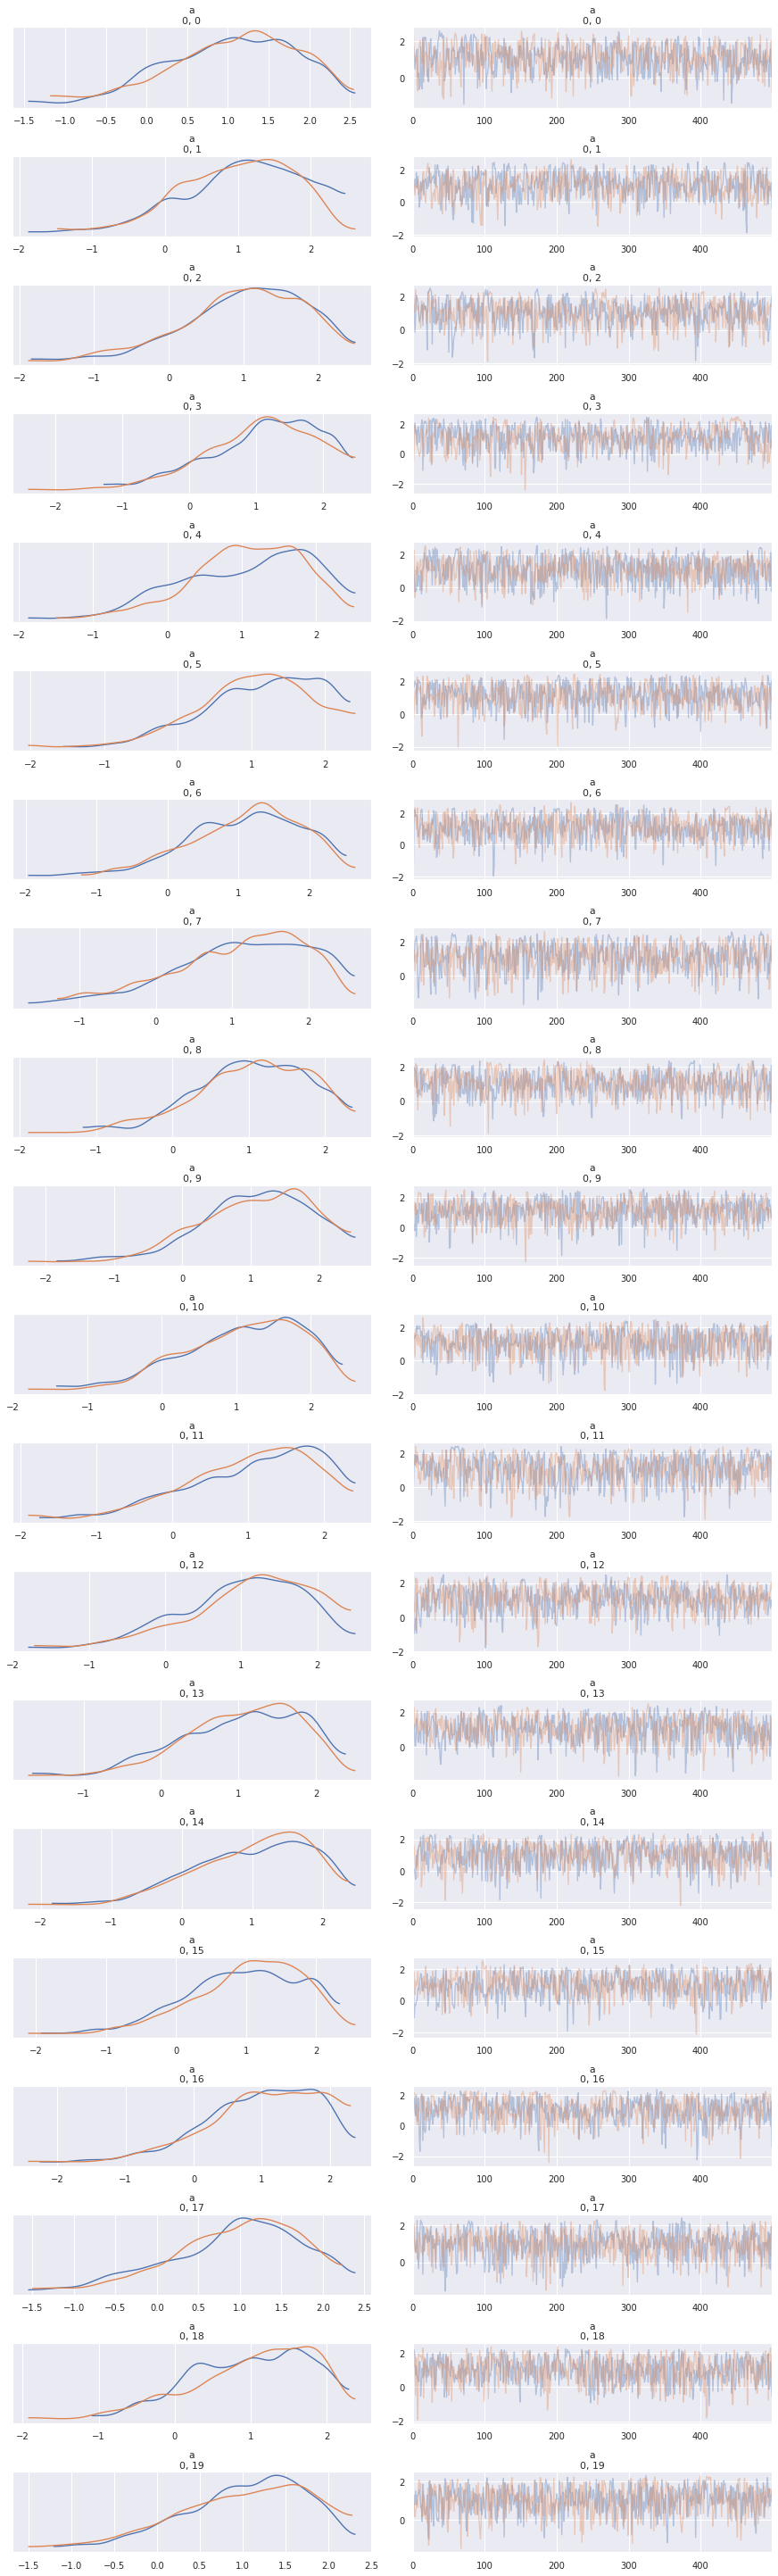

In [74]:
# Scientific, dynamic model, not a GLM, partial pooling with shrinkage

# Delta D = alpha * Pop^beta - gamma

# alpha = deaths per individual
# beta = Elasticity (diminishing returns)
# gamma = death loss (e.g. better health care)

# D ~ Poisson(lambda)
# lambda = exp(a[year_idx,week_idx]) * P^b[year_idx,week_idx] / g
# a = pm.Normal('a',1,1,shape=len(unique_weeks))
# b = pm.Exponential('b',1,shape=len(unique_weeks))
# g = pm.Exponential(1)

model3 = pm.Model()

year_idx = data['year_idx'].values

with model3:
    
    a = pm.Normal('a',mu=1,sigma=1,shape=(len(year_idx_map),len(week_idx_map)))
    b = pm.Exponential('b',1,shape=(len(year_idx_map),len(week_idx_map)))
    g = pm.Exponential('g',1)
    
    lambda_ = np.exp(a[year_idx,week_idx]) * np.log(data['pop'].values) ** b[year_idx,week_idx] / g
    
    lkh = pm.Poisson('lkh',lambda_,observed=data['dead_per_m'].values.astype(int))
    
    step1 = pm.Metropolis()
    trace3 = pm.sample(500,tune=500,target_accept=0.95)
    
    result3 = pm.trace_to_dataframe(trace3)
    summary3 = az.summary(trace3)
    
    _= az.plot_trace(trace3)
    

In [75]:
def alpha_cols(col):
    if 'a_' in col.name:
        return True
    return False

def beta_cols(col):
    if 'b_' in col.name:
        return True
    return False

def gamma_col(col):
    if col.name == 'g':
        return True
    return False

alpha_mask = result3.apply(alpha_cols)
alphas = result3.loc[:,alpha_mask]

beta_mask = result3.apply(beta_cols)
betas = result3.loc[:,beta_mask]

gamma_mask = result3.apply(gamma_col)
gamma = result3.loc[:,gamma_mask]

gamma

g
0    0.056513
1    0.055350
2    0.055267
3    0.051737
4    0.054028
..        ...
995  0.053431
996  0.053148
997  0.060878
998  0.047867
999  0.054712

[1000 rows x 1 columns]

In [76]:
summary3

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0,0]   1.056  0.771  -0.245    2.398      0.028    0.023     744.0   542.0   
a[0,1]   1.038  0.779  -0.283    2.375      0.030    0.024     675.0   532.0   
a[0,2]   1.013  0.794  -0.451    2.292      0.032    0.026     633.0   452.0   
a[0,3]   1.087  0.809  -0.404    2.387      0.040    0.039     416.0   215.0   
a[0,4]   1.075  0.785  -0.351    2.340      0.028    0.022     794.0   664.0   
...        ...    ...     ...      ...        ...      ...       ...     ...   
b[5,48]  0.452  0.274   0.000    0.919      0.011    0.008     598.0   598.0   
b[5,49]  0.463  0.279   0.003    0.952      0.010    0.007     765.0   765.0   
b[5,50]  0.475  0.294   0.000    0.983      0.014    0.010     454.0   454.0   
b[5,51]  0.470  0.297   0.000    0.982      0.014    0.010     480.0   480.0   
g        0.052  0.005   0.044    0.062      0.000    0.000     618.0   615.0   

         ess_bulk  ess_tail  r_hat  
a[0,0]      682.0     446.0   1.00  
a[0,1]      633.0     472.0   1.00  
a[0,2]      572.0     383.0   1.01  
a[0,3]      302.0     247.0   1.01  
a[0,4]      758.0     597.0   1.02  
...           ...       ...    ...  
b[5,48]     462.0     399.0   1.00  
b[5,49]     667.0     380.0   1.00  
b[5,50]     413.0     372.0   1.01  
b[5,51]     374.0     229.0   1.00  
g           605.0     615.0   1.00  

[625 rows x 11 columns]

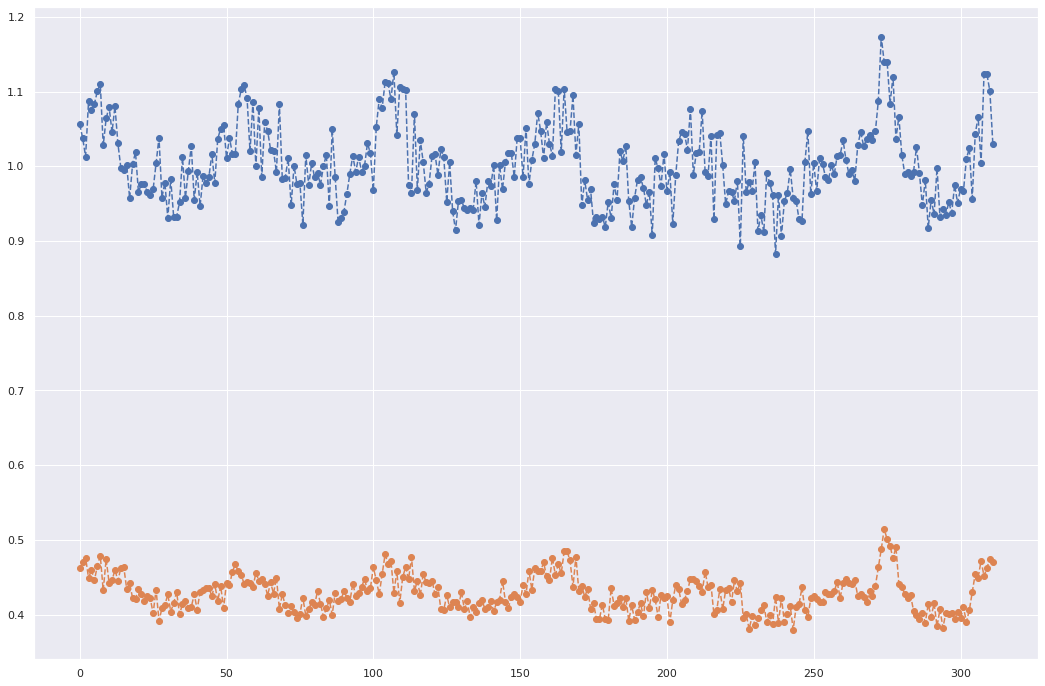

In [77]:
plt.figure(figsize=(18,12))

ax = plt.gca()
ax.plot(range(len(alphas.mean())),alphas.mean(),'o--')

ax.plot(range(len(betas.mean())),betas.mean(),'o--')

In [78]:
alphas

a__0_0    a__0_1    a__0_2    a__0_3    a__0_4    a__0_5    a__0_6  \
0    0.574835  1.343163  0.580877  1.152826  2.340088  1.759733  2.337058   
1    1.704978  0.524414  2.082813  0.711420  1.278244  1.572848 -1.146053   
2    1.003491  1.135436  1.083639  2.005490  0.582382  1.627829  2.057844   
3    0.455515  1.395296 -0.140074  2.051021 -0.248407  1.994882  2.192831   
4    0.983304  0.967111  0.902041  1.400288 -0.219532  1.790125  1.792581   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.828573  1.268765  1.336884 -0.537796  1.603844  1.241391  0.306038   
996  0.840189  1.046524  1.386760 -0.120819  1.539805  1.624130  0.603082   
997  1.636767  0.502901  1.516932  0.088921  1.308240  1.225227  2.171131   
998  2.012248  0.350050  1.421279  0.967890  0.312378  0.964066  1.749254   
999 -0.788982  0.269594  1.346742  0.713173  0.577399  0.717839  0.300323   

       a__0_7    a__0_8    a__0_9  ...   a__5_42   a__5_43   a__5_44  \
0    1.037906  0.895149  1.517353  ...  1.378649 -0.461062  2.033755   
1    0.799658  0.957606  0.286655  ...  0.602177  2.041907 -0.557555   
2    0.975092  1.972236 -0.054549  ...  1.430694  0.837260  1.686093   
3    2.035292  1.863129 -0.204929  ...  1.165410  1.300282  1.005851   
4    2.056065  1.705532  1.521676  ...  1.443645  1.025284  1.149285   
..        ...       ...       ...  ...       ...       ...       ...   
995 -0.777901  0.975274  1.214278  ... -0.881950  1.726252  1.716501   
996 -0.706446  0.853464  0.990011  ... -0.297819  1.726806  1.492547   
997  0.994321  0.939755  1.183235  ... -0.005374 -0.327411  2.274643   
998  2.097316 -0.167149  0.562426  ...  1.002895  1.253714  1.987907   
999  0.656717  1.582229  0.772206  ...  1.481251  1.915453  2.022688   

      a__5_45   a__5_46   a__5_47   a__5_48   a__5_49   a__5_50   a__5_51  
0    1.393803  0.803631  2.426654  2.278295  1.197791  2.316774  0.525986  
1    0.482133  0.889867  0.538613 -0.048820  1.145862 -0.367650  1.120871  
2    0.907531  2.145833  0.272525  2.026779  1.492081  1.985719  1.420774  
3    1.055868  1.635431  1.294032  1.779438  0.326597 -0.154131  1.223419  
4    0.747738  1.791954  1.612895  2.232270  0.761108  0.641211  1.748909  
..        ...       ...       ...       ...       ...       ...       ...  
995  1.707051  1.939545  1.074118  1.455432 -0.308629  1.840265  1.608263  
996  1.826709  2.021204  1.309258  1.439520 -0.131195  1.859364  1.875325  
997  0.585795  0.862133  1.175502  2.156246  0.661104  2.041592  2.151176  
998 -0.900233  1.885008  1.160004  1.278576  1.834055 -0.289775  2.115248  
999  1.986657  0.504274  2.260542  2.124613  0.274126  1.397936  0.266883  

[1000 rows x 312 columns]

(1000, 312)

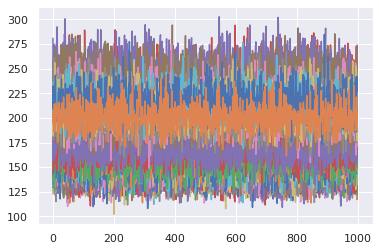

In [79]:
lambdas = np.exp(alphas.values) * np.log(10e6) ** betas.values / gamma.values
plt.plot(range(len(lambdas)),lambdas)

lambdas.shape

In [80]:
samples = pm.Poisson.dist(lambdas.mean(axis=0)).random(size=1000)
samples.shape

(1000, 312)

In [81]:
CI = np.percentile(samples,[5.5,94.5],axis=0)
weekly_mins = data.loc[data['year_idx'].isin([0,1,2,3])].groupby('week_idx').min()['dead_per_m']
weekly_max = data.loc[data['year_idx'].isin([0,1,2,3])].groupby('week_idx').max()['dead_per_m']

weekly_max

week_idx
0     224.755843
1     216.245471
2     214.092244
3     205.115448
4     203.848431
5     201.435133
6     212.558130
7     222.823132
8     190.667547
9     225.611413
10    213.828016
11    205.701536
12    205.196361
13    201.841457
14    190.058074
15    191.613378
16    184.152141
17    176.462046
18    175.539235
19    173.675545
20    170.875999
21    169.839130
22    165.587968
23    166.935897
24    164.758472
25    165.272295
26    176.993526
27    168.387644
28    174.719329
29    174.093941
30    175.836720
31    159.361319
32    167.246384
33    163.203169
34    168.906398
35    171.188917
36    164.157894
37    166.288106
38    169.839130
39    169.899832
40    176.462046
41    182.601511
42    174.608727
43    176.376460
44    176.168958
45    183.431518
46    180.422743
47    180.941497
48    187.880650
49    192.354092
50    189.034064
51    201.484167
Name: dead_per_m, dtype: float64

In [82]:
cols = data['year'].str.cat(data['week_idx'].astype(str),sep='_')

weekly_means = data.loc[data['year_idx'].isin([0,1,2,3])].groupby('week_idx').mean()['dead_per_m']
weekly_means

week_idx
0     205.020072
1     203.390006
2     204.198563
3     199.511786
4     197.167803
5     196.681977
6     202.156301
7     211.136701
8     184.576484
9     206.187779
10    194.774426
11    191.092142
12    189.868267
13    190.661312
14    181.893845
15    180.103178
16    177.288220
17    172.248562
18    167.223045
19    164.858427
20    159.976177
21    160.992880
22    160.323639
23    157.359647
24    157.110975
25    160.477305
26    166.302214
27    161.751337
28    163.304598
29    163.343421
30    164.056282
31    156.693540
32    157.699952
33    159.654419
34    159.295410
35    167.046546
36    159.245098
37    162.893095
38    162.970476
39    165.030438
40    169.334191
41    168.905823
42    170.414184
43    174.567254
44    171.819409
45    172.813108
46    172.109966
47    177.319698
48    184.327316
49    181.454976
50    181.953931
51    190.963388
Name: dead_per_m, dtype: float64

In [83]:
repeated_weekly_means = np.array(list (weekly_means) * 6)
repeat_weekly_means = repeated_weekly_means


data['dead_per_m'] - repeated_weekly_means

0      -4.178561
1      -0.785818
2      -3.357052
3       0.500230
4       6.680628
         ...    
307    19.337210
308    26.156254
309    35.195881
310    36.785847
311    10.368722
Name: dead_per_m, Length: 312, dtype: float64

DatetimeIndex(['2015-01-07', '2015-01-14', '2015-01-21', '2015-01-28',
               '2015-02-04', '2015-02-11', '2015-02-18', '2015-02-25',
               '2015-03-04', '2015-03-11',
               ...
               '2020-07-08', '2020-07-15', '2020-07-22', '2020-07-29',
               '2020-08-05', '2020-08-12', '2020-08-19', '2020-08-26',
               '2020-09-02', '2020-09-09'],
              dtype='datetime64[ns]', length=297, freq='W-WED')

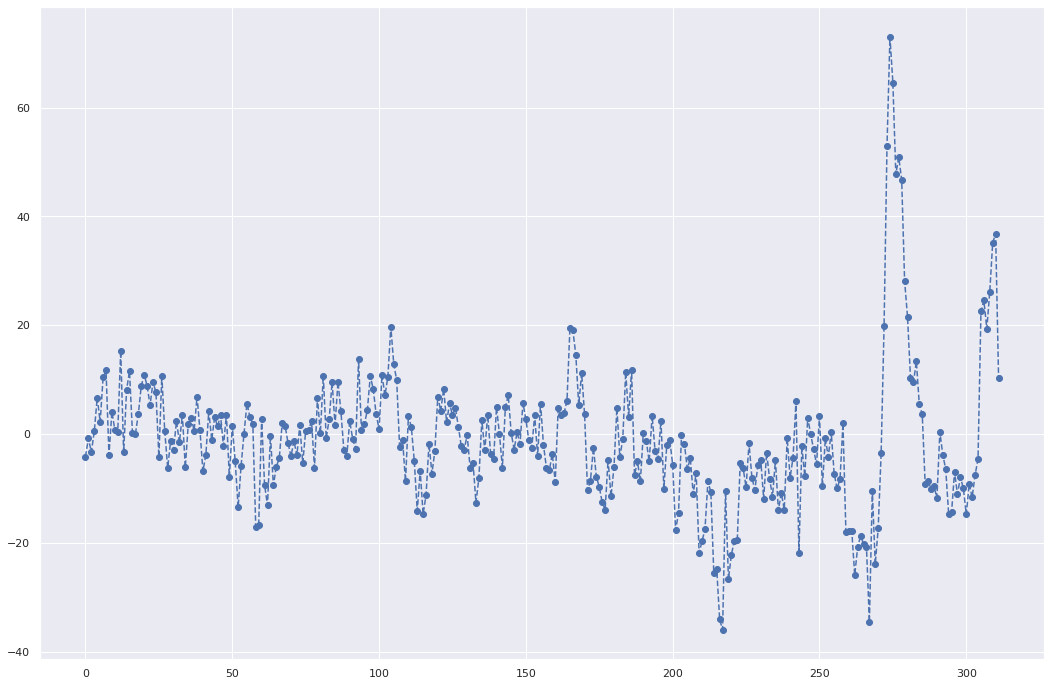

In [84]:
plt.figure(figsize=(18,12))
idx = pd.date_range(start='2015-01-01',end='2020-09-15',freq='W-WED')
plt.plot(data['dead_per_m'] - repeated_weekly_means,'o--')
idx

In [85]:
last_week = data.iloc[-1,1].date() - pd.DateOffset(weeks=1)
month_name = (pd.to_datetime(data.iloc[-1,1]) -pd.DateOffset(weeks=1)).month_name()
day = last_week.day

print (last_week)
print (month_name)
print (day)

2020-12-22 00:00:00
December
22


In [86]:
CI[1]

array([224.   , 224.055, 225.055, 225.   , 226.055, 218.   , 237.   ,
       245.055, 204.   , 233.   , 216.   , 212.   , 228.   , 209.   ,
       212.   , 212.   , 198.   , 193.   , 191.   , 193.   , 191.   ,
       191.   , 185.   , 185.   , 186.   , 175.   , 199.   , 183.   ,
       179.   , 183.   , 182.   , 179.   , 176.   , 182.   , 173.   ,
       190.   , 181.   , 184.   , 190.   , 186.   , 182.   , 186.   ,
       195.   , 193.   , 196.   , 195.055, 197.   , 195.055, 209.   ,
       196.   , 204.   , 208.   , 216.055, 218.   , 228.   , 228.   ,
       222.   , 221.   , 205.   , 216.   , 209.   , 219.   , 202.   ,
       212.   , 202.   , 207.   , 198.   , 205.   , 201.   , 191.   ,
       184.   , 185.   , 178.   , 183.   , 175.   , 177.   , 177.   ,
       182.   , 179.   , 190.   , 182.   , 195.   , 183.   , 180.   ,
       190.   , 181.   , 188.   , 191.055, 177.   , 179.   , 184.   ,
       186.   , 185.   , 204.   , 192.   , 198.   , 197.   , 206.   ,
       203.   , 200.

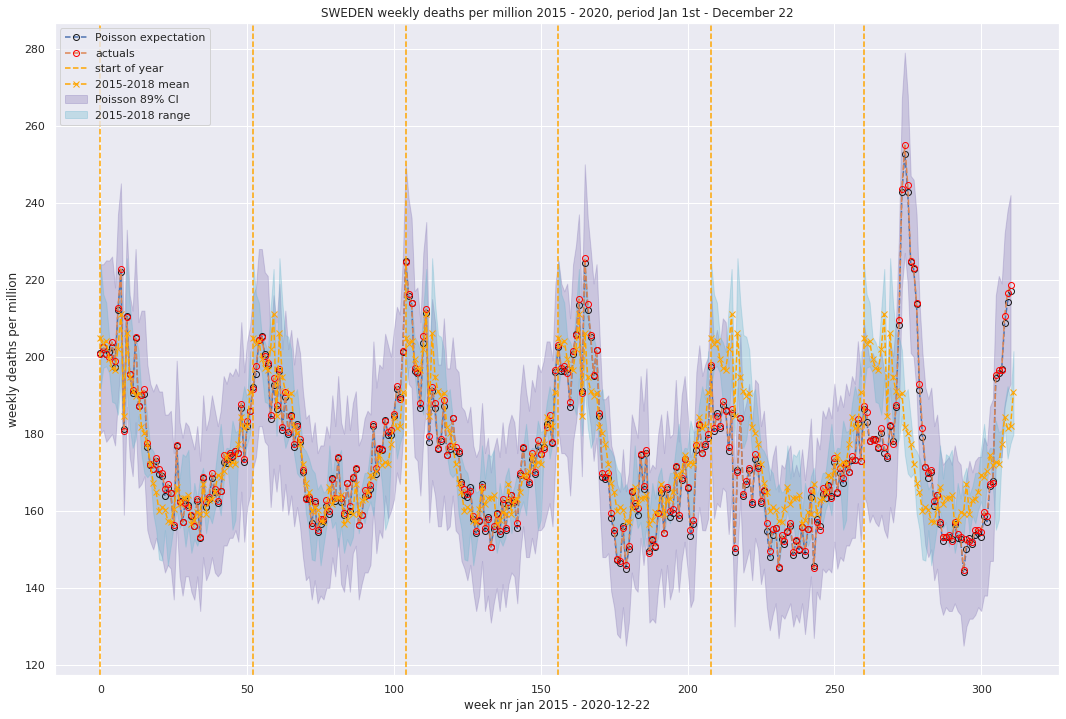

In [87]:
last_week = last_week.date()

plt.figure(figsize=(18,12))

plt.title('SWEDEN weekly deaths per million 2015 - 2020, period Jan 1st - {} {}'.format(month_name,day))

plt.plot(range(len(samples.mean(axis=0)) - 1),samples.mean(axis=0)[:-1],'o--',label='Poisson expectation',
         mec='k',mfc='none')

plt.fill_between(range(len(samples.T) - 1),CI[0][:-1],CI[1][:-1],color='m',alpha=0.3,label='Poisson 89% CI')

plt.plot(range(len(data) - 1),data['dead_per_m'][:-1],'o--',mec='red',mfc='none',label='actuals')


for i in range(len(year_idx_map)):
    
    label = 'start of year' if i == 0 else ''
    label2 = '2015-2018 mean' if i == 0 else ''
    label3 = '2015-2018 range' if i == 0 else ''
    
    plt.axvline(i * len(week_idx_map),ls='--',color='orange',label=label)
    
    plt.plot(range(i*len(week_idx_map),i*len(week_idx_map)+ len(week_idx_map)),weekly_means,'x--',
             color='orange',label=label2)
    
    plt.fill_between(range(i*len(week_idx_map),i*len(week_idx_map) + len(week_idx_map)),
    weekly_mins,weekly_max,alpha=0.3,color='c',label=label3)
    
plt.legend(loc='upper left')

    
plt.ylabel('weekly deaths per million')
plt.xlabel('week nr jan 2015 - {}'.format(last_week))

plt.savefig('scb_weekly_deaths_per_m_2015_2020.jpg',format='jpg',dpi=400)


<AxesSubplot:>

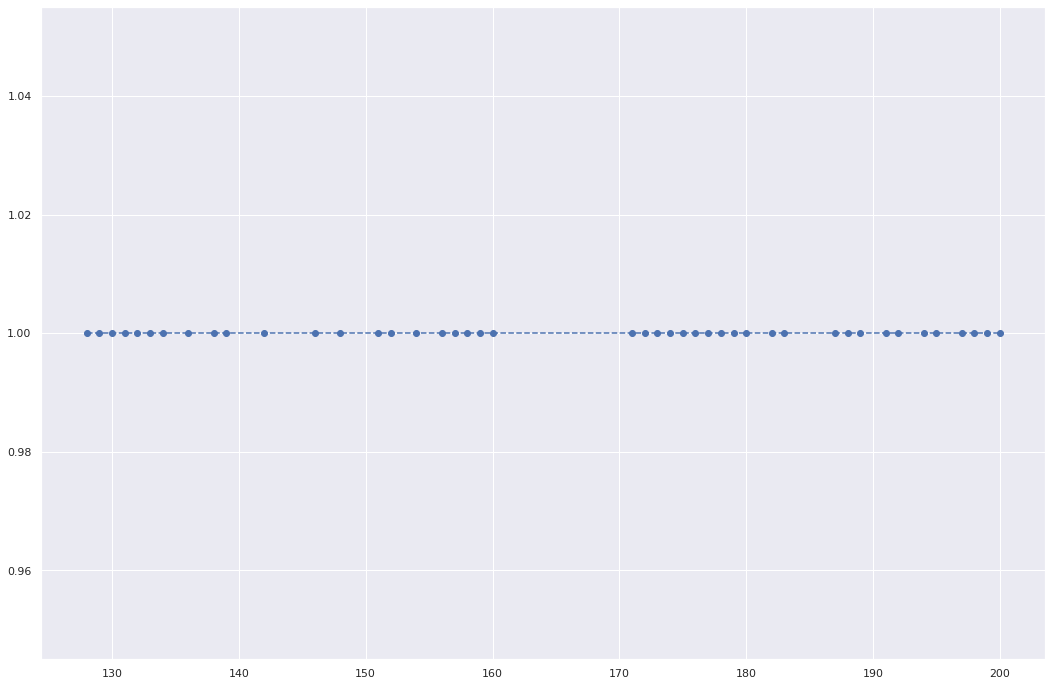

In [88]:
under_mean = ((data['dead_per_m'] - repeat_weekly_means) < 0).astype(int) 
under_mean = under_mean.loc[under_mean==1]
under_mean.loc[125:200].plot(x=under_mean.index,style='o--',figsize=(18,12))

/usr/local/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


arviz.data.io_pymc3 - WARNING - posterior predictive variable lkh's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

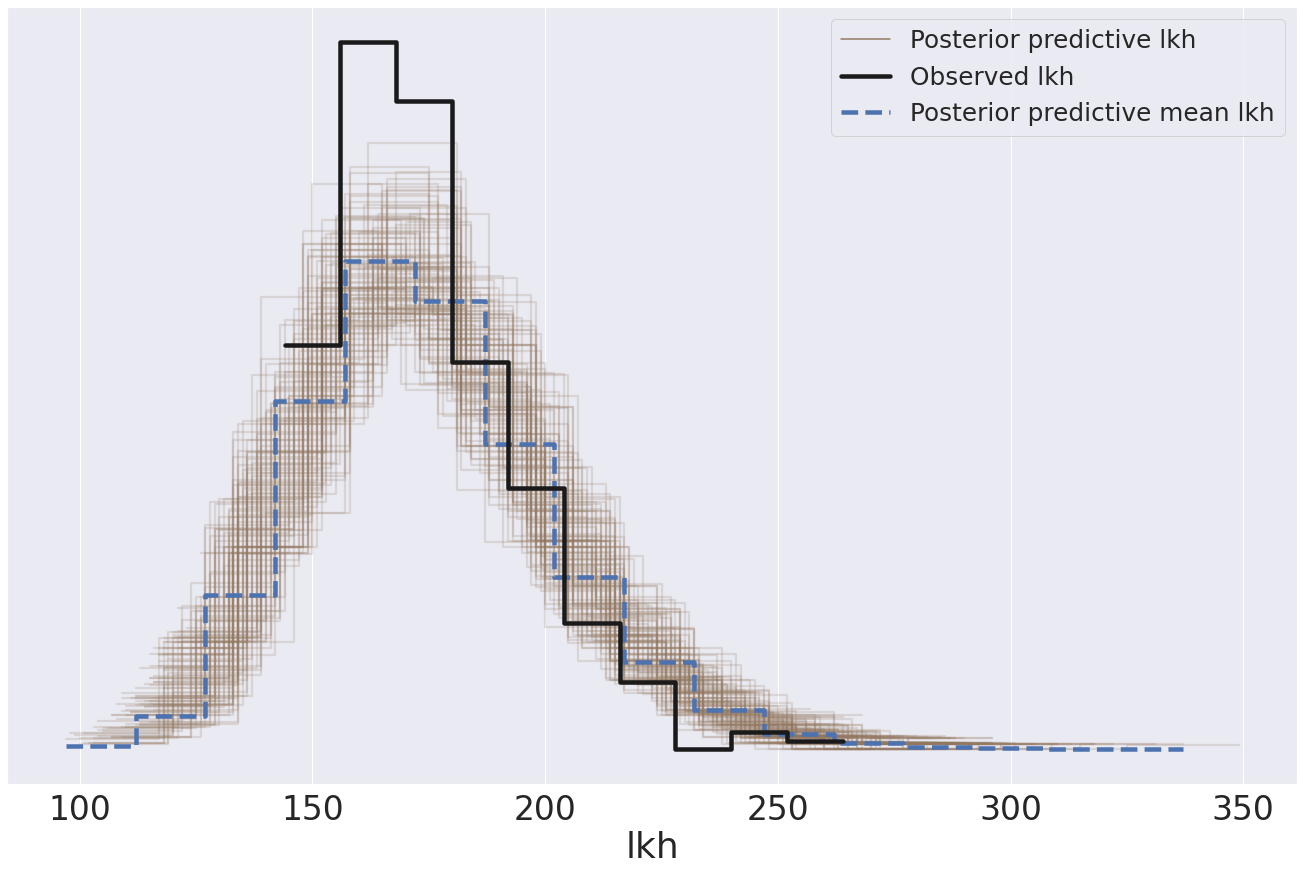

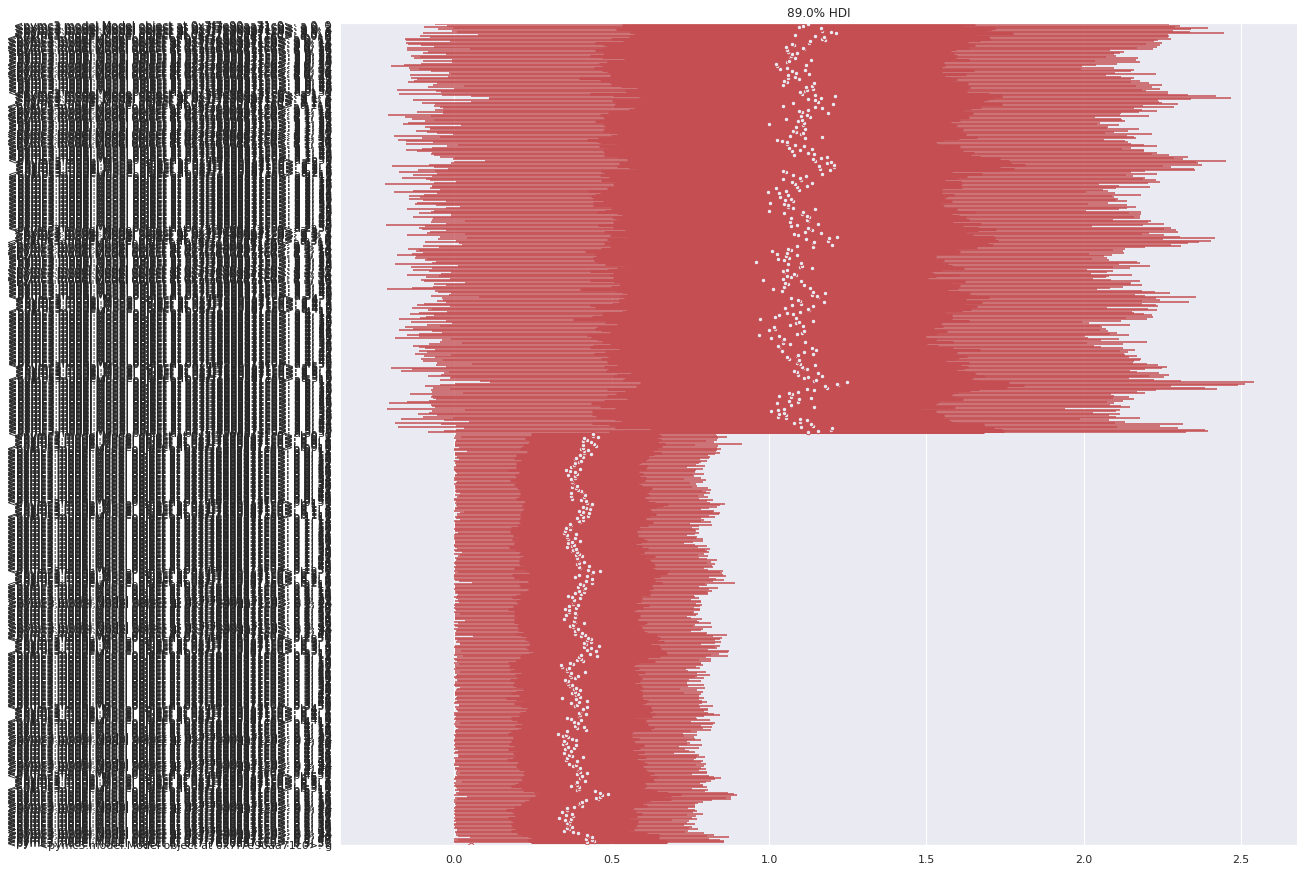

In [89]:
post_samples3 = pm.sample_posterior_predictive(trace3,100,model3)
data_ppc3 = az.from_pymc3(trace=trace3,model=model3,posterior_predictive=post_samples3)
az.plot_ppc(data_ppc3,figsize=(18,12))
az.plot_forest(trace3,model_names=[model3],figsize=(18,12),combined=True,colors='r',hdi_prob=0.89)


In [90]:
weekly_deaths_per_m

2015   2015-2018        2016        2017        2018  \
2020-01-07  200.841511  205.020072  191.524085  224.755843  202.958848   
2020-01-14  202.604188  203.390006  197.541635  216.245471  197.168731   
2020-01-21  200.841511  204.198563  204.285441  214.092244  197.575055   
2020-01-28  200.012016  199.511786  205.115448  197.071501  195.848178   
2020-02-04  203.848431  197.167803  200.342908  196.148689  188.331184   
2020-02-11  198.871460  196.681977  198.475393  187.945921  201.435133   
2020-02-18  212.558130  202.156301  184.987781  205.479338  205.599955   
2020-02-25  222.823132  211.136701  194.429109  212.349156  214.945407   
2020-03-03  180.726254  184.576484  187.374051  179.538084  190.667547   
2020-03-10  210.277018  206.187779  196.815379  192.047305  225.611413   
2020-03-17  195.553480  194.774426  181.667753  188.048456  213.828016   
2020-03-24  191.509691  191.092142  190.797829  176.359511  205.701536   
2020-03-31  205.196361  189.868267  180.422743  178.615273  195.238692   
2020-04-07  187.258528  190.661312  184.676528  188.868733  201.841457   
2020-04-14  190.058074  181.893845  177.413968  174.616423  185.486916   
2020-04-21  191.613378  180.103178  182.082757  176.974719  169.741860   
2020-04-28  177.511960  177.288220  178.762729  184.152141  168.726050   
2020-05-05  172.223929  172.248562  170.566412  176.462046  169.741860   
2020-05-12  170.875999  167.223045  163.096350  175.539235  159.380597   
2020-05-19  173.675545  164.858427  163.615104  167.028863  155.114195   
2020-05-26  170.875999  159.976177  156.041291  165.593378  147.394039   
2020-06-02  169.839130  160.992880  162.577595  164.465498  147.089296   
2020-06-09  165.587968  160.323639  155.003783  165.080705  155.622100   
2020-06-16  166.935897  157.359647  157.908807  158.723560  145.870323   
2020-06-23  164.758472  157.110975  157.908807  154.827246  150.949374   
2020-06-30  156.256147  160.477305  162.785097  157.595680  165.272295   
2020-07-07  176.993526  166.302214  160.087575  166.106051  162.021703   
2020-07-14  162.269987  161.751337  168.387644  155.544988  160.802731   
2020-07-21  157.085642  163.304598  163.407602  158.005818  174.719329   
2020-07-28  162.062613  163.343421  174.093941  150.725862  166.491268   
2020-08-04  161.129431  164.056282  163.303851  155.955126  175.836720   
2020-08-11  159.055693  156.693540  159.361319  159.236233  149.120916   
2020-08-18  156.152460  157.699952  167.246384  154.724711  152.676251   
2020-08-25  163.203169  159.654419  161.332585  163.132548  150.949374   
2020-09-01  153.145540  159.295410  168.906398  155.647522  159.482178   
2020-09-08  168.802261  167.046546  171.188917  162.414806  165.780201   
2020-09-15  162.269987  159.245098  156.352544  164.157894  154.199966   
2020-09-22  163.514230  162.893095  158.842565  162.927479  166.288106   
2020-09-29  169.839130  162.970476  165.378869  156.775403  159.888502   
2020-10-06  165.691655  165.030438  164.133858  169.899832  160.396407   
2020-10-13  162.477361  169.334191  166.623879  176.462046  171.773480   
2020-10-20  165.069533  168.905823  182.601511  169.079555  158.872692   
2020-10-27  174.608727  170.414184  171.085166  167.541536  168.421307   
2020-11-03  173.468171  174.567254  176.376460  174.924027  173.500357   
2020-11-10  174.919788  171.819409  176.168958  170.002366  166.186525   
2020-11-17  174.193980  172.813108  183.431518  178.512738  155.114195   
2020-11-24  175.541909  172.109966  180.422743  174.821492  157.653720   
2020-12-01  175.127162  177.319698  180.941497  176.154442  177.055692   
2020-12-08  187.880650  184.327316  185.195283  181.793845  182.439485   
2020-12-15  173.571858  181.454976  192.354092  184.869883  175.024072   
2020-12-22  183.422113  181.953931  189.034064  177.897530  177.462016   
2020-12-29  185.910599  190.963388  201.484167  196.558828  179.899960   

                  2019        2020     excess  cum_excess   abs_excess  \
2020-01-07  197.91122

In [91]:
excess_2019 = weekly_deaths_per_m['2019'] - weekly_deaths_per_m['2015-2018']
excess_2020 = weekly_deaths_per_m['2020'] - weekly_deaths_per_m['2015-2018']

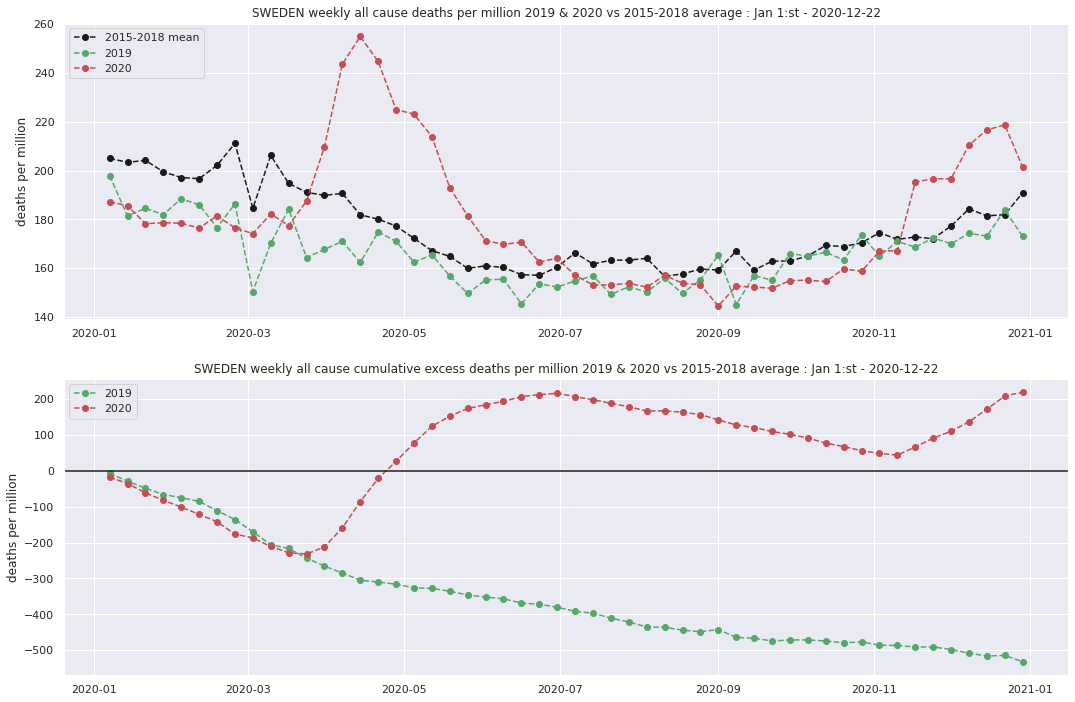

In [92]:
xticks = ['Jan','Feb','Mar','April','May','Jun','Jul','Aug']

plt.figure(figsize=(18,12))

plt.subplot(211)

plt.title('SWEDEN weekly all cause deaths per million 2019 & 2020 vs 2015-2018 average : Jan 1:st - {}'.format(last_week))
plt.plot(weekly_deaths_per_m['2015-2018'],'o--',color='k',label='2015-2018 mean')
plt.plot(weekly_deaths_per_m['2019'],'o--',color='g',label='2019')
plt.plot(weekly_deaths_per_m['2020'],'o--',color='r',label='2020')
plt.ylabel('deaths per million')
plt.legend(loc='upper left')

plt.subplot(212)

plt.title('SWEDEN weekly all cause cumulative excess deaths per million 2019 & 2020 vs 2015-2018 average : Jan 1:st - {}'.format(last_week))

plt.plot(excess_2019.cumsum(),'o--',color='g',label='2019')
plt.plot(excess_2020.cumsum(),'o--',color='r',label='2020')
plt.axhline(0,color='k')

plt.ylabel('deaths per million')
plt.legend(loc='upper left')
plt.savefig('excess_deaths_2019_2020_cmp_15-18.jpg',format='jpg')

In [93]:
data.head()

year       week  dead_per_m  week_idx  year_idx        pop
0  2015 2020-01-07  200.841511         0         0  9747355.0
1  2015 2020-01-14  202.604188         1         0  9747355.0
2  2015 2020-01-21  200.841511         2         0  9747355.0
3  2015 2020-01-28  200.012016         3         0  9747355.0
4  2015 2020-02-04  203.848431         4         0  9747355.0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [g, b, a]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 136 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


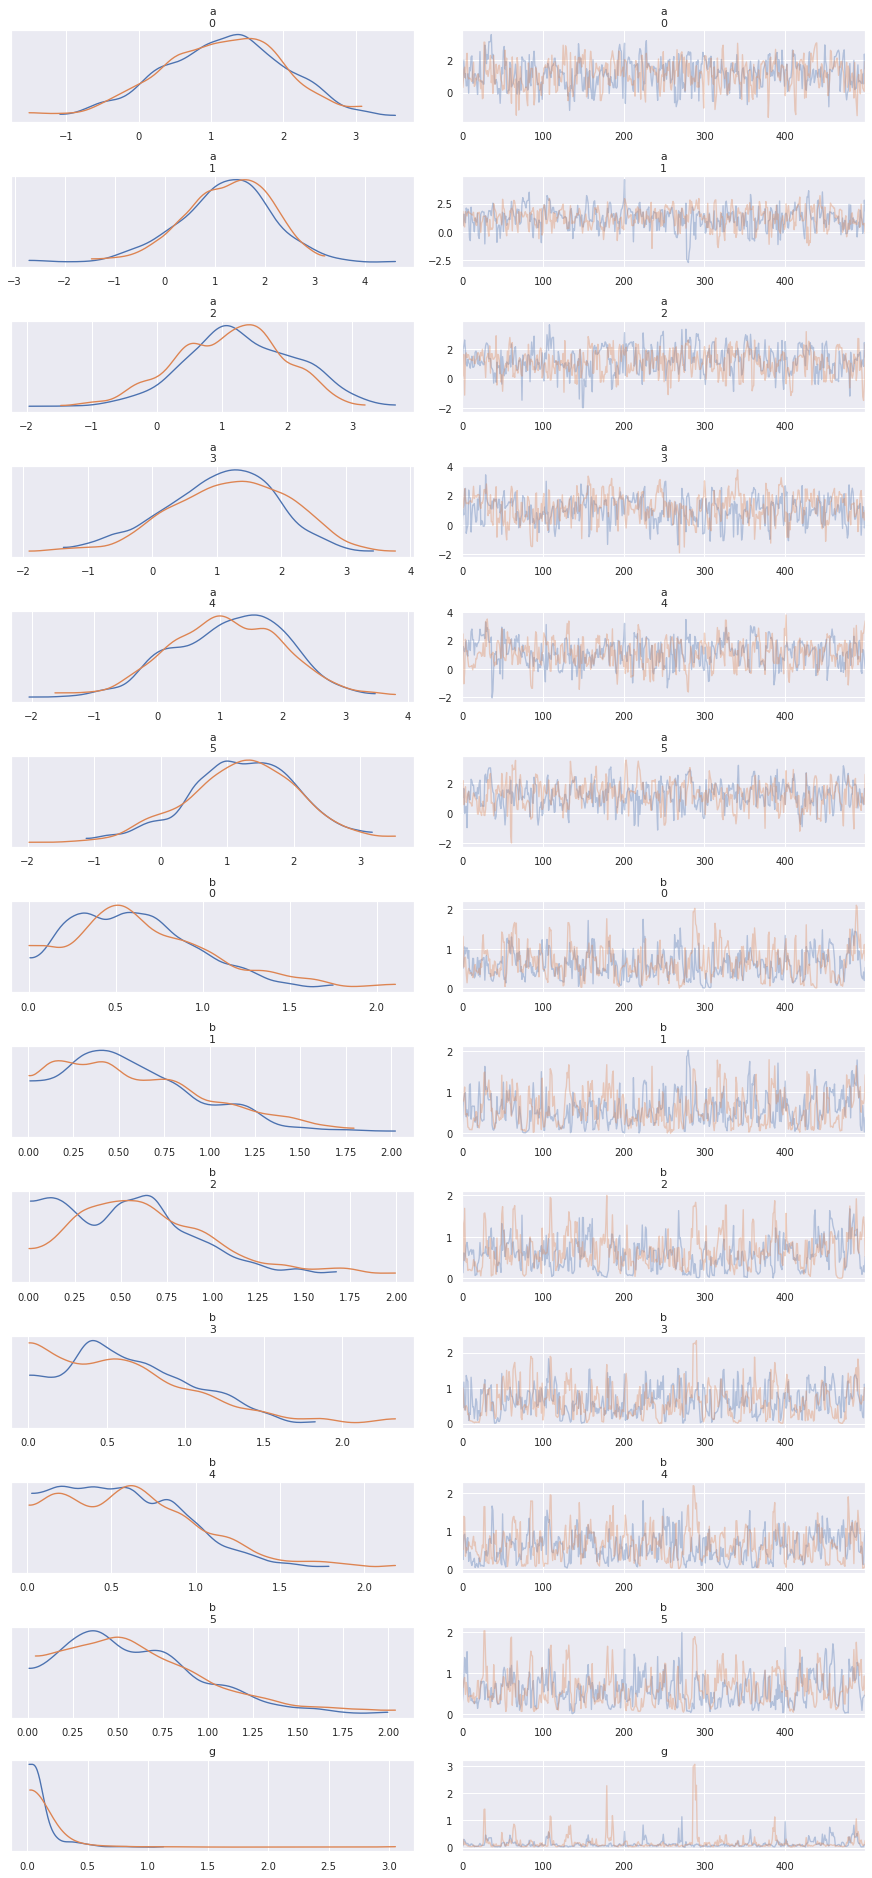

In [94]:
# ONLY condition on years

# Scientific, dynamic model, not a GLM

# Delta D = alpha * Pop^beta - gamma

# alpha = deaths per individual
# beta = Elasticity (diminishing returns)
# gamma = death loss (e.g. better health care)

# D ~ Poisson(lambda)
# lambda = exp(a[year_idx]) * P^b[week_idx] / g
# a = pm.Normal('a',1,1,shape=len(unique_weeks))
# b = pm.Exponential('b',1,shape=len(unique_weeks))
# g = pm.Exponential(1)


model4 = pm.Model()

year_idx = data['year_idx'].values

with model4:
    
    a = pm.Normal('a',mu=1,sigma=1,shape=len(year_idx_map))
    b = pm.Exponential('b',1,shape=len(year_idx_map))
    g = pm.Exponential('g',1)
    
    lambda_ = np.exp(a[year_idx]) * np.log(data['pop'].values) ** b[year_idx] / g
    
    lkh = pm.Poisson('lkh',lambda_,observed=data['dead_per_m'].values.astype(int))
    
    step1 = pm.Metropolis()
    trace4 = pm.sample(500,tune=500,target_accept=0.95)
    
    result4 = pm.trace_to_dataframe(trace4)
    summary4 = az.summary(trace4)
    
    _= az.plot_trace(trace4)

In [95]:
summary4


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0]  1.143  0.839  -0.429    2.644      0.042    0.031     408.0   376.0   
a[1]  1.222  0.900  -0.523    2.815      0.045    0.032     405.0   405.0   
a[2]  1.184  0.863  -0.486    2.628      0.050    0.036     303.0   283.0   
a[3]  1.116  0.902  -0.586    2.711      0.056    0.041     256.0   245.0   
a[4]  1.126  0.917  -0.544    2.810      0.050    0.035     337.0   337.0   
a[5]  1.228  0.843  -0.371    2.820      0.043    0.033     379.0   336.0   
b[0]  0.633  0.375   0.003    1.291      0.026    0.019     203.0   203.0   
b[1]  0.601  0.396   0.010    1.301      0.026    0.018     235.0   235.0   
b[2]  0.613  0.391   0.002    1.320      0.029    0.020     186.0   186.0   
b[3]  0.634  0.421   0.004    1.345      0.027    0.019     236.0   236.0   
b[4]  0.613  0.391   0.027    1.270      0.024    0.017     267.0   267.0   
b[5]  0.606  0.381   0.008    1.273      0.024    0.017     249.0   249.0   
g     0.158  0.249   0.014    0.435      0.017    0.012     226.0   226.0   

      ess_bulk  ess_tail  r_hat  
a[0]     400.0     512.0   1.00  
a[1]     408.0     419.0   1.01  
a[2]     299.0     334.0   1.01  
a[3]     249.0     416.0   1.01  
a[4]     334.0     488.0   1.00  
a[5]     375.0     386.0   1.00  
b[0]     201.0     254.0   1.01  
b[1]     228.0     351.0   1.01  
b[2]     174.0     213.0   1.01  
b[3]     218.0     223.0   1.00  
b[4]     253.0     347.0   1.00  
b[5]     239.0     279.0   1.01  
g        212.0     391.0   1.00

In [96]:

alphas = result4.iloc[:,0:6]
betas = result4.iloc[:,6:12]
gamma = result4['g']
betas

b__0      b__1      b__2      b__3      b__4      b__5
0    0.658338  0.150102  0.469620  0.720174  0.653459  0.261290
1    0.502516  0.636709  0.135340  0.449504  0.246788  0.460293
2    0.720645  0.856117  0.612989  1.168859  0.882880  0.847661
3    1.049006  0.964334  0.428484  0.527308  0.913061  1.385684
4    0.873424  0.995063  0.582967  0.378323  0.721858  1.273152
..        ...       ...       ...       ...       ...       ...
995  0.744888  0.794465  1.028108  0.606990  0.709212  0.689205
996  0.857049  0.721357  1.393700  0.771823  0.019182  0.578465
997  0.900293  0.728074  1.478981  0.654476  0.030087  0.626628
998  1.111267  0.866533  1.246888  1.011884  0.036805  0.930980
999  0.697980  1.427018  0.525890  1.019530  0.135835  0.454554

[1000 rows x 6 columns]

In [97]:
lambdas = pd.DataFrame(np.exp(alphas.values) * np.log(pop.T.values) ** betas.values) 
lambdas.columns=['2015','2016','2017','2018','2019','2020']
lambdas = lambdas.div(gamma,axis=0)
lambdas

2015        2016        2017        2018        2019        2020
0    176.908950  177.936009  175.898834  174.509965  166.369337  183.321621
1    179.152924  177.581972  176.998481  175.058334  167.571231  177.533437
2    179.021639  173.185383  173.212814  170.945604  162.192730  180.434983
3    178.903034  174.231276  173.123393  173.380029  162.616423  175.940479
4    178.144550  176.305496  175.340860  172.024247  165.208547  180.960366
..          ...         ...         ...         ...         ...         ...
995  176.639360  176.713847  175.898517  174.151728  162.723560  179.367096
996  175.592302  176.286342  177.371248  172.940331  165.255676  180.270193
997  178.960563  175.981960  172.041150  175.767232  165.383851  179.840547
998  174.349444  175.865551  173.636713  171.865977  165.011070  180.729049
999  178.967033  176.321165  174.438118  176.078642  164.830487  179.732564

[1000 rows x 6 columns]

In [98]:
lambdas.mean()

2015    177.802191
2016    175.976905
2017    175.341766
2018    173.669118
2019    165.465465
2020    179.841749
dtype: float64

Text(0, 0.5, 'average weekly deaths per million')

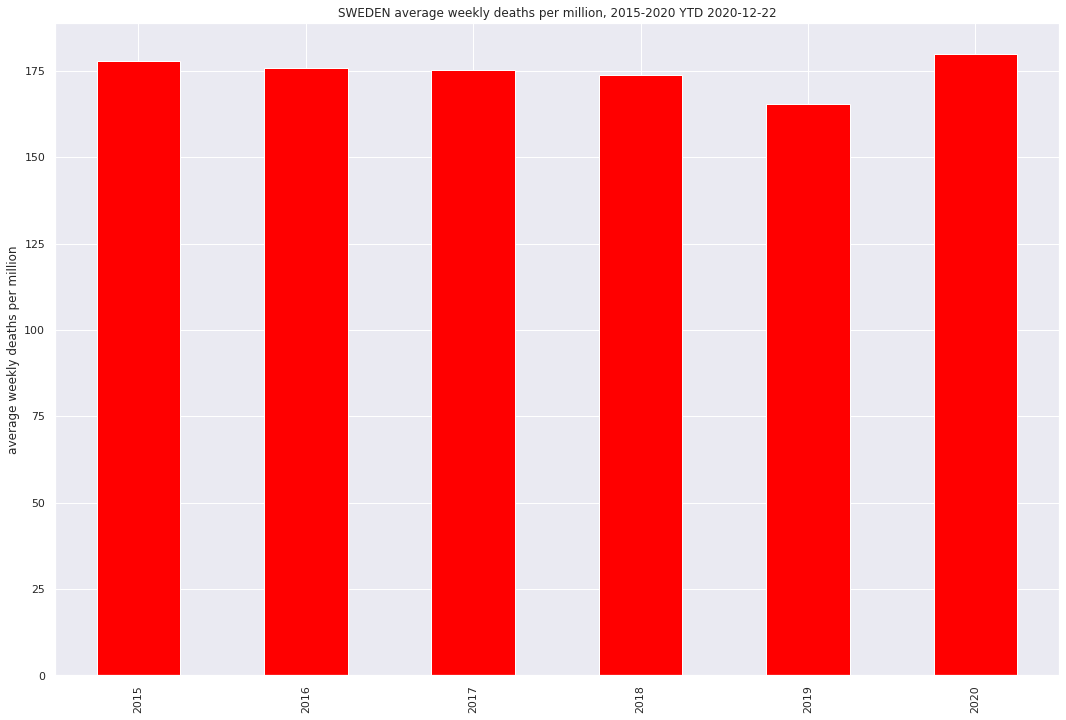

In [99]:
lambdas.mean().plot(kind='bar',
                    figsize=(18,12),color='red',
                    title='SWEDEN average weekly deaths per million, 2015-2020 YTD {}'.format(last_week))

plt.ylabel('average weekly deaths per million')

In [100]:
yearly_week_means = data.groupby('year').mean()
yearly_week_means

dead_per_m  week_idx  year_idx         pop
year                                            
2015  178.279642      25.5       0.0   9747355.0
2016  176.422349      25.5       1.0   9851017.0
2017  175.817261      25.5       2.0   9995153.0
2018  174.215331      25.5       3.0  10120242.0
2019  165.948701      25.5       4.0  10230185.0
2020  180.387434      25.5       5.0  10327589.0

In [101]:
CI = lambdas.quantile([0.055,0.945])
CI

2015        2016        2017        2018        2019        2020
0.055  174.856136  172.980545  172.479866  170.960711  162.449248  177.011256
0.945  180.656379  178.941686  178.324184  176.583482  168.393190  182.742383

In [102]:
samples = pm.Poisson.dist(lambdas.mean()).random(size=1000)
samples

array([[163, 160, 183, 176, 192, 190],
       [194, 191, 189, 152, 166, 167],
       [177, 171, 185, 169, 151, 214],
       ...,
       [150, 164, 173, 167, 166, 149],
       [182, 175, 167, 194, 174, 173],
       [176, 185, 186, 181, 174, 194]])

In [103]:
sample_CI = np.percentile(samples,[5.5,94.5],axis=0)
sample_CI

array([[155., 156., 154., 153., 147., 159.],
       [199., 196., 197., 194., 186., 202.]])

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<AxesSubplot:>

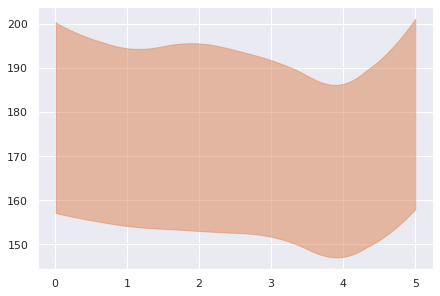

In [104]:
az.plot_hdi([0,1,2,3,4,5],samples,hdi_prob=0.89)

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


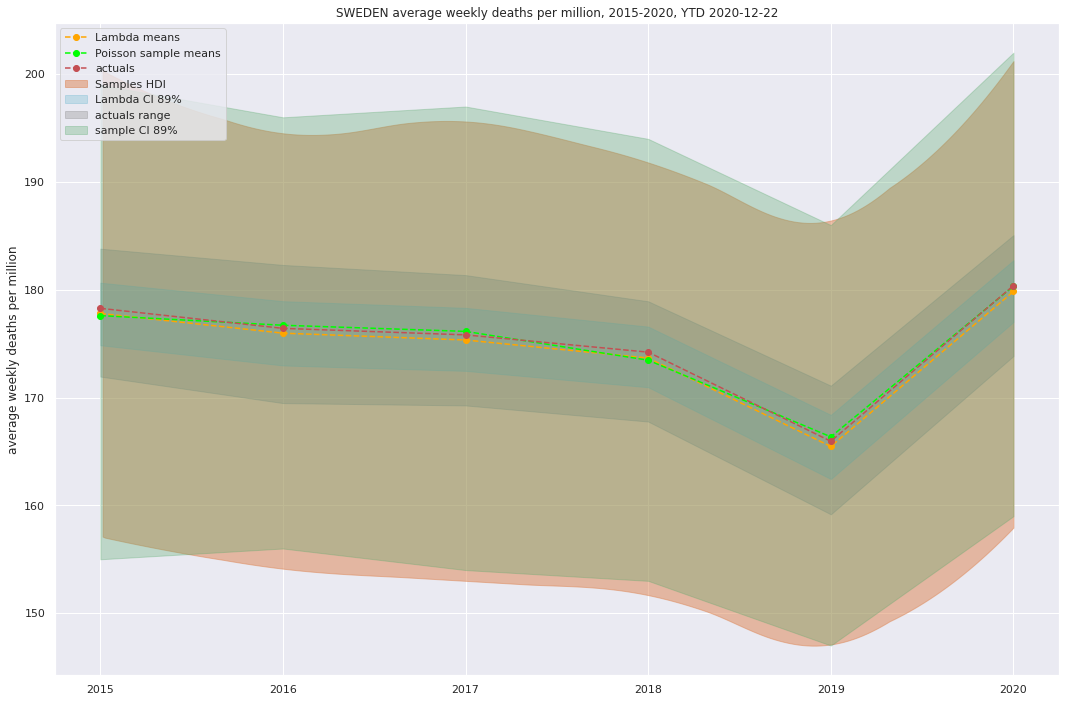

In [105]:
plt.figure(figsize=(18,12))
plt.title('SWEDEN average weekly deaths per million, 2015-2020, YTD {}'.format(last_week))

ax = plt.gca()

az.plot_hdi([0,1,2,3,4,5],samples,hdi_prob=0.89,ax=ax,fill_kwargs={'alpha' : 0.5,'label' : 'Samples HDI'})

plt.plot(lambdas.mean(),'o--',color='orange',label='Lambda means')
plt.fill_between(lambdas.mean().index,CI.loc[0.055],CI.loc[0.945],color='c',alpha=0.3,label='Lambda CI 89%')
plt.fill_between(lambdas.mean().index,lambdas.min(),lambdas.max(),color='grey',alpha=0.3,label='actuals range')

plt.plot(lambdas.mean().index,samples.mean(axis=0),'o--',color='lime',label='Poisson sample means')
plt.fill_between(lambdas.mean().index,sample_CI[0],sample_CI[1],color='g',alpha=0.3,label='sample CI 89%')

plt.plot(yearly_week_means['dead_per_m'],'o--',color='r',label='actuals')
plt.ylabel('average weekly deaths per million')
plt.legend(loc='upper left')

In [106]:
post_samples4 = pm.sample_posterior_predictive(trace4,1000,model4)
post_samples4['lkh'].shape

(1000, 312)

In [107]:
np.percentile(post_samples4['lkh'],[5.5,94.5])

array([152., 197.])

In [108]:
data_ppc4 = az.from_pymc3(trace=trace4,model=model4,posterior_predictive=post_samples4)
data_ppc4

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

array([<AxesSubplot:xlabel='lkh'>], dtype=object)

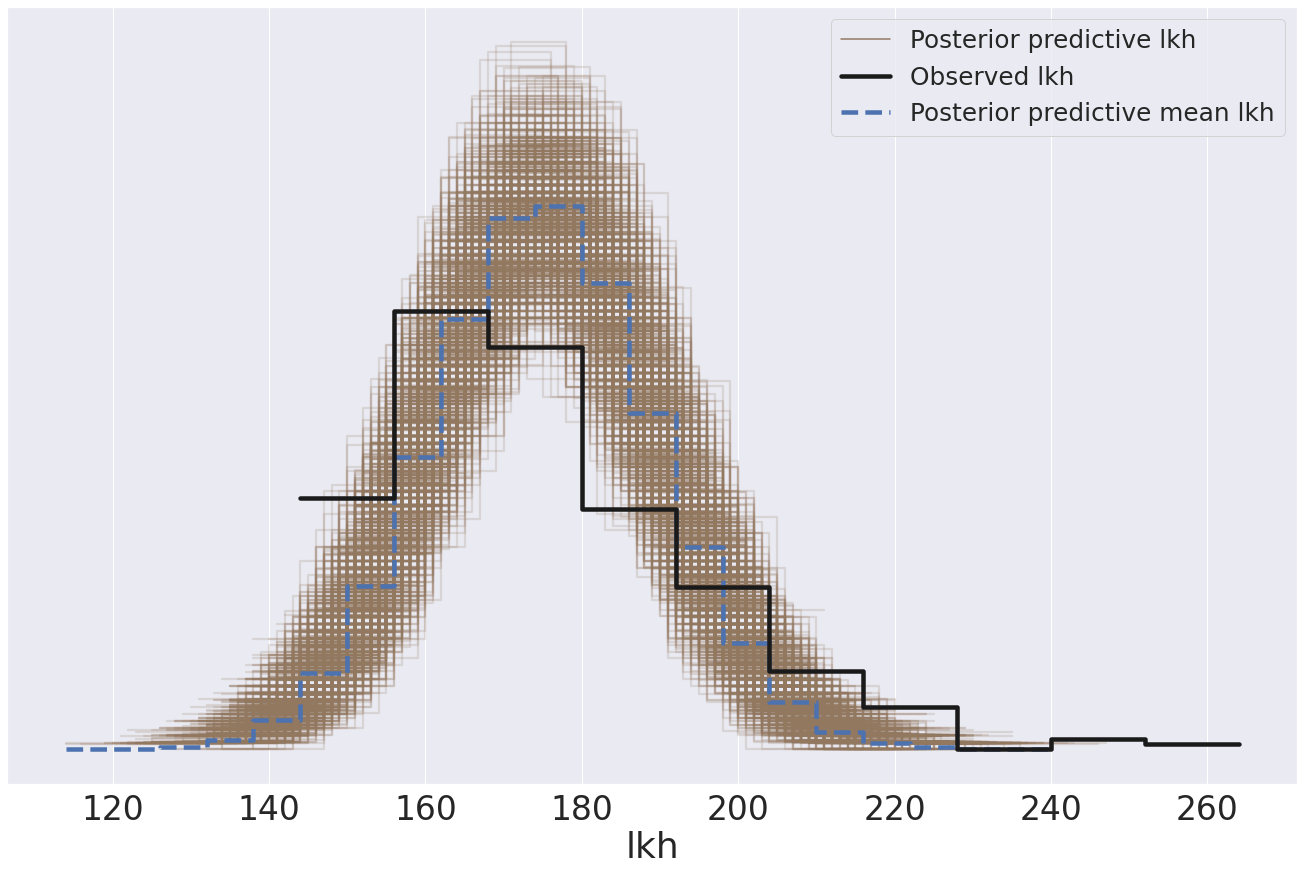

In [109]:
az.plot_ppc(data_ppc4,figsize=(18,12),)

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

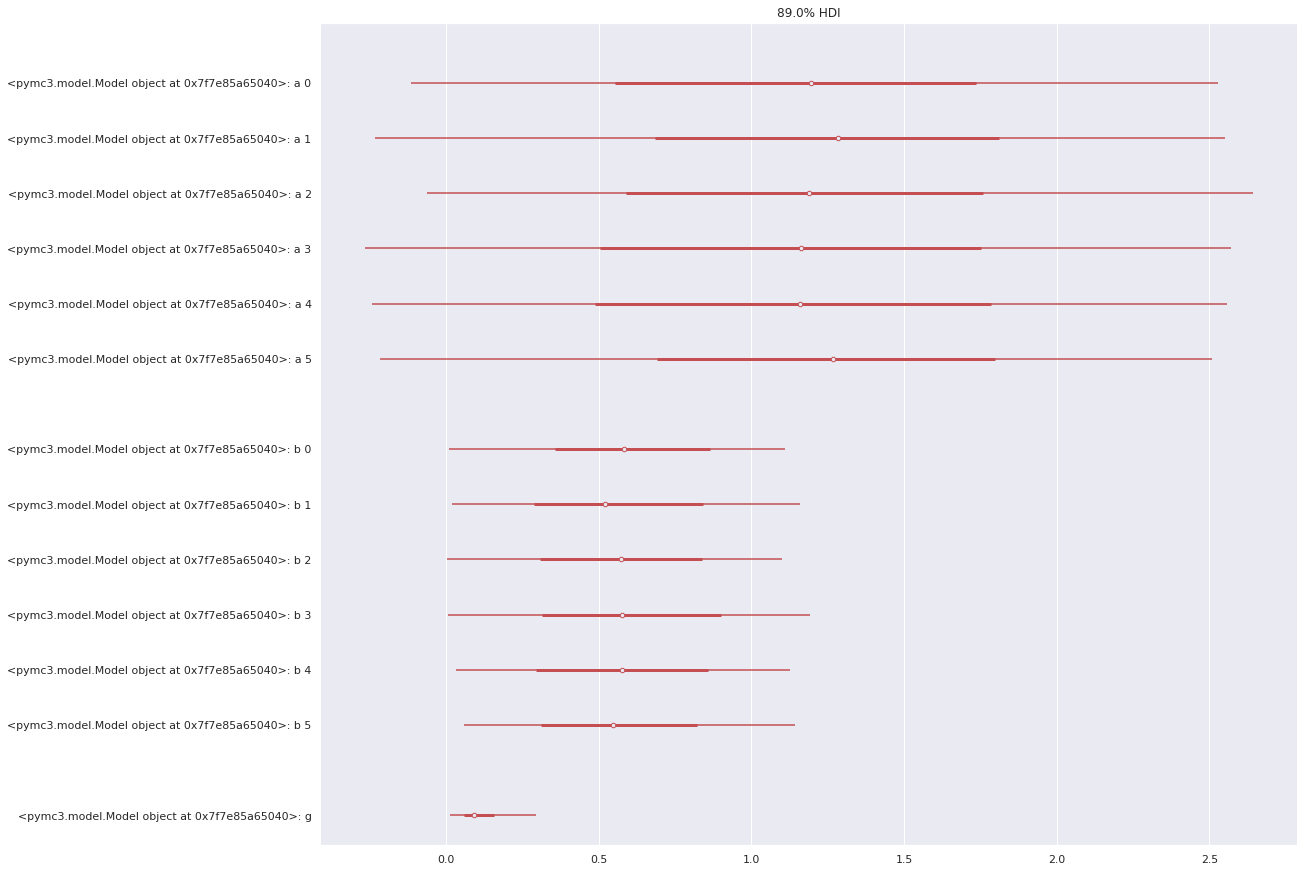

In [110]:
az.plot_forest(trace4,model_names=[model4],figsize=(18,12),combined=True,colors='r',hdi_prob=0.89)


In [111]:
scb_daily = parse_scb_prel_2021(YTD=False)
scb_daily.drop('2015-2019',axis=1,inplace=True)
scb_daily = scb_daily.astype(float)
scb_daily.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2020-01-01 to 2020-12-31
Freq: D
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   2015       366 non-null    float64
 1   2016       366 non-null    float64
 2   2017       366 non-null    float64
 3   2018       366 non-null    float64
 4   2019       366 non-null    float64
 5   2020       366 non-null    float64
 6   2021       366 non-null    float64
 7   2016-2020  366 non-null    float64
dtypes: float64(8)
memory usage: 25.7 KB


In [112]:
print (scb_daily.loc['2020-02-29'])
print (scb_daily.loc['2020-02-28'])

scb_daily.loc['2020-02-28'] += 0.5 * scb_daily.loc['2020-02-29']
scb_daily.loc['2020-03-01'] += 0.5 * scb_daily.loc['2020-02-29']

scb_daily.loc['2020-02-27' : '2020-03-02']

2015           0.000000
2016         248.358508
2017           0.000000
2018           0.000000
2019           0.000000
2020         250.663622
2021           0.000000
2016-2020    250.456375
Name: 2020-02-29 00:00:00, dtype: float64
2015         267.828332
2016         261.645177
2017         306.429854
2018         312.519404
2019         265.834335
2020         238.335903
2021           0.000000
2016-2020    277.144349
Name: 2020-02-28 00:00:00, dtype: float64


2015        2016        2017        2018        2019  \
2020-02-27  299.159194  268.799537  260.311649  309.435331  248.318120   
2020-02-28  267.828332  385.824431  306.429854  312.519404  265.834335   
2020-02-29    0.000000  248.358508    0.000000    0.000000    0.000000   
2020-03-01  276.924389  360.273144  325.901986  339.248037  276.137992   
2020-03-02  298.148521  254.490817  280.808629  311.491380  269.955798   

                  2020  2021   2016-2020  
2020-02-27  261.964031   0.0  269.959126  
2020-02-28  363.667713   0.0  402.372537  
2020-02-29  250.663622   0.0  250.456375  
2020-03-01  395.514321   0.0  414.690064  
2020-03-02  244.499762   0.0  272.012047

In [113]:
scb_daily.drop(pd.to_datetime('2020-02-29'),inplace=True)
scb_daily['2015-2018'] = scb_daily.loc[:,'2015' : '2018'].mean(axis=1)
scb_daily

2015        2016        2017        2018        2019  \
2020-01-01  298.148521  250.402611  347.423815  282.706698  309.109692   
2020-01-02  274.903043  277.998000  324.877137  320.743599  284.380917   
2020-01-03  283.999099  299.461081  317.703194  303.267185  279.229089   
2020-01-04  258.732276  265.733383  312.578949  292.986941  290.563111   
2020-01-05  270.860351  265.733383  311.554100  299.155087  283.350551   
...                ...         ...         ...         ...         ...   
2020-12-27  229.422760  254.490817  277.734082  246.725845  245.227023   
2020-12-28  276.924389  267.777486  279.783780  268.314357  221.528613   
2020-12-29  295.116502  280.042103  282.858327  270.370405  251.409216   
2020-12-30  286.020445  313.769802  281.833478  238.501650  232.862635   
2020-12-31  257.721603  295.372875  309.504402  265.230284  253.469948   

                  2020        2021   2016-2020   2015-2018  
2020-01-01  260.936721   96.574586  290.488337  294.670411  
2020-01-02  310.247597  113.856354  303.832324  299.630445  
2020-01-03  262.991341  109.790055  292.541258  301.107640  
2020-01-04  281.482919   80.309392  288.435416  282.507887  
2020-01-05  272.237130   58.961326  286.382494  286.825730  
...                ...         ...         ...         ...  
2020-12-27  315.384147    0.000000  267.906205  252.093376  
2020-12-28  323.602626    0.000000  272.012047  273.200003  
2020-12-29  223.953564    0.000000  261.747441  282.096834  
2020-12-30  141.768770    0.000000  242.244691  280.031344  
2020-12-31  147.932629    0.000000  254.562217  281.957291  

[365 rows x 9 columns]

In [114]:
scb_daily.loc['2020-02-27' : '2020-03-03']

2015        2016        2017        2018        2019  \
2020-02-27  299.159194  268.799537  260.311649  309.435331  248.318120   
2020-02-28  267.828332  385.824431  306.429854  312.519404  265.834335   
2020-03-01  276.924389  360.273144  325.901986  339.248037  276.137992   
2020-03-02  298.148521  254.490817  280.808629  311.491380  269.955798   
2020-03-03  313.308615  309.681596  322.827439  312.519404  230.801904   

                  2020  2021   2016-2020   2015-2018  
2020-02-27  261.964031   0.0  269.959126  284.426428  
2020-02-28  363.667713   0.0  402.372537  318.150505  
2020-03-01  395.514321   0.0  414.690064  325.586889  
2020-03-02  244.499762   0.0  272.012047  286.234837  
2020-03-03  268.127890   0.0  288.435416  314.584263

In [115]:
scb_daily.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-01-01 to 2020-12-31
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   2015       365 non-null    float64
 1   2016       365 non-null    float64
 2   2017       365 non-null    float64
 3   2018       365 non-null    float64
 4   2019       365 non-null    float64
 5   2020       365 non-null    float64
 6   2021       365 non-null    float64
 7   2016-2020  365 non-null    float64
 8   2015-2018  365 non-null    float64
dtypes: float64(9)
memory usage: 38.5 KB


In [116]:
pop['2015-2018'] = pop['2015' : '2018'].mean()
pop

year
2015          9747355.00
2016          9851017.00
2017          9995153.00
2018         10120242.00
2019         10230185.00
2020         10327589.00
2015-2018     9928441.75
Name: population, dtype: float64

In [117]:
scb_daily_per_m = scb_daily / (pop / 1e6)
scb_daily_per_m

2015  2015-2018       2016  2016-2020       2017       2018  \
2020-01-01  30.587633  29.679422  25.418960        NaN  34.759229  27.934776   
2020-01-02  28.202835  30.179000  28.220234        NaN  32.503468  31.693274   
2020-01-03  29.136017  30.327784  30.399002        NaN  31.785726  29.966397   
2020-01-04  26.543845  28.454403  26.975223        NaN  31.273053  28.950586   
2020-01-05  27.788087  28.889300  26.975223        NaN  31.170518  29.560073   
...               ...        ...        ...        ...        ...        ...   
2020-12-27  23.536925  25.391031  25.833964        NaN  27.786877  24.379441   
2020-12-28  28.410209  27.516906  27.182725        NaN  27.991946  26.512642   
2020-12-29  30.276573  28.413002  28.427735        NaN  28.299550  26.715804   
2020-12-30  29.343391  28.204964  31.851514        NaN  28.197015  23.566793   
2020-12-31  26.440158  28.398947  29.983998        NaN  30.965449  26.207899   

                 2019       2020  2021  
2020-01-01  30.215455  25.265986   NaN  
2020-01-02  27.798218  30.040661   NaN  
2020-01-03  27.294627  25.464931   NaN  
2020-01-04  28.402528  27.255434   NaN  
2020-01-05  27.697500  26.360182   NaN  
...               ...        ...   ...  
2020-12-27  23.970927  30.538023   NaN  
2020-12-28  21.654409  31.333802   NaN  
2020-12-29  24.575237  21.684980   NaN  
2020-12-30  22.762309  13.727189   NaN  
2020-12-31  24.776673  14.324024   NaN  

[365 rows x 9 columns]

<AxesSubplot:>

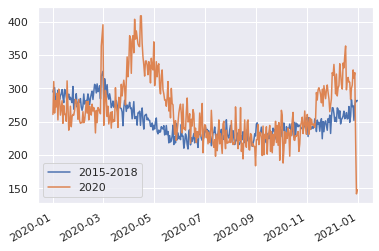

In [118]:
scb_daily.plot(y=['2015-2018','2020'])

<AxesSubplot:>

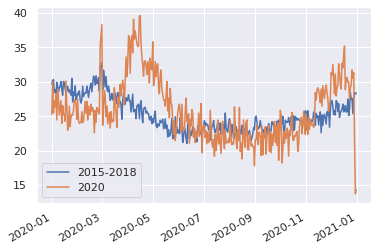

In [119]:
scb_daily_per_m.plot(y=['2015-2018','2020'])

In [120]:
scb_monthly_per_m = scb_daily_per_m.resample('M').sum()
scb_monthly_per_m

2015   2015-2018        2016  2016-2020        2017  \
2020-01-31  895.543692  896.697159  886.862340        0.0  933.167392   
2020-02-29  836.442163  813.828888  783.370858        0.0  807.459972   
2020-03-31  893.677328  875.403348  843.546356        0.0  828.069427   
2020-04-30  797.766952  778.768833  768.378859        0.0  775.776781   
2020-05-31  758.054872  730.636654  725.322253        0.0  751.783685   
2020-06-30  701.649203  680.544484  678.738117        0.0  682.367761   
2020-07-31  729.540977  724.186223  734.971083        0.0  694.979517   
2020-08-31  695.946424  702.980165  726.774765        0.0  699.696108   
2020-09-30  717.098550  699.753694  698.035777        0.0  693.338963   
2020-10-31  741.050222  750.915241  763.295067        0.0  760.294057   
2020-11-30  748.515678  740.921190  767.860105        0.0  747.374697   
2020-12-31  811.038875  822.470120  858.642106        0.0  827.351685   

                  2018        2019         2020  2021  
2020-01-31  871.361863  823.270425   808.312613   0.0  
2020-02-29  827.986774  734.638424   720.577968   0.0  
2020-03-31  935.561058  762.436643   844.818979   0.0  
2020-04-30  773.539355  723.760860  1032.026010   0.0  
2020-05-31  688.516053  702.207169   866.006597   0.0  
2020-06-30  660.174953  649.833714   720.180078   0.0  
2020-07-31  737.376517  677.128342   681.385848   0.0  
2020-08-31  689.836606  687.804469   675.218560   0.0  
2020-09-30  691.055579  672.193151   655.224610   0.0  
2020-10-31  739.103394  739.070024   701.678215   0.0  
2020-11-30  701.010517  728.494615   796.176982   0.0  
2020-12-31  793.449232  776.033597   906.591331   0.0

<AxesSubplot:>

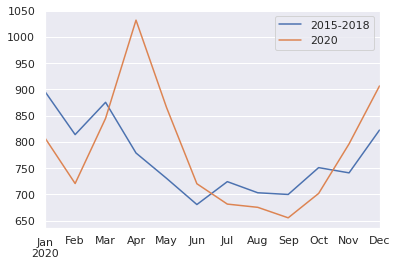

In [121]:
scb_monthly_per_m.plot(y=['2015-2018','2020'])

In [122]:
scb_transaction = scb_monthly_per_m.unstack().reset_index()
scb_transaction.columns=['year','month','dead_per_m']
scb_transaction = scb_transaction.loc[scb_transaction['year'] != '2015-2018']
scb_transaction

year      month  dead_per_m
0    2015 2020-01-31  895.543692
1    2015 2020-02-29  836.442163
2    2015 2020-03-31  893.677328
3    2015 2020-04-30  797.766952
4    2015 2020-05-31  758.054872
..    ...        ...         ...
103  2021 2020-08-31    0.000000
104  2021 2020-09-30    0.000000
105  2021 2020-10-31    0.000000
106  2021 2020-11-30    0.000000
107  2021 2020-12-31    0.000000

[96 rows x 3 columns]

In [123]:
scb_transaction['monthNr'] = scb_transaction['month'].dt.month
scb_transaction['year_month'] = scb_transaction['year'].astype(
    str).str.cat(scb_transaction['monthNr'].astype(str),'_')

In [124]:
scb_transaction

year      month  dead_per_m  monthNr year_month
0    2015 2020-01-31  895.543692        1     2015_1
1    2015 2020-02-29  836.442163        2     2015_2
2    2015 2020-03-31  893.677328        3     2015_3
3    2015 2020-04-30  797.766952        4     2015_4
4    2015 2020-05-31  758.054872        5     2015_5
..    ...        ...         ...      ...        ...
103  2021 2020-08-31    0.000000        8     2021_8
104  2021 2020-09-30    0.000000        9     2021_9
105  2021 2020-10-31    0.000000       10    2021_10
106  2021 2020-11-30    0.000000       11    2021_11
107  2021 2020-12-31    0.000000       12    2021_12

[96 rows x 5 columns]

In [125]:
scb_transaction.set_index('year_month',inplace=True)


In [126]:
scb_transaction = (scb_transaction.loc[scb_transaction['dead_per_m'] > 0 ]).copy()
scb_transaction

year      month  dead_per_m  monthNr
year_month                                      
2015_1      2015 2020-01-31  895.543692        1
2015_2      2015 2020-02-29  836.442163        2
2015_3      2015 2020-03-31  893.677328        3
2015_4      2015 2020-04-30  797.766952        4
2015_5      2015 2020-05-31  758.054872        5
...          ...        ...         ...      ...
2020_8      2020 2020-08-31  675.218560        8
2020_9      2020 2020-09-30  655.224610        9
2020_10     2020 2020-10-31  701.678215       10
2020_11     2020 2020-11-30  796.176982       11
2020_12     2020 2020-12-31  906.591331       12

[72 rows x 4 columns]

In [127]:
monthly_means=scb_transaction.loc[scb_transaction.year.isin(
    ['2015','2016','2017','2018'])].groupby('monthNr')['dead_per_m'].mean()

monthly_mins=scb_transaction.loc[scb_transaction.year.isin(
    ['2015','2016','2017','2018'])].groupby('monthNr')['dead_per_m'].min()

monthly_maxs=scb_transaction.loc[scb_transaction.year.isin(
    ['2015','2016','2017','2018'])].groupby('monthNr')['dead_per_m'].max()

scb_transaction['monthly_mean'] = scb_transaction['monthNr'].apply(lambda x : monthly_means.loc[x])
scb_transaction['monthly_min'] = scb_transaction['monthNr'].apply(lambda x : monthly_mins.loc[x])
scb_transaction['monthly_max'] = scb_transaction['monthNr'].apply(lambda x : monthly_maxs.loc[x])

scb_transaction

year      month  dead_per_m  monthNr  monthly_mean  monthly_min  \
year_month                                                                    
2015_1      2015 2020-01-31  895.543692        1    896.733822   871.361863   
2015_2      2015 2020-02-29  836.442163        2    813.814942   783.370858   
2015_3      2015 2020-03-31  893.677328        3    875.213542   828.069427   
2015_4      2015 2020-04-30  797.766952        4    778.865487   768.378859   
2015_5      2015 2020-05-31  758.054872        5    730.919216   688.516053   
...          ...        ...         ...      ...           ...          ...   
2020_8      2020 2020-08-31  675.218560        8    703.063476   689.836606   
2020_9      2020 2020-09-30  655.224610        9    699.882217   691.055579   
2020_10     2020 2020-10-31  701.678215       10    750.935685   739.103394   
2020_11     2020 2020-11-30  796.176982       11    741.190249   701.010517   
2020_12     2020 2020-12-31  906.591331       12    822.620474   793.449232   

            monthly_max  
year_month               
2015_1       933.167392  
2015_2       836.442163  
2015_3       935.561058  
2015_4       797.766952  
2015_5       758.054872  
...                 ...  
2020_8       726.774765  
2020_9       717.098550  
2020_10      763.295067  
2020_11      767.860105  
2020_12      858.642106  

[72 rows x 7 columns]

In [128]:
scb_transaction.groupby('year').sum()

dead_per_m  monthNr  monthly_mean  monthly_min  monthly_max
year                                                              
2015  9326.324936       78   9218.188641  8909.306858   9533.68875
2016  9235.797685       78   9218.188641  8909.306858   9533.68875
2017  9201.660045       78   9218.188641  8909.306858   9533.68875
2018  9108.971900       78   9218.188641  8909.306858   9533.68875
2019  8676.871435       78   9218.188641  8909.306858   9533.68875
2020  9408.197789       78   9218.188641  8909.306858   9533.68875

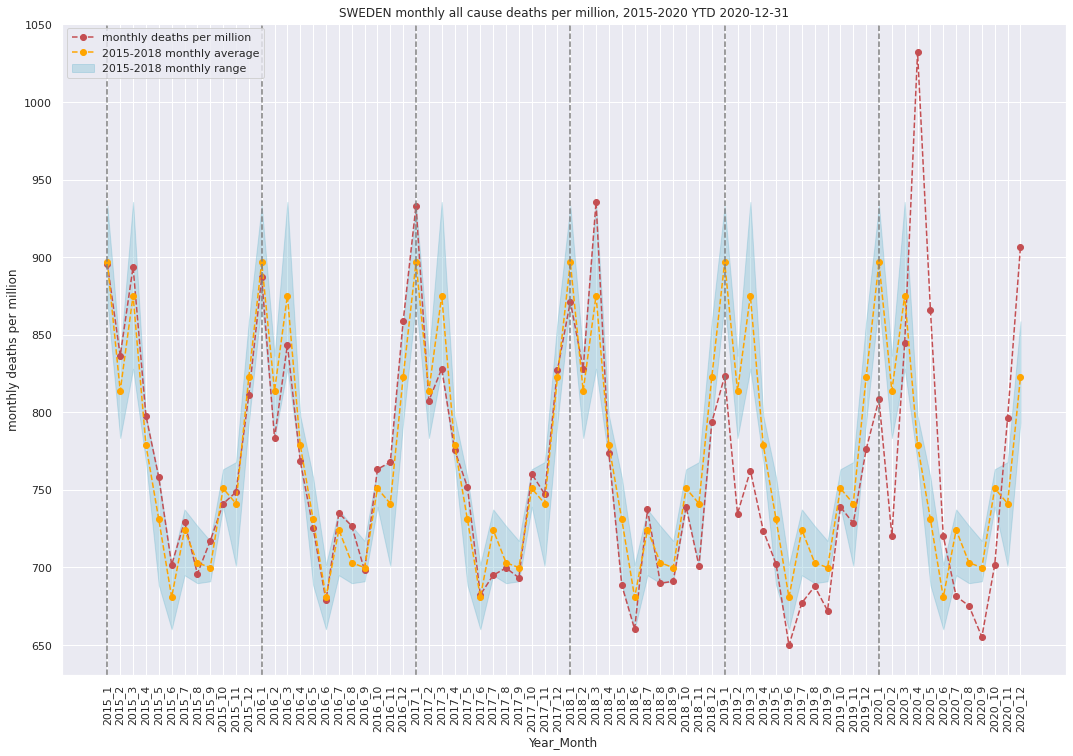

In [129]:
plt.figure(figsize=(18,12))
plt.title('SWEDEN monthly all cause deaths per million, 2015-2020 YTD {}'.format(scb_transaction.iloc[-1,1].date()))

plt.plot(scb_transaction['dead_per_m'],'o--',color='r',label='monthly deaths per million')

plt.plot(scb_transaction['monthly_mean'],'o--',color='orange',label='2015-2018 monthly average')

plt.fill_between(scb_transaction.index,scb_transaction['monthly_min'],
                scb_transaction['monthly_max'],color='c',alpha=0.3,label='2015-2018 monthly range')


_= plt.xticks(rotation=90)

for month in range(len(scb_transaction)):
    if month % 12 == 0:
        plt.axvline(month,color='grey',ls='dashed')

plt.legend(loc='upper left')
plt.ylabel('monthly deaths per million')
plt.xlabel('Year_Month')

plt.savefig('scb_deaths_per_m_monthly_2015_2020.jpg',format='jpg',dpi=400)